In [1]:
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/GaussFit_spec2D.py
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/ChainTool.py
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/RotationCurveFit.py
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/ChainTool.py

%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np

sys.path.append("/Users/hhg/Research/kinematic_lensing/repo/kl_measurement/scripts/")
from parameter_class import fit_parameters
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import emcee
import chisq
from generate_TFcube import get_TFcube_pars, get_data_TFcube

sys.path.append("/Users/hhg/Research/kinematic_lensing/code/BinnedFit/")
from binnedFit_utilities import *

dir_tfCube: /Users/hhg/Research/kinematic_lensing/repo/KLens


In [2]:
sini = 0.5
g1 = 0.05
g2 = 0.0

eint_thy = cal_e_int(sini=sini)
eobs_thy = cal_e_obs(e_int=eint_thy, gamma_p=g1)
theta_obs = cal_theta_obs(e_int=eint_thy, gamma_x=g2)

slitAng_major_p = theta_obs
slitAng_minor_p = theta_obs + np.pi/2.

bestfit_e_obs = eobs_thy
print("eobs_thy:", eobs_thy)
print("slitAng_major_p:", slitAng_major_p*180./np.pi)
print("slitAng_minor_p:", slitAng_minor_p*180./np.pi)

eobs_thy: 0.23450413223140495
slitAng_major_p: 0.0
slitAng_minor_p: 90.0


In [3]:
#TF_pars = load_pickle("/Users/hhg/Research/kinematic_lensing/data/TF_pars.pickle")
#meta_parameters = ("/Users/hhg/Research/kinematic_lensing/data/meta_parameters.pickle")

#data = load_pickle("/Users/hhg/Research/kinematic_lensing/data/data.pickle")
#noise = load_pickle("/Users/hhg/Research/kinematic_lensing/data/noise.pickle")
#obslambda = np.load("/Users/hhg/Research/kinematic_lensing/data/obslambda.npy")


update_TF, _ = get_TFcube_pars()

update_TF['slitAngles'] = np.array([slitAng_major_p, slitAng_minor_p])

update_TF['g1'] = g1
update_TF['g2'] = g2
update_TF['sini'] = sini
update_TF['vcirc'] = 200. 

update_TF['n_knots'] = 25.
update_TF['knot_fraction'] = 0.0
update_TF['throughput'] = 0.29
update_TF['slitWidth'] = 0.05
update_TF['psfFWHM'] = 0.5
update_TF['pixScale'] = 0.1185# 0.1185  # 0.032 

update_TF['redshift'] = 0.2
update_TF['Resolution'] = 6000.
update_TF['nm_per_pixel'] = 0.033 #0.033 # 0.025
update_TF['expTime'] = 3600.0 
update_TF['linelist']['flux'][update_TF['linelist']['species'] == 'Halpha'] = 6.0e-24
update_TF['lambda_min'] = (1 + update_TF['redshift']) * update_TF['linelist']['lambda'][update_TF['linelist']['species'] == 'Halpha'] - 2
update_TF['lambda_max'] = (1 + update_TF['redshift']) * update_TF['linelist']['lambda'][update_TF['linelist']['species'] == 'Halpha'] + 2
update_TF['norm'] = 0.
update_TF['ngrid'] = 256
update_TF['image_size'] = 128

TF_pars, meta_parameters = get_TFcube_pars(update_TF)

%time data, noise, obslambda = get_data_TFcube(TF_pars, meta_parameters, return_lambda=True)


# make data_info from Prangal's data output

data_info = {}
data_info['ModelCube'] = None
data_info['ObsCube'] = None
data_info['image'] = data['image']
data_info['image_variance'] = noise['image']

if len(TF_pars['slitAngles']) == 1:
    data_info['data'] = data['spectra'][0]
else:
    #data_info['data'] = data['spectra'][0] # this line is to make it compatible with older branches... 
    data_info['data_major'] = data['spectra'][0]
    data_info['data_minor'] = data['spectra'][1]
    
data_info['grid_lambda'] = obslambda

extent =  TF_pars['image_size'] * TF_pars['pixScale']
subGridPixScale = extent*1./TF_pars['ngrid']

data_info['grid_pos']    = np.arange(-extent/2., extent/2., subGridPixScale)
data_info['grid_Image']  = np.arange(-extent/2., extent/2., TF_pars['pixScale'])
data_info['par_fid']     = TF_pars
data_info['lambda_emit'] = 656.461 # Halpha [nm]

returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)
CPU times: user 8.93 s, sys: 153 ms, total: 9.08 s
Wall time: 7.74 s


In [4]:
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/gamma.py

Gamma=Gamma(data_info=data_info, sigma_TF_intr=0.08, mode_gamma_x=False)

time cost in gaussFit_spec2D: 0.15181183815002441 (secs)


In [5]:
chain_info = Gamma.run_MCMC(Nwalker=100, Nsteps=3000)

sini out of [-1, 1]! sini=114.09523759719598/110.88679786934509=1.0289343708132983


  1%|          | 20/3000 [00:00<00:15, 191.52it/s]

sini out of [-1, 1]! sini=165.8440109583696/153.93481662286862=1.0773651770065626
sini out of [-1, 1]! sini=164.5407763316568/159.69314045952115=1.0303559430178806
sini out of [-1, 1]! sini=103.62123651684838/97.57580345645576=1.061956272418402
sini out of [-1, 1]! sini=89.49394972820727/64.27746927171768=1.3923066782528872
sini out of [-1, 1]! sini=123.8271328176363/88.4825638854412=1.3994523596530937
sini out of [-1, 1]! sini=119.13114709766792/114.25279112560395=1.0426979150706344
sini out of [-1, 1]! sini=111.1139425266059/99.12717141658499=1.1209231630311143
sini out of [-1, 1]! sini=115.73783434232384/113.17629233323666=1.0226332030876657
sini out of [-1, 1]! sini=146.81838430514844/136.20832065184936=1.0778958554258853
sini out of [-1, 1]! sini=116.69580880566895/98.26867814013036=1.1875178440811185
sini out of [-1, 1]! sini=81.28268691770707/62.04073048122095=1.3101503848719263
sini out of [-1, 1]! sini=118.8908591641526/116.46812932229169=1.0208016549759866
sini out of [-1, 1]

  1%|▏         | 38/3000 [00:00<00:15, 187.06it/s]


sini out of [-1, 1]! sini=85.15524228421297/80.17183425809847=1.0621590870687996
sini out of [-1, 1]! sini=78.13281242308676/54.33928972016386=1.4378695935382049
sini out of [-1, 1]! sini=139.36197526141112/97.17585786932057=1.4341213786743339
sini out of [-1, 1]! sini=133.4950229523136/121.0246542818787=1.103039903269545
sini out of [-1, 1]! sini=132.9570411539653/92.6065044913253=1.4357203296278152
sini out of [-1, 1]! sini=136.5357320422359/122.03893976662397=1.1187882515476968
sini out of [-1, 1]! sini=119.14643418401234/100.25311247652274=1.1884562108923453
sini out of [-1, 1]! sini=160.84444993747422/114.96898183930439=1.3990247401015636
sini out of [-1, 1]! sini=134.08136517793173/130.10935856808783=1.030528216060379
sini out of [-1, 1]! sini=47.89242273877973/32.86942821888499=1.457050680037791
sini out of [-1, 1]! sini=71.4920997276004/69.58224943129349=1.027447377914862
sini out of [-1, 1]! sini=119.49999827061438/108.85525916482447=1.0977880093939425
sini out of [-1, 1]! si

  2%|▏         | 57/3000 [00:00<00:15, 186.30it/s]


sini out of [-1, 1]! sini=182.33987754771508/180.3110600862203=1.011251763815956
sini out of [-1, 1]! sini=67.28317508578328/35.6585778274123=1.886872084787963
sini out of [-1, 1]! sini=85.36564595819323/66.67879783019947=1.28025172522727
sini out of [-1, 1]! sini=128.25024825232023/86.37774593474967=1.4847603032985062
sini out of [-1, 1]! sini=112.29774416751962/109.18705602697631=1.0284895321270937
sini out of [-1, 1]! sini=80.78145808223313/25.003743921946068=3.230774492588301
sini out of [-1, 1]! sini=64.45161031501553/14.644995435706903=4.400930720529412
sini out of [-1, 1]! sini=128.34184735872645/110.38716719538257=1.1626518790138398
sini out of [-1, 1]! sini=70.17432899335917/44.69768325231422=1.56997687323595
sini out of [-1, 1]! sini=149.86899896921364/136.3117160629333=1.0994579431457023
sini out of [-1, 1]! sini=118.64769335612932/116.79745162704774=1.0158414563272296
sini out of [-1, 1]! sini=108.24360650879663/83.51621948413407=1.2960788596203177
sini out of [-1, 1]! sin

  3%|▎         | 78/3000 [00:00<00:15, 190.24it/s]

sini out of [-1, 1]! sini=148.26063046952257/140.99096852047714=1.0515611888146552
sini out of [-1, 1]! sini=128.97545476048055/20.135127329443492=6.40549486726515
sini out of [-1, 1]! sini=142.97110901170316/126.18815902808318=1.1329994043251312
sini out of [-1, 1]! sini=139.57727994831623/25.828213381944977=5.404062522028206
sini out of [-1, 1]! sini=97.83015032036019/89.08252732414564=1.0981968435222371
sini out of [-1, 1]! sini=156.1325460228377/96.84896098218067=1.6121241202738836
sini out of [-1, 1]! sini=138.19081237616766/116.4229638455866=1.1869721214059803
sini out of [-1, 1]! sini=166.39796888872723/158.4008029522994=1.0504869027642247
sini out of [-1, 1]! sini=148.5218746873613/98.33248744792601=1.510404938815507
sini out of [-1, 1]! sini=99.15485917959711/89.33149301700732=1.1099653194055492
sini out of [-1, 1]! sini=172.56341864892718/31.40801853777711=5.494247223567141
sini out of [-1, 1]! sini=151.3879602134422/103.6751440183006=1.4602146121612274
sini out of [-1, 1]! s

  3%|▎         | 97/3000 [00:00<00:15, 189.63it/s]


sini out of [-1, 1]! sini=89.61047116021554/89.5674074897867=1.0004807962141111
sini out of [-1, 1]! sini=119.51348996154309/93.17986754038009=1.2826106445123584
sini out of [-1, 1]! sini=174.72588837654445/169.02432169612308=1.0337322263636817
sini out of [-1, 1]! sini=164.74936351482722/134.52418101512612=1.2246821520980122
sini out of [-1, 1]! sini=110.32535704155094/98.83855055134198=1.1162178767913244
sini out of [-1, 1]! sini=85.71668081406409/81.57714484758395=1.0507438201498018
sini out of [-1, 1]! sini=91.06212886752452/45.91035122596983=1.983477068587834
sini out of [-1, 1]! sini=119.74200175286386/93.77836276616054=1.2768617218392317
sini out of [-1, 1]! sini=167.28848130144505/82.25382987102799=2.033807806441953
sini out of [-1, 1]! sini=116.05006878907935/106.01292174819463=1.0946785248002624
sini out of [-1, 1]! sini=110.76020272043881/106.52222958305433=1.0397848707633384
sini out of [-1, 1]! sini=138.5306642487925/137.18239342820627=1.009828308042255
sini out of [-1, 1

  4%|▍         | 116/3000 [00:00<00:15, 189.69it/s]


sini out of [-1, 1]! sini=93.0586492801678/89.23945425549141=1.0427971580119941
sini out of [-1, 1]! sini=131.540357650836/100.55551002472717=1.3081367457485868
sini out of [-1, 1]! sini=95.93208040788817/0.024575979393034686=3903.489617796359
sini out of [-1, 1]! sini=98.52333630673495/16.510778480046724=5.967213261676329
sini out of [-1, 1]! sini=106.89737978754027/95.26921748775212=1.1220558183054572
sini out of [-1, 1]! sini=96.5144442226222/75.39250557700268=1.2801596588940327
sini out of [-1, 1]! sini=119.96950525617433/118.2014668162897=1.0149578384051066
sini out of [-1, 1]! sini=113.82169896475897/42.91351917736961=2.6523506146003215
sini out of [-1, 1]! sini=127.86771045663943/86.95036765429128=1.4705827462976662
sini out of [-1, 1]! sini=107.93756659524392/106.04104370018744=1.0178848003459733
sini out of [-1, 1]! sini=101.6277657678786/100.511066356909=1.0111102135460812
sini out of [-1, 1]! sini=117.93673318462761/77.20166333536392=1.527644976667285
sini out of [-1, 1]! s

  4%|▍         | 135/3000 [00:00<00:15, 187.93it/s]


sini out of [-1, 1]! sini=139.73276335421295/139.646982369208=1.0006142702373486
sini out of [-1, 1]! sini=80.5454280623288/77.15524113228022=1.0439398138129878
sini out of [-1, 1]! sini=117.46555158159686/86.91202337140078=1.35154547121325
sini out of [-1, 1]! sini=175.28506313883523/102.22161334113957=1.7147553967267597
sini out of [-1, 1]! sini=160.39043523985447/114.646579511776=1.3989988704667797
sini out of [-1, 1]! sini=128.96462855703024/126.72349714122639=1.0176852080818621
sini out of [-1, 1]! sini=111.5106055313681/99.55215666273841=1.1201224490710169
sini out of [-1, 1]! sini=130.1150715301977/103.67293552623022=1.2550534126361008
sini out of [-1, 1]! sini=197.21002899519337/100.33697381551809=1.9654771466178393
sini out of [-1, 1]! sini=138.01066330868804/116.42399528160641=1.185414252232693
sini out of [-1, 1]! sini=98.58331382732136/73.75217759460298=1.33668343149417
sini out of [-1, 1]! sini=204.50612253483598/193.42969507698257=1.0572633248139338
sini out of [-1, 1]! 

  5%|▌         | 155/3000 [00:00<00:14, 190.30it/s]

sini out of [-1, 1]! sini=104.25401834011167/100.37683265775004=1.0386263003095693
sini out of [-1, 1]! sini=98.28488820066829/19.519899157483906=5.035112497647611
sini out of [-1, 1]! sini=74.53632531834387/48.82736581155302=1.5265276772458582
sini out of [-1, 1]! sini=81.4339629913097/63.557901831559064=1.281256313449832
sini out of [-1, 1]! sini=94.52365804286315/78.68397013083322=1.201307685487809
sini out of [-1, 1]! sini=152.7237038802599/110.04071326982717=1.387883623634565
sini out of [-1, 1]! sini=127.94192091825703/122.02269164683761=1.0485092501364506
sini out of [-1, 1]! sini=117.10004081810644/75.830348706964=1.544237140074662
sini out of [-1, 1]! sini=130.1305239721204/80.01460289945402=1.6263346846280273
sini out of [-1, 1]! sini=140.61689644845455/96.73997208258805=1.4535552721517042
sini out of [-1, 1]! sini=145.44330018889457/138.59755364106627=1.0493929825453998
sini out of [-1, 1]! sini=167.94897690060935/134.17395561144795=1.2517256134787433
sini out of [-1, 1]! si

  6%|▌         | 174/3000 [00:00<00:15, 188.15it/s]


sini out of [-1, 1]! sini=162.71169328354964/137.36906562259617=1.1844856958594963
sini out of [-1, 1]! sini=93.10766013666728/90.69785463352818=1.0265695976258327
sini out of [-1, 1]! sini=83.66878934794342/50.66767017562938=1.6513249781946207
sini out of [-1, 1]! sini=109.6510125726201/107.53584487949507=1.019669419954763
sini out of [-1, 1]! sini=81.14231212255343/63.98799632551342=1.2680864659329896
sini out of [-1, 1]! sini=169.43697809298487/134.90233653332825=1.255997356659013
sini out of [-1, 1]! sini=150.91895661972103/115.73278471294773=1.3040294242815087
sini out of [-1, 1]! sini=141.81830329755456/130.87580261931487=1.0836098076133196
sini out of [-1, 1]! sini=181.39978614254986/146.77217653773639=1.235927615312773
sini out of [-1, 1]! sini=128.45511543171324/112.2365566103363=1.1445033535524851
sini out of [-1, 1]! sini=129.74557731696686/101.27665165843013=1.2811005813516843
sini out of [-1, 1]! sini=145.19006270293514/122.90968236101051=1.1812744115348266
sini out of [-

  6%|▋         | 193/3000 [00:01<00:15, 185.57it/s]


sini out of [-1, 1]! sini=92.13857680450303/50.08860526808664=1.8395117274947967
sini out of [-1, 1]! sini=103.57040210580423/88.82259392781802=1.166036675195177
sini out of [-1, 1]! sini=107.82748802711532/93.64108285918485=1.1514976625084914
sini out of [-1, 1]! sini=209.64014756119911/103.83939052961694=2.018888463154123
sini out of [-1, 1]! sini=110.20720503265572/93.82225764462873=1.1746381700820756
sini out of [-1, 1]! sini=153.1693403492909/99.40875199540633=1.5408033726886425
sini out of [-1, 1]! sini=109.13772111947546/104.95799279097017=1.0398228683434283
sini out of [-1, 1]! sini=96.22720359174609/53.96519095927201=1.7831346814721658
sini out of [-1, 1]! sini=130.1459556241145/127.2326749746658=1.0228972679386705
sini out of [-1, 1]! sini=204.7726888150272/129.91332683143878=1.5762254251306926
sini out of [-1, 1]! sini=75.56037893256175/47.00887841831144=1.6073640017569233
sini out of [-1, 1]! sini=83.27427134471857/34.55205842701281=2.410110283895987
sini out of [-1, 1]! s

  7%|▋         | 212/3000 [00:01<00:15, 182.34it/s]

sini out of [-1, 1]! sini=166.3210847037645/37.46049304006385=4.439906450934449
sini out of [-1, 1]! sini=123.51243938514969/115.41984459101076=1.0701144142310621
sini out of [-1, 1]! sini=172.36174079448028/161.22981251692545=1.0690438579799642
sini out of [-1, 1]! sini=121.51370105350813/83.16153688818687=1.4611767122207815
sini out of [-1, 1]! sini=115.15157762810178/41.785311483782976=2.755790815937617
sini out of [-1, 1]! sini=111.0614439979691/104.0177408829968=1.0677163631432385
sini out of [-1, 1]! sini=111.43101675252328/36.74169555734946=3.0328218407501795
sini out of [-1, 1]! sini=116.96393415028243/82.48032218990443=1.418082895954046
sini out of [-1, 1]! sini=109.38625974169757/88.68550888191945=1.2334175122943727
sini out of [-1, 1]! sini=109.08493262057286/94.33841276609014=1.156315115148761
sini out of [-1, 1]! sini=141.50523907240938/130.00401857391043=1.0884681921733075
sini out of [-1, 1]! sini=101.77134469524744/63.663943497410514=1.5985711708133021
sini out of [-1, 

  8%|▊         | 232/3000 [00:01<00:14, 184.82it/s]


sini out of [-1, 1]! sini=87.89517369434255/55.25759741523282=1.5906441431728362
sini out of [-1, 1]! sini=130.45315736615902/119.74468276207736=1.089427558343935
sini out of [-1, 1]! sini=124.86248977366542/122.87351208936576=1.0161871964956375
sini out of [-1, 1]! sini=312.1058989767238/301.04925636291904=1.0367270218414883
sini out of [-1, 1]! sini=116.60289622922004/69.51345367572998=1.6774148033725296
sini out of [-1, 1]! sini=124.79490625884009/122.56305228053726=1.018209843315539
sini out of [-1, 1]! sini=140.90607402063614/100.72643011721217=1.3988987186051187
sini out of [-1, 1]! sini=147.3547567372181/104.22850844078208=1.4137663384191899
sini out of [-1, 1]! sini=107.02827718223718/79.08786825763354=1.3532831209154108
sini out of [-1, 1]! sini=150.93091168981053/82.73708379659666=1.8242232474722413
sini out of [-1, 1]! sini=106.15298562821349/87.28087469092378=1.2162227521678606
sini out of [-1, 1]! sini=122.58937033279474/57.52962523019471=2.1308911685462033
sini out of [-

  8%|▊         | 251/3000 [00:01<00:15, 181.28it/s]

sini out of [-1, 1]! sini=141.0319233008044/101.5045450575052=1.389414860397688
sini out of [-1, 1]! sini=149.18908199182613/98.75220527373688=1.5107417761282433
sini out of [-1, 1]! sini=110.91753489858752/94.14135391611839=1.1782020364548507
sini out of [-1, 1]! sini=133.39108242532077/15.221663651406288=8.763239385663152
sini out of [-1, 1]! sini=138.56694801483434/125.77421424034142=1.1017118958107528
sini out of [-1, 1]! sini=132.24100987719586/75.80423954094852=1.7445067805971577
sini out of [-1, 1]! sini=102.68128838690653/97.33935043696698=1.0548795315148396
sini out of [-1, 1]! sini=148.3527020626119/145.50175184706595=1.0195939236425313
sini out of [-1, 1]! sini=111.26411730490221/103.19472408867597=1.0781957923477963
sini out of [-1, 1]! sini=99.7266034314163/50.81103788084255=1.9626956580829171
sini out of [-1, 1]! sini=130.09463975484795/115.88186367963812=1.12264883929121
sini out of [-1, 1]! sini=81.31986726160834/62.267227747476596=1.3059818174561957
sini out of [-1, 1]

  9%|▉         | 269/3000 [00:01<00:15, 177.63it/s]


sini out of [-1, 1]! sini=177.07839107104672/109.39798665976522=1.618662248527223
sini out of [-1, 1]! sini=139.3362326901278/116.49059874671036=1.1961156882118145
sini out of [-1, 1]! sini=116.91191712686366/104.25722365545647=1.1213795363784838
sini out of [-1, 1]! sini=108.02273928342368/83.91994074792929=1.287211815459833
sini out of [-1, 1]! sini=103.24953554402343/71.7932748040026=1.43815052072631
sini out of [-1, 1]! sini=157.6987759334146/122.53923456063748=1.2869247673925914
sini out of [-1, 1]! sini=122.73309377301749/119.93643600452381=1.0233178328593004
sini out of [-1, 1]! sini=120.33411232262229/101.53324114371341=1.1851696150652526
sini out of [-1, 1]! sini=160.18239463172685/138.06374715549453=1.1602060492485486
sini out of [-1, 1]! sini=191.23860425220613/121.84350792272441=1.5695428300824485
sini out of [-1, 1]! sini=119.26700149453872/94.3486477033399=1.2641092839989556
sini out of [-1, 1]! sini=83.65160616965377/56.94239871543317=1.469056591516254
sini out of [-1, 

 10%|▉         | 289/3000 [00:01<00:14, 182.08it/s]


sini out of [-1, 1]! sini=99.82287458949541/74.9546952113516=1.3317761390133385
sini out of [-1, 1]! sini=130.42706881360397/118.19284386953689=1.1035107079542938
sini out of [-1, 1]! sini=101.1614884266803/68.78471063140904=1.47069730319527
sini out of [-1, 1]! sini=104.2825407871115/54.20562490740417=1.9238324613958488
sini out of [-1, 1]! sini=104.36067048036068/79.22974299739178=1.3171905717755037
sini out of [-1, 1]! sini=150.16699980201858/113.59841817728491=1.3219110108352363
sini out of [-1, 1]! sini=204.06750259409876/176.13313940385217=1.1585979974285046
sini out of [-1, 1]! sini=73.87527040983709/47.40550761337056=1.558368934942083
sini out of [-1, 1]! sini=155.52986109142262/146.19013077636242=1.0638875570153765
sini out of [-1, 1]! sini=95.75972622547847/36.06725266840891=2.655032450235774
sini out of [-1, 1]! sini=183.85279912748288/81.40647296878274=2.258454302497366
sini out of [-1, 1]! sini=97.92902280845209/73.69009732889617=1.3289305667676339
sini out of [-1, 1]! si

 10%|█         | 309/3000 [00:01<00:14, 185.86it/s]

sini out of [-1, 1]! sini=130.59393341981956/88.68692222001758=1.4725275175954085
sini out of [-1, 1]! sini=88.3763328563694/83.28513144259489=1.0611297758145903
sini out of [-1, 1]! sini=100.94165020201561/0.9765742098282431=103.3630103950512
sini out of [-1, 1]! sini=65.03288240727/56.16176205975131=1.1579565886497751
sini out of [-1, 1]! sini=97.75119043890135/87.5510263767768=1.1165053624640335
sini out of [-1, 1]! sini=237.1437536068208/214.23080246798503=1.1069545129592646
sini out of [-1, 1]! sini=94.70228446519891/72.45032922328596=1.3071339423915418
sini out of [-1, 1]! sini=76.93385753299353/63.45190188308064=1.212475201685134
sini out of [-1, 1]! sini=134.1244073335351/113.23438012962384=1.184484846210114
sini out of [-1, 1]! sini=85.56075111483504/80.08235846917057=1.0684094818183145
sini out of [-1, 1]! sini=73.08422447788382/27.199931243133733=2.6869268096526153
sini out of [-1, 1]! sini=123.32014086936786/120.01428492542014=1.0275455204853494
sini out of [-1, 1]! sini=89

 11%|█         | 328/3000 [00:01<00:14, 181.81it/s]

sini out of [-1, 1]! sini=98.20992488612904/80.70330839069072=1.216925635944037
sini out of [-1, 1]! sini=141.57097148978127/136.71985812414914=1.0354821416010178
sini out of [-1, 1]! sini=125.39677057719149/75.46809012818298=1.661586643629173
sini out of [-1, 1]! sini=126.12435604208684/91.28741894281248=1.3816181627514101
sini out of [-1, 1]! sini=119.85561964964324/92.0134666307375=1.30258780631144
sini out of [-1, 1]! sini=191.66029369950218/161.70302949935382=1.1852609953746605
sini out of [-1, 1]! sini=93.42638580048617/55.908109353003596=1.6710703846304713
sini out of [-1, 1]! sini=130.8785524151186/48.639439829880445=2.6907907013911903
sini out of [-1, 1]! sini=101.49066783191091/96.80101450918656=1.0484463241062345
sini out of [-1, 1]! sini=95.9248865066939/93.90690179050307=1.0214892055611924
sini out of [-1, 1]! sini=186.98035040337146/62.34949744143401=2.9989070975111773
sini out of [-1, 1]! sini=83.5012945566026/78.17535673046262=1.0681280911132014
sini out of [-1, 1]! sin

 12%|█▏        | 347/3000 [00:01<00:14, 181.54it/s]


sini out of [-1, 1]! sini=353.81899220751956/337.30976593626417=1.0489438134867843
sini out of [-1, 1]! sini=87.6021194860454/44.56288356388109=1.9658090428656256
sini out of [-1, 1]! sini=122.150770264296/87.59053854640058=1.394565809177978
sini out of [-1, 1]! sini=128.89143196983483/104.32043151399901=1.2355339227343838
sini out of [-1, 1]! sini=110.47504050648315/35.02492653959035=3.1541833608589562
sini out of [-1, 1]! sini=98.69262450512744/93.02624854132625=1.0609115819744568
sini out of [-1, 1]! sini=103.05127112373941/87.10154008373189=1.1831165215296404
sini out of [-1, 1]! sini=393.7770337843782/349.6646933377966=1.126156118381579
sini out of [-1, 1]! sini=137.7835970139527/111.20537553319149=1.2390012295118629
sini out of [-1, 1]! sini=174.17642700885676/151.99809619510992=1.1459118986942967
sini out of [-1, 1]! sini=139.12581576441437/21.063043511581213=6.605209531467664
sini out of [-1, 1]! sini=321.5657063371155/312.21791376939416=1.0299399623002596
sini out of [-1, 1]!

 12%|█▏        | 366/3000 [00:01<00:14, 182.05it/s]

sini out of [-1, 1]! sini=137.07461884900397/109.46708833330436=1.2521993681940315
sini out of [-1, 1]! sini=92.52225513997644/1.3359216460591483=69.25724679505642
sini out of [-1, 1]! sini=103.43088194049008/100.7610191156389=1.026496981156841
sini out of [-1, 1]! sini=135.5810553593486/127.3552011711615=1.0645898566571443
sini out of [-1, 1]! sini=102.36276920357648/79.69426031261965=1.2844434317105677
sini out of [-1, 1]! sini=136.46802569017774/96.06379400446795=1.4205979172947363
sini out of [-1, 1]! sini=104.91374452006782/101.85474284523636=1.030032982160482
sini out of [-1, 1]! sini=141.97753647073395/139.83413623143883=1.0153281616138965
sini out of [-1, 1]! sini=117.23294176873313/71.43224900932299=1.6411766869251514
sini out of [-1, 1]! sini=117.52962030540712/98.69702929181321=1.1908121363806443
sini out of [-1, 1]! sini=97.96129967308569/90.09874870352004=1.0872659285806314
sini out of [-1, 1]! sini=83.50296656546963/72.14786602950193=1.1573865058091184
sini out of [-1, 1]

 13%|█▎        | 385/3000 [00:02<00:14, 184.02it/s]


sini out of [-1, 1]! sini=112.92833626827458/23.04724502552216=4.899862701299852
sini out of [-1, 1]! sini=129.17798336742456/100.01532339240916=1.2915819195084335
sini out of [-1, 1]! sini=139.47266189013055/123.30705524772738=1.131100419273869
sini out of [-1, 1]! sini=101.87453347303726/39.994710072490676=2.5472001994361
sini out of [-1, 1]! sini=109.3802395581184/46.36351888248191=2.359187615490654
sini out of [-1, 1]! sini=84.86451185904335/41.61598912882994=2.0392285185467935
sini out of [-1, 1]! sini=132.6246812025798/110.29954259154493=1.2024046345659662
sini out of [-1, 1]! sini=109.29977743450246/-18.069208093975305=-6.048952276494372
sini out of [-1, 1]! sini=143.9613054283355/122.7208344454082=1.1730795840732
sini out of [-1, 1]! sini=98.2500422704561/74.92249114445835=1.3113557860885834
sini out of [-1, 1]! sini=198.41896134711726/153.6609525647832=1.2912776996059825
sini out of [-1, 1]! sini=93.64426395142392/65.16774400459713=1.436972621682561
sini out of [-1, 1]! sini=

 13%|█▎        | 404/3000 [00:02<00:14, 182.73it/s]


sini out of [-1, 1]! sini=100.40619964230338/60.62127351779861=1.6562865445712514
sini out of [-1, 1]! sini=146.74993958381884/137.71992752626602=1.065567940818373
sini out of [-1, 1]! sini=129.25257781382024/124.50654896008851=1.0381187085608894
sini out of [-1, 1]! sini=112.69020058741135/79.54158106448878=1.4167457960893075
sini out of [-1, 1]! sini=55.589766739516364/53.45307232856595=1.039973275957209
sini out of [-1, 1]! sini=114.7156823440019/106.83111344456711=1.0738040505730193
sini out of [-1, 1]! sini=127.3537466881105/108.04980075938835=1.1786578577012772
sini out of [-1, 1]! sini=150.93506671209022/117.94635028567728=1.2796925580699285
sini out of [-1, 1]! sini=123.14859158276754/73.1096188811157=1.6844376084495905
sini out of [-1, 1]! sini=324.06314035313045/229.0593913576907=1.4147559653953912
sini out of [-1, 1]! sini=158.1728232999562/149.12427873173976=1.0606778765012095
sini out of [-1, 1]! sini=118.1378671116982/1.8654398787640503=63.329763910681805
sini out of [-1

sini out of [-1, 1]! sini=89.38686596140774/65.15043379577546=1.3720072262543221
sini out of [-1, 1]! sini=221.1881168414996/172.24207173278685=1.2841700904796753
sini out of [-1, 1]! sini=101.76803202156412/70.45544253874294=1.4444310950939327
sini out of [-1, 1]! sini=169.92053279013572/122.36295780210313=1.3886599003674558
sini out of [-1, 1]! sini=122.35380056082157/-99.29745433776793=-1.23219473627819
sini out of [-1, 1]! sini=126.42527245064578/118.55419696840212=1.066392212874096
sini out of [-1, 1]! sini=205.34088371113648/190.09013490149732=1.080229038805943
sini out of [-1, 1]! sini=130.47284005218356/91.47377509606602=1.426341483284806
sini out of [-1, 1]! sini=110.48418351271442/64.48479105031126=1.7133370786068653
sini out of [-1, 1]! sini=171.27971859778026/99.98426860712578=1.7130666752266799
sini out of [-1, 1]! sini=164.49979177187927/162.82715098481907=1.0102724931127496
sini out of [-1, 1]! sini=112.10602158702812/76.99751978587388=1.4559692558771915
sini out of [-1,

 15%|█▍        | 442/3000 [00:02<00:14, 179.50it/s]


sini out of [-1, 1]! sini=117.76877756650705/97.30239152179942=1.2103379549527555
sini out of [-1, 1]! sini=141.7725795637498/134.54635899211075=1.0537080351023305
sini out of [-1, 1]! sini=127.00213605398798/125.30470009227658=1.01354646681618
sini out of [-1, 1]! sini=136.62194346908842/131.35651890416676=1.040084988616082
sini out of [-1, 1]! sini=89.44426065123434/83.31111873585397=1.0736173275361491
sini out of [-1, 1]! sini=150.69342694427806/99.2174597945025=1.518819643804545
sini out of [-1, 1]! sini=117.64793420750449/111.30757548108485=1.0569625086074854
sini out of [-1, 1]! sini=119.13816155663477/105.61059690764796=1.128089084287783
sini out of [-1, 1]! sini=123.7469781818907/76.60499875867819=1.6153903816605966
sini out of [-1, 1]! sini=143.76443485159524/113.00017989631075=1.2722496104299466
sini out of [-1, 1]! sini=140.16989287204962/133.98393217680817=1.0461694219205204
sini out of [-1, 1]! sini=115.5661921178538/115.1226566475133=1.0038527209435284
sini out of [-1, 1

sini out of [-1, 1]! sini=139.59496806329733/61.88432657503162=2.2557402785024325
sini out of [-1, 1]! sini=149.43253356599308/131.77724119845914=1.1339783122409182
sini out of [-1, 1]! sini=102.71315496601214/79.52931971573551=1.2915130587454218
sini out of [-1, 1]! sini=213.35096642689876/166.83723902637573=1.2787970339953274
sini out of [-1, 1]! sini=118.58475686363619/11.232499024305724=10.55729064449804
sini out of [-1, 1]! sini=161.8302399237266/95.47541547437865=1.6949938276744616
sini out of [-1, 1]! sini=109.98457520411915/52.15866032575394=2.108654143285444
sini out of [-1, 1]! sini=121.47830534681862/95.19230674991667=1.2761357455698483
sini out of [-1, 1]! sini=159.3884281927617/131.79744822180874=1.2093438100904554
sini out of [-1, 1]! sini=109.98372920114402/-100.22372908554638=-1.0973821290092582
sini out of [-1, 1]! sini=138.82058171858597/61.61403198720507=2.253067641270641
sini out of [-1, 1]! sini=97.45040503811033/72.66823473842408=1.3410316817092356
sini out of [-1

 16%|█▌        | 480/3000 [00:02<00:13, 181.95it/s]

sini out of [-1, 1]! sini=144.58216747733712/120.2061471949614=1.202785139123047
sini out of [-1, 1]! sini=168.77483925017816/141.93601019348756=1.1890910489882296
sini out of [-1, 1]! sini=102.25181623476813/100.66618782987322=1.0157513504690834
sini out of [-1, 1]! sini=120.14858830701286/91.16540853823065=1.3179186078744765
sini out of [-1, 1]! sini=102.10725114884363/101.51872639712414=1.0057972038519996
sini out of [-1, 1]! sini=124.66986293963431/111.34240001989491=1.1196980028933994
sini out of [-1, 1]! sini=87.79808096293932/85.01790755210993=1.0327010331220554
sini out of [-1, 1]! sini=144.63758221576046/135.19430937671325=1.0698496325961022
sini out of [-1, 1]! sini=112.96982456078246/-46.95864481372229=-2.4057300846077725
sini out of [-1, 1]! sini=248.72715586557925/229.49805840252586=1.0837876259036872
sini out of [-1, 1]! sini=121.18346020519144/94.45890279582181=1.2829225898075085
sini out of [-1, 1]! sini=127.74222967258038/126.92725139186379=1.0064208298200714
sini out 

sini out of [-1, 1]! sini=121.45191411123409/120.75634762913955=1.0057600821468262
sini out of [-1, 1]! sini=77.07631568294099/63.52571610119341=1.213308883604903
sini out of [-1, 1]! sini=224.3285024527703/212.15487561157585=1.057380848807277
sini out of [-1, 1]! sini=192.84835378900834/187.56033155421872=1.0281937134092825
sini out of [-1, 1]! sini=130.33662136463477/32.41168199303803=4.021285331400907
sini out of [-1, 1]! sini=184.50258363283228/147.3995054943466=1.2517177924990306
sini out of [-1, 1]! sini=117.39406815073977/109.91163188216012=1.0680768371868212
sini out of [-1, 1]! sini=166.33777426816647/149.57082740695108=1.1121003818184145
sini out of [-1, 1]! sini=109.93388857146435/58.62532091484789=1.8751946574610847
sini out of [-1, 1]! sini=181.32715735732694/153.004168105556=1.1851125338770587
sini out of [-1, 1]! sini=111.89218443898808/18.168281805565385=6.158655267264337
sini out of [-1, 1]! sini=103.50912163585659/65.63946725917867=1.5769342128745327
sini out of [-1, 

 17%|█▋        | 518/3000 [00:02<00:13, 180.35it/s]


sini out of [-1, 1]! sini=55.930451521997725/27.096112554028934=2.0641503983449243
sini out of [-1, 1]! sini=96.47619023501835/92.07060113148647=1.0478501177291135
sini out of [-1, 1]! sini=134.1389408104287/27.838673255635854=4.818438708578638
sini out of [-1, 1]! sini=93.16216129251113/88.33600321595938=1.0546341004896158
sini out of [-1, 1]! sini=112.70717612225329/-111.61789624046412=-1.0097590074573926
sini out of [-1, 1]! sini=65.02998128739839/25.963660602395265=2.5046538037629054
sini out of [-1, 1]! sini=137.72281279275361/125.91936302938205=1.0937381628957044
sini out of [-1, 1]! sini=138.5536070076913/102.41101246155745=1.3529170709029061
sini out of [-1, 1]! sini=170.17558582096413/122.61690858460716=1.3878639396910004
sini out of [-1, 1]! sini=105.74270826603099/0.0827746929624027=1277.4762971825296
sini out of [-1, 1]! sini=164.9001370905475/108.71806455919153=1.5167685127504054
sini out of [-1, 1]! sini=105.63197565910929/62.43232878233235=1.6919435446239826
sini out of

sini out of [-1, 1]! sini=104.60718710068636/56.72331884558912=1.8441654901301805
sini out of [-1, 1]! sini=92.05422879185433/86.998736024739=1.0581099565133651
sini out of [-1, 1]! sini=92.03364107212708/72.74054278675979=1.2652317063666318
sini out of [-1, 1]! sini=116.607727174888/95.17751205117591=1.2251604886686815
sini out of [-1, 1]! sini=90.79913964912349/77.62320388358634=1.1697422304971778
sini out of [-1, 1]! sini=123.44345220378528/119.53487694995832=1.0326981995009141
sini out of [-1, 1]! sini=120.54592286246691/109.24179564191772=1.103478042942491
sini out of [-1, 1]! sini=165.14918018205995/115.87879427428686=1.4251889762603962
sini out of [-1, 1]! sini=88.18221067976854/73.29020065290726=1.2031923762548813
sini out of [-1, 1]! sini=102.08259664816204/73.41922220251996=1.3904069477415175
sini out of [-1, 1]! sini=125.75738916292879/92.03805040761173=1.366363027095676
sini out of [-1, 1]! sini=97.07156467217834/41.114701488369064=2.3609940278817034
sini out of [-1, 1]! si

 19%|█▊        | 556/3000 [00:03<00:13, 178.69it/s]


sini out of [-1, 1]! sini=105.67486995004491/64.16427711170792=1.646942421965861
sini out of [-1, 1]! sini=103.53066884536155/95.23141401575324=1.087148289410419
sini out of [-1, 1]! sini=110.13673272285641/84.32867462445165=1.3060413105428026
sini out of [-1, 1]! sini=117.73002800393579/77.91122659433262=1.5110791236406955
sini out of [-1, 1]! sini=169.73461112628019/148.27859077953497=1.1447007301185286
sini out of [-1, 1]! sini=106.28591150844797/56.259967301227164=1.8891925574604735
sini out of [-1, 1]! sini=139.42180197924196/137.47959024896653=1.0141272731956665
sini out of [-1, 1]! sini=118.01055951462908/61.536561423775424=1.917730805625324
sini out of [-1, 1]! sini=84.85919446894577/57.038993395729364=1.4877400426792835
sini out of [-1, 1]! sini=106.97475251811524/89.23328196376637=1.1988212263844882
sini out of [-1, 1]! sini=91.67540134048144/-85.69640224251614=-1.0697695462295496
sini out of [-1, 1]! sini=182.2216039528557/151.32717557900062=1.2041565122434112
sini out of [

 20%|█▉        | 594/3000 [00:03<00:13, 182.48it/s]

sini out of [-1, 1]! sini=116.7722230656551/104.51628523047785=1.117263427495061
sini out of [-1, 1]! sini=70.56338225589172/28.609456520569466=2.4664356068825866
sini out of [-1, 1]! sini=90.73985928843592/-54.725481612709416=-1.6580915620002976
sini out of [-1, 1]! sini=165.03339854162058/164.01384515731348=1.0062162641411718
sini out of [-1, 1]! sini=101.53824992371024/-77.75970003171187=-1.305795288334459
sini out of [-1, 1]! sini=88.2091535114422/55.55017578647008=1.5879185306363444
sini out of [-1, 1]! sini=115.74193515541798/57.667106837666296=2.007070260716098
sini out of [-1, 1]! sini=189.42795290449988/134.26796644452725=1.410820152569764
sini out of [-1, 1]! sini=166.39269149472142/163.0368295275959=1.0205834594358172
sini out of [-1, 1]! sini=178.33893125596035/165.74417576738333=1.0759891286089796
sini out of [-1, 1]! sini=90.04938335512661/81.18178610846303=1.109231364222709
sini out of [-1, 1]! sini=121.13362131883449/53.0256544600706=2.2844342526701027
sini out of [-1, 

sini out of [-1, 1]! sini=92.86189673986551/80.6593644066123=1.1512847568664064
sini out of [-1, 1]! sini=143.40753074579578/127.92431654916658=1.1210341756305446
sini out of [-1, 1]! sini=113.8177501386459/75.79974393946003=1.5015585043341335
sini out of [-1, 1]! sini=109.71293345546812/106.28500697208037=1.0322522111165522
sini out of [-1, 1]! sini=140.65476803955357/137.3445817926384=1.0241013238652026
sini out of [-1, 1]! sini=116.99634546047534/81.45986101260957=1.4362453361216134
sini out of [-1, 1]! sini=83.7662421476264/44.615534881312044=1.877512897031596
sini out of [-1, 1]! sini=76.46598317145256/65.1349042021109=1.1739632399578235
sini out of [-1, 1]! sini=123.74549308451857/111.78344459283423=1.1070109132461925
sini out of [-1, 1]! sini=167.36699191493622/91.94433802340129=1.820307759161186
sini out of [-1, 1]! sini=94.45155954945638/-35.16021463735524=-2.686319196957014
sini out of [-1, 1]! sini=72.93227505480692/40.24016561726603=1.8124248232098117
sini out of [-1, 1]! s

 21%|██        | 632/3000 [00:03<00:13, 180.96it/s]

sini out of [-1, 1]! sini=114.06658992826208/80.35243108986845=1.419578578782349
sini out of [-1, 1]! sini=98.53318578966362/98.17497257561732=1.0036487223235067
sini out of [-1, 1]! sini=93.00331183609173/87.13349741977109=1.0673657616202692
sini out of [-1, 1]! sini=150.70549863773635/116.19737469256467=1.296978516394827
sini out of [-1, 1]! sini=138.70330434716595/118.08688144474966=1.1745869028818605
sini out of [-1, 1]! sini=102.20220166596354/11.19297407986295=9.130924536833641
sini out of [-1, 1]! sini=101.25424811130307/51.642438274052836=1.9606790751043437
sini out of [-1, 1]! sini=120.92367708191071/97.22313074932782=1.2437747699535664
sini out of [-1, 1]! sini=161.72591665191513/136.05550774660813=1.188675999453958
sini out of [-1, 1]! sini=119.54587543248005/38.73156176382071=3.0865234963013624
sini out of [-1, 1]! sini=126.8247212711578/116.29027965364146=1.0905874648241631
sini out of [-1, 1]! sini=92.55859511774011/74.8841494316361=1.2360238557859233
sini out of [-1, 1]!

sini out of [-1, 1]! sini=71.23375831016281/36.57115903471285=1.9478124344527525
sini out of [-1, 1]! sini=118.35803293647875/-5.358813239414388=-22.08661277201236
sini out of [-1, 1]! sini=339.4238849344/313.05020348271375=1.0842474502756314
sini out of [-1, 1]! sini=94.26071012508011/-81.60637726079997=-1.1550654898432637
sini out of [-1, 1]! sini=88.24591372952628/86.28328000502071=1.0227463968035448
sini out of [-1, 1]! sini=120.9034412323087/110.50242071167499=1.0941248205573002
sini out of [-1, 1]! sini=122.09995237264025/99.36507892210452=1.2288014430940908
sini out of [-1, 1]! sini=92.27503338858219/76.25502061728406=1.2100846952976498
sini out of [-1, 1]! sini=110.84943226416942/84.84014567939272=1.306568150920729
sini out of [-1, 1]! sini=141.44771250269235/141.3423272208428=1.000745603131926
sini out of [-1, 1]! sini=127.24135921744582/21.893130409510604=5.811930812880503
sini out of [-1, 1]! sini=108.17982676796704/102.36865215920719=1.0567671302316468
sini out of [-1, 1]! 

 22%|██▏       | 670/3000 [00:03<00:12, 181.46it/s]


sini out of [-1, 1]! sini=138.47377446324674/118.4734457174877=1.1688169751849027
sini out of [-1, 1]! sini=136.53233682824253/81.04677410327483=1.68461161272458
sini out of [-1, 1]! sini=129.03541263493992/124.34815811967727=1.0376946034918464
sini out of [-1, 1]! sini=170.89192276614955/126.08831534623022=1.3553351259939637
sini out of [-1, 1]! sini=94.53992793927117/61.69790635780575=1.532303663450168
sini out of [-1, 1]! sini=93.82691678585324/81.97918072862475=1.1445212790848445
sini out of [-1, 1]! sini=124.19141684055671/121.11572306615574=1.0253946696311342
sini out of [-1, 1]! sini=92.1606429643401/7.360026317101699=12.52178171567082
sini out of [-1, 1]! sini=95.46621771893712/83.07736993062261=1.1491242175656302
sini out of [-1, 1]! sini=89.72728356263595/81.9960331026306=1.0942881035516498
sini out of [-1, 1]! sini=110.7880581377718/-4.653206352785503=-23.808971650580645
sini out of [-1, 1]! sini=94.86746714126913/33.429327752728625=2.837851477091869
sini out of [-1, 1]! si

sini out of [-1, 1]! sini=98.09696194352419/82.17763774551537=1.1937184450021208
sini out of [-1, 1]! sini=185.97126208405734/150.39642843881208=1.236540415317899
sini out of [-1, 1]! sini=136.23625089442726/32.019039229202576=4.254851306411925
sini out of [-1, 1]! sini=116.07898533512669/113.932623400907=1.0188388704670395
sini out of [-1, 1]! sini=93.79421888874045/45.43517092481403=2.0643527245435216
sini out of [-1, 1]! sini=156.82458144077327/118.35556393785652=1.3250292273806004
sini out of [-1, 1]! sini=89.77807053224437/-15.58127302235468=-5.761921404203525
sini out of [-1, 1]! sini=108.46790888318726/84.34408031853584=1.2860168546926447
sini out of [-1, 1]! sini=114.60976894963163/67.14310786920484=1.706947631511072
sini out of [-1, 1]! sini=148.75059761974455/105.03268925554283=1.4162314482668987
sini out of [-1, 1]! sini=139.05438291867037/138.1773103027566=1.0063474431076422
sini out of [-1, 1]! sini=148.40657222057033/100.96060051913793=1.4699454188808894
sini out of [-1, 

 24%|██▎       | 709/3000 [00:03<00:12, 184.57it/s]

sini out of [-1, 1]! sini=106.06618147701484/80.70506291126117=1.3142444556872392
sini out of [-1, 1]! sini=127.75472100421736/87.92709356531682=1.4529619463574615
sini out of [-1, 1]! sini=107.38921604878949/83.98071038667177=1.2787366950617363
sini out of [-1, 1]! sini=145.53747609688924/118.5102743410213=1.2280578785776441
sini out of [-1, 1]! sini=147.00874582295876/143.7482790138799=1.0226817797850924
sini out of [-1, 1]! sini=167.83378903775852/166.94907078999574=1.0052993301704305
sini out of [-1, 1]! sini=124.07438716876133/103.0929425654396=1.2035196986447785
sini out of [-1, 1]! sini=112.98557631994201/79.5466047958385=1.4203695633512805
sini out of [-1, 1]! sini=71.0092665130198/52.33404745815588=1.3568464501010713
sini out of [-1, 1]! sini=112.69421860002387/88.62691645407483=1.2715574806037664
sini out of [-1, 1]! sini=134.51895175543183/133.1652348233161=1.0101656932750642
sini out of [-1, 1]! sini=89.28207260979396/16.614882155013277=5.373620575626804
sini out of [-1, 1]

sini out of [-1, 1]! sini=75.37772092377949/51.3065384231283=1.469164033288206
sini out of [-1, 1]! sini=190.2171635525491/171.49423016998847=1.1091752962417574
sini out of [-1, 1]! sini=77.16473860328466/70.91819529373902=1.0880809682715815
sini out of [-1, 1]! sini=182.38861342732224/142.03326592739452=1.284126026648974
sini out of [-1, 1]! sini=72.85580977816977/38.85894250288234=1.8748788589078493
sini out of [-1, 1]! sini=168.35256160018548/148.35523260124293=1.1347935536098848
sini out of [-1, 1]! sini=93.82966836358992/56.788292973518=1.6522713300670153
sini out of [-1, 1]! sini=91.70976623911015/88.0546418959633=1.041509729236823
sini out of [-1, 1]! sini=81.7825504427642/72.11563257625326=1.134047466841387
sini out of [-1, 1]! sini=126.65207900358024/115.23505958827636=1.0990759188748267
sini out of [-1, 1]! sini=132.6876793395611/112.6811622656512=1.177549793342951
sini out of [-1, 1]! sini=195.5915978570614/137.86957151314505=1.4186712536378117
sini out of [-1, 1]! sini=169.

 25%|██▍       | 748/3000 [00:04<00:12, 185.63it/s]


sini out of [-1, 1]! sini=142.5089889184421/30.76747459078132=4.631806503909204
sini out of [-1, 1]! sini=121.40085460433653/103.94224564377537=1.1679645157984586
sini out of [-1, 1]! sini=82.68533060015054/58.19640948458752=1.4207978006280362
sini out of [-1, 1]! sini=99.32563113631092/93.4742049815286=1.0625993679854095
sini out of [-1, 1]! sini=109.69261327739216/108.88112333920878=1.0074529901354456
sini out of [-1, 1]! sini=97.78494494415241/77.42693320367869=1.2629319139752069
sini out of [-1, 1]! sini=143.89395821661662/113.33829918534163=1.2695969434066368
sini out of [-1, 1]! sini=121.00832446410132/88.80687518385758=1.3626008596021064
sini out of [-1, 1]! sini=81.87923491571634/77.55162870277397=1.0558029055653808
sini out of [-1, 1]! sini=116.2715276734516/55.739446194612384=2.085982829242571
sini out of [-1, 1]! sini=138.42815885324822/125.31384792578027=1.1046517295936453
sini out of [-1, 1]! sini=90.00792706958735/-65.54651958729232=-1.373191553667747
sini out of [-1, 1]

sini out of [-1, 1]! sini=138.56462556018033/114.7058548380772=1.207999589522113
sini out of [-1, 1]! sini=180.0926046932025/158.22491929776996=1.138206329903565
sini out of [-1, 1]! sini=91.77175934699004/46.20990311851958=1.9859760171237104
sini out of [-1, 1]! sini=128.23917402809658/11.684313238037703=10.975328324014827
sini out of [-1, 1]! sini=131.66003433764277/113.12157113139135=1.163880885147174
sini out of [-1, 1]! sini=142.36603661516025/136.59757848648485=1.042229578244289
sini out of [-1, 1]! sini=90.78627968957332/76.88053318420063=1.1808747407104403
sini out of [-1, 1]! sini=130.77022665321465/-3.642427185949032=-35.901946690292604
sini out of [-1, 1]! sini=135.250478915421/129.19261755121892=1.0468901511481523
sini out of [-1, 1]! sini=117.73847869774502/107.52297215417653=1.0950076652356722
sini out of [-1, 1]! sini=139.7925743225442/94.23576418751577=1.4834344001750424
sini out of [-1, 1]! sini=102.5123911250664/97.50895687845757=1.05131256047427
sini out of [-1, 1]! 

 26%|██▌       | 787/3000 [00:04<00:11, 187.84it/s]

sini out of [-1, 1]! sini=112.91649859152388/102.83549859050513=1.0980303507951246
sini out of [-1, 1]! sini=94.65605734020076/91.40240109732008=1.0355970543860917
sini out of [-1, 1]! sini=93.41840020568804/-77.88477477298929=-1.1994436714746188
sini out of [-1, 1]! sini=106.63384897147048/50.45251928403957=2.1135485498977578
sini out of [-1, 1]! sini=128.1347957614469/63.843601315217256=2.0070107751096695
sini out of [-1, 1]! sini=111.73015599228764/92.55333370278585=1.2071975316533041
sini out of [-1, 1]! sini=98.05011026444826/-30.358186714899915=-3.229774926455831
sini out of [-1, 1]! sini=114.66776339241945/93.9547711837381=1.2204570555355299
sini out of [-1, 1]! sini=102.11253290110498/34.282451096362195=2.9785656986451716
sini out of [-1, 1]! sini=97.60185560950633/-40.73573327308816=-2.39597640123951
sini out of [-1, 1]! sini=110.33679824558597/99.16873814930742=1.1126167409679453
sini out of [-1, 1]! sini=131.94769246537356/128.5417905128776=1.026496456435736
sini out of [-1,

sini out of [-1, 1]! sini=108.24924113655246/54.74825773818435=1.977218008547762
sini out of [-1, 1]! sini=121.62638155861947/98.70614161146128=1.2322068269812383
sini out of [-1, 1]! sini=108.29271886076715/97.8213772368481=1.1070455346234345
sini out of [-1, 1]! sini=211.22045956740345/174.24183777642918=1.2122258480676826
sini out of [-1, 1]! sini=125.58443142813933/102.54384924030475=1.224690045853852
sini out of [-1, 1]! sini=94.57525370354234/-2.863614443628876=-33.026531876160384
sini out of [-1, 1]! sini=101.2109712548703/70.24776444984462=1.4407714188133736
sini out of [-1, 1]! sini=120.69340214130722/87.94724208299257=1.3723386803580868
sini out of [-1, 1]! sini=109.42861602833095/34.44194309332323=3.17719054734587
sini out of [-1, 1]! sini=101.12199499354998/65.81640343422089=1.5364254155062527
sini out of [-1, 1]! sini=192.50339433734734/160.19994373238214=1.2016445814670753
sini out of [-1, 1]! sini=129.75819837391938/109.37180356445192=1.1863953427215261
sini out of [-1, 

 28%|██▊       | 825/3000 [00:04<00:11, 184.54it/s]


sini out of [-1, 1]! sini=146.6742514207733/138.3788786871852=1.0599468127815976
sini out of [-1, 1]! sini=143.96801783569106/128.63601479891963=1.1191890394050064
sini out of [-1, 1]! sini=154.58266569794597/141.7423234008045=1.0905893313236643
sini out of [-1, 1]! sini=191.8804308996864/187.87989467022763=1.021293051268102
sini out of [-1, 1]! sini=151.4657138818215/96.71478642558284=1.5661071019204156
sini out of [-1, 1]! sini=138.27218754624232/75.77191028174494=1.8248475857623327
sini out of [-1, 1]! sini=301.51952427796215/282.48247532436875=1.0673919645165015
sini out of [-1, 1]! sini=101.2806673167573/62.916448458814074=1.6097645337221624
sini out of [-1, 1]! sini=103.51181051321605/93.69917273480323=1.104724913699991
sini out of [-1, 1]! sini=110.81739368701359/75.33295281516564=1.4710347802098156
sini out of [-1, 1]! sini=141.09252301569634/59.037280667332595=2.389888582618403
sini out of [-1, 1]! sini=104.79270811416932/85.51738524427446=1.2253965414732482
sini out of [-1, 

sini out of [-1, 1]! sini=143.25029315409466/131.00373873035846=1.0934824802896883
sini out of [-1, 1]! sini=159.1493953193713/114.27207900033811=1.392723373125122
sini out of [-1, 1]! sini=93.37937001014431/71.6184976656744=1.3038443007566682
sini out of [-1, 1]! sini=165.23580409799516/114.99407319679477=1.4369071335982624
sini out of [-1, 1]! sini=96.40670126206918/9.520940222783963=10.125754285418616
sini out of [-1, 1]! sini=97.71427710257248/70.62738461434307=1.3835182717884271
sini out of [-1, 1]! sini=99.09326332887838/-15.499501080605796=-6.393319553548193
sini out of [-1, 1]! sini=79.75753422124123/66.1676514146279=1.2053856003057255
sini out of [-1, 1]! sini=99.92049419587141/99.71257342063018=1.002085201174822
sini out of [-1, 1]! sini=136.37393352596862/131.27714512437672=1.038824643823287
sini out of [-1, 1]! sini=156.86613874728968/42.49084387412694=3.6917633175745634
sini out of [-1, 1]! sini=122.48889574246932/115.5073570684021=1.0604423722545469
sini out of [-1, 1]! s

 29%|██▉       | 864/3000 [00:04<00:11, 186.12it/s]


sini out of [-1, 1]! sini=130.82429688468176/112.69961068517513=1.1608229708098787
sini out of [-1, 1]! sini=99.98413127812995/97.45321374723025=1.0259705907438237
sini out of [-1, 1]! sini=92.5599054008602/57.91532662243952=1.5981936181466254
sini out of [-1, 1]! sini=168.72379029357626/144.7943521025736=1.1652649971737215
sini out of [-1, 1]! sini=193.0825790283422/190.79542469443214=1.0119874694981446
sini out of [-1, 1]! sini=120.90572151975701/118.21402632815571=1.0227696769597314
sini out of [-1, 1]! sini=130.5126637927562/49.88842633248137=2.6160910132333033
sini out of [-1, 1]! sini=91.60468455400645/-2.033782552513628=-45.04153329508545
sini out of [-1, 1]! sini=117.60180185348537/76.92936247593826=1.5286985107964273
sini out of [-1, 1]! sini=82.40404536941335/22.909419558085517=3.596950379318107
sini out of [-1, 1]! sini=139.75203736938275/116.83774506066433=1.1961206311951749
sini out of [-1, 1]! sini=120.56103674135225/9.723078952240257=12.39947112777216
sini out of [-1, 1

sini out of [-1, 1]! sini=100.45473650814176/-40.54481397876884=-2.4776223307065743
sini out of [-1, 1]! sini=130.24290339126122/87.16466458562864=1.494216767888936
sini out of [-1, 1]! sini=129.42037635182217/90.68128118654408=1.4272005716988752
sini out of [-1, 1]! sini=130.7697642021149/101.40747198278379=1.289547620557152
sini out of [-1, 1]! sini=117.05256019393401/31.22548469638997=3.748622682147402
sini out of [-1, 1]! sini=118.17943494711164/117.01380199717924=1.0099614996695903
sini out of [-1, 1]! sini=164.33402371100522/135.50748965150223=1.212730190291614
sini out of [-1, 1]! sini=73.19503723071557/-18.745228825267077=-3.904728926651164
sini out of [-1, 1]! sini=144.79487173303215/41.74986283412005=3.4681520346145573
sini out of [-1, 1]! sini=103.05403589624682/93.51364482770342=1.1020213797261493
sini out of [-1, 1]! sini=110.40088812230995/38.84152802673185=2.8423415280245643
sini out of [-1, 1]! sini=143.75807701366764/129.73185014553067=1.10811706494899
sini out of [-1,

 30%|███       | 903/3000 [00:04<00:11, 184.83it/s]


sini out of [-1, 1]! sini=120.66006369404681/21.714828255233442=5.556574626141323
sini out of [-1, 1]! sini=143.9485838984231/130.22143433623907=1.105413902343755
sini out of [-1, 1]! sini=192.70543387313285/123.6963777947172=1.557890678035383
sini out of [-1, 1]! sini=128.40624057317405/109.09243061270112=1.1770407887330023
sini out of [-1, 1]! sini=108.47057274707876/92.54664925558379=1.1720637496828035
sini out of [-1, 1]! sini=115.81126766624118/109.8308281188215=1.054451374444247
sini out of [-1, 1]! sini=105.1417547128508/95.7263063973108=1.0983580028300821
sini out of [-1, 1]! sini=114.90065495491719/69.58643155729388=1.6511933775525465
sini out of [-1, 1]! sini=118.37565703330664/91.07054526838724=1.2998237430603994
sini out of [-1, 1]! sini=194.6028494172262/149.05647496259556=1.3055645483771174
sini out of [-1, 1]! sini=98.37108652337632/-51.94537711419349=-1.8937409253401594
sini out of [-1, 1]! sini=142.76988117782486/132.90528166552195=1.0742227802287707
sini out of [-1, 

sini out of [-1, 1]! sini=115.28494749416416/49.531443957294584=2.327510330479391
sini out of [-1, 1]! sini=160.79949029933115/139.98106851669453=1.1487231237998
sini out of [-1, 1]! sini=107.13679786207172/99.65729307796641=1.0750522571213503
sini out of [-1, 1]! sini=229.39417407683658/175.7308077516187=1.3053725582429845
sini out of [-1, 1]! sini=101.83328242482159/-92.08927845607684=-1.1058104062938474
sini out of [-1, 1]! sini=134.73307719730613/-1.3078879534221528=-103.01576434339842
sini out of [-1, 1]! sini=84.40908844710603/39.29666423531455=2.1479962762653657
sini out of [-1, 1]! sini=85.80214287258896/79.30565532084594=1.081917077987191
sini out of [-1, 1]! sini=116.85673526736088/108.32349996856306=1.078775476247299
sini out of [-1, 1]! sini=179.80286660365408/156.99614719175167=1.1452692936728364
sini out of [-1, 1]! sini=216.24563309238422/200.55360114025132=1.0782435810821425
sini out of [-1, 1]! sini=205.3505954912249/183.59452983667174=1.1185006202195005
sini out of [-

 31%|███▏      | 942/3000 [00:05<00:11, 184.73it/s]


sini out of [-1, 1]! sini=134.9483207253856/77.41705957088354=1.7431341550995758
sini out of [-1, 1]! sini=84.87053072097952/72.42514615223007=1.1718378937419132
sini out of [-1, 1]! sini=84.63207580785331/68.84739860884173=1.2292704955882594
sini out of [-1, 1]! sini=135.07445473968207/133.2661721971961=1.0135689538663286
sini out of [-1, 1]! sini=81.8953862199907/76.19040011250854=1.0748780174281503
sini out of [-1, 1]! sini=90.9987128418258/22.910867461037668=3.971858027487552
sini out of [-1, 1]! sini=110.07416359550113/99.88772510453043=1.1019788815924159
sini out of [-1, 1]! sini=112.04908561356294/88.01096823263333=1.2731263825821266
sini out of [-1, 1]! sini=133.24874360129544/101.15887546369235=1.3172224680287268
sini out of [-1, 1]! sini=162.62788347819858/122.31402356018107=1.3295931140568051
sini out of [-1, 1]! sini=94.76639247301563/-35.334067359788094=-2.682011994488482
sini out of [-1, 1]! sini=131.17586297580695/102.57185108171927=1.2788680480310215
sini out of [-1, 1

sini out of [-1, 1]! sini=113.09124147984473/106.70667483838155=1.059832870353549
sini out of [-1, 1]! sini=102.47876754015206/19.759521371570173=5.186298069324574
sini out of [-1, 1]! sini=113.45627211521634/93.41190819579057=1.2145803924421814
sini out of [-1, 1]! sini=112.51891221915659/96.48453972088421=1.166185925171613
sini out of [-1, 1]! sini=122.40391914985797/102.61391324586562=1.192858894841823
sini out of [-1, 1]! sini=130.55450809146973/29.351371804144293=4.447986586883682
sini out of [-1, 1]! sini=100.24422374001436/84.47105922668891=1.1867286222964974
sini out of [-1, 1]! sini=155.81397924624605/113.21717015323136=1.3762398321329083
sini out of [-1, 1]! sini=97.76475357228479/-13.61786232675854=-7.1791556726330725
sini out of [-1, 1]! sini=117.97532402893181/113.9924557506361=1.034939753267606
sini out of [-1, 1]! sini=128.21040869896999/127.0708660104595=1.0089677730567814
sini out of [-1, 1]! sini=168.88307990900364/148.73605395595246=1.1354548908431956
sini out of [-1

 33%|███▎      | 981/3000 [00:05<00:10, 183.90it/s]


sini out of [-1, 1]! sini=194.38005388077602/146.92179604827032=1.3230171363880792
sini out of [-1, 1]! sini=190.24902505096026/46.56734140951801=4.085460309573842
sini out of [-1, 1]! sini=99.32745160139824/-69.62617756979819=-1.4265819993037159
sini out of [-1, 1]! sini=111.36451801365953/26.008328037647374=4.2818791677980235
sini out of [-1, 1]! sini=99.81283390324684/91.80457704985338=1.0872315641631318
sini out of [-1, 1]! sini=145.73583693632605/88.61343765944252=1.644624571460767
sini out of [-1, 1]! sini=162.6189457759736/151.11721068965556=1.0761113511414577
sini out of [-1, 1]! sini=93.5362356609381/52.484758534578305=1.7821599693426051
sini out of [-1, 1]! sini=145.63734024105534/111.86849412977891=1.3018619887034601
sini out of [-1, 1]! sini=241.71165241536607/196.54526038840532=1.229801481540204
sini out of [-1, 1]! sini=104.34307247274211/48.44476873066364=2.153856344177303
sini out of [-1, 1]! sini=105.9235243029304/62.60094934888167=1.6920434179457482
sini out of [-1, 

sini out of [-1, 1]! sini=208.20786763304773/198.0401670052131=1.0513416080262494
sini out of [-1, 1]! sini=114.19812787428475/100.61147477354638=1.1350407906386308
sini out of [-1, 1]! sini=117.04405312547846/114.20317985479838=1.024875605690595
sini out of [-1, 1]! sini=92.74939690025542/57.56328403431175=1.6112596502480694
sini out of [-1, 1]! sini=94.09385789978994/-50.02525758820602=-1.8809270044013437
sini out of [-1, 1]! sini=114.74658085967543/102.38992070762535=1.1206823881359822
sini out of [-1, 1]! sini=127.8189519373255/88.5879192532403=1.4428485623636569
sini out of [-1, 1]! sini=115.02058770611858/95.53610863978147=1.2039488455595702
sini out of [-1, 1]! sini=183.2342960078367/176.03376930540324=1.0409042351978566
sini out of [-1, 1]! sini=100.14157112514314/21.93947620903006=4.564446761218753
sini out of [-1, 1]! sini=185.3311009527161/112.90929698642907=1.641415772653262
sini out of [-1, 1]! sini=168.2508058630751/166.57969560547252=1.0100318964536976
sini out of [-1, 1

 34%|███▍      | 1021/3000 [00:05<00:10, 190.22it/s]

sini out of [-1, 1]! sini=143.856385955478/117.66029217497487=1.2226417536134147
sini out of [-1, 1]! sini=145.5500350869368/112.5535012272017=1.293163104656584
sini out of [-1, 1]! sini=151.44312224729794/113.67341985450247=1.332265031184416
sini out of [-1, 1]! sini=168.97297500924634/168.64517389674168=1.0019437325417053
sini out of [-1, 1]! sini=88.07434730779804/42.47868851823955=2.0733772717578267
sini out of [-1, 1]! sini=123.035476546672/121.85095271720563=1.00972108796076
sini out of [-1, 1]! sini=106.4562403988596/85.58586332295798=1.2438530881805483
sini out of [-1, 1]! sini=109.20340142880133/107.46288679098993=1.01619642548033
sini out of [-1, 1]! sini=105.7816685492493/89.9117353126532=1.1765056939609833
sini out of [-1, 1]! sini=148.33372359151394/132.44089803957817=1.1199993792490475
sini out of [-1, 1]! sini=155.45932499055343/139.67700188871802=1.112991565457636
sini out of [-1, 1]! sini=133.55629820276096/130.22886201762637=1.0255506815738298
sini out of [-1, 1]! sin

sini out of [-1, 1]! sini=113.69451954142843/99.58813865154778=1.1416471989624983
sini out of [-1, 1]! sini=136.72115980952464/108.13795978738602=1.2643216135974553
sini out of [-1, 1]! sini=120.15378317074733/107.32820177971897=1.1194987075004914
sini out of [-1, 1]! sini=138.18046894713288/61.35065449270792=2.2523063541817128
sini out of [-1, 1]! sini=115.70214409862221/109.27861811396377=1.058781178747699
sini out of [-1, 1]! sini=124.81462074808913/123.70282794996237=1.008987610198988
sini out of [-1, 1]! sini=109.0237622796383/98.60005199322075=1.1057170871181108
sini out of [-1, 1]! sini=156.07217573620915/145.6071033500029=1.0718719907575585
sini out of [-1, 1]! sini=131.30832076150213/61.61601980542028=2.1310743728037935
sini out of [-1, 1]! sini=100.69725431414933/-84.721410750301=-1.1885691399891092
sini out of [-1, 1]! sini=165.86175108617317/85.0433333562018=1.9503204371289813
sini out of [-1, 1]! sini=128.50869524314615/104.60694639756267=1.2284910292165874
sini out of [-1

 35%|███▌      | 1060/3000 [00:05<00:10, 185.68it/s]


sini out of [-1, 1]! sini=147.99507335299506/141.46173947622069=1.0461844587869826
sini out of [-1, 1]! sini=126.3339007670751/91.97681217752154=1.373540762896218
sini out of [-1, 1]! sini=121.72072039253399/104.05287383574947=1.169796814883496
sini out of [-1, 1]! sini=105.18178936222256/86.31718646468157=1.218549789099762
sini out of [-1, 1]! sini=125.99066590092593/67.22192720068057=1.8742495365359055
sini out of [-1, 1]! sini=88.97206029331582/70.56924250428801=1.2607767511166015
sini out of [-1, 1]! sini=139.6443990501157/62.33207970347573=2.240329533595346
sini out of [-1, 1]! sini=124.83266768170394/112.62119799713926=1.1084295843210161
sini out of [-1, 1]! sini=127.50380523334022/90.12572573863983=1.4147326325348544
sini out of [-1, 1]! sini=102.99101896772109/-45.40203306680175=-2.268423064143107
sini out of [-1, 1]! sini=104.21475294092507/99.78012484859218=1.044444002240547
sini out of [-1, 1]! sini=97.95120540380061/50.56271197002181=1.9372221462700623
sini out of [-1, 1]!

sini out of [-1, 1]! sini=141.49633402213144/100.547294072954=1.407261481541871
sini out of [-1, 1]! sini=120.88579301937969/-3.482865999936905=-34.70871202669572
sini out of [-1, 1]! sini=86.5674460342939/64.27460411694472=1.3468374830716712
sini out of [-1, 1]! sini=157.2249126183003/27.386411584142024=5.7409826086649725
sini out of [-1, 1]! sini=67.97106118731958/62.963160233042856=1.0795370012518621
sini out of [-1, 1]! sini=117.12472305943743/83.73039409450922=1.3988316229257793
sini out of [-1, 1]! sini=95.84102120194486/88.9904827307652=1.0769805743374323
sini out of [-1, 1]! sini=108.59311796982557/106.19673042409192=1.0225655492044226
sini out of [-1, 1]! sini=117.6778126609201/111.67783912898162=1.0537257308946393
sini out of [-1, 1]! sini=89.22668941291501/50.66014362347403=1.7612798352109424
sini out of [-1, 1]! sini=127.97286421054292/93.18559266809243=1.373311694935026
sini out of [-1, 1]! sini=98.16518177602698/-91.53211554928191=-1.0724670918719643
sini out of [-1, 1]! 

 36%|███▌      | 1079/3000 [00:05<00:10, 179.69it/s]


sini out of [-1, 1]! sini=101.72213342393869/52.933387230356516=1.921700815805767
sini out of [-1, 1]! sini=97.51441773760111/74.67887588636017=1.3057831492534793
sini out of [-1, 1]! sini=129.59799166773814/128.23085863161816=1.0106614979476
sini out of [-1, 1]! sini=135.6402386443325/116.762811214776=1.161673286495586
sini out of [-1, 1]! sini=159.21331185145772/151.30060916554464=1.0522978904682099
sini out of [-1, 1]! sini=137.33701237718765/125.67072080390902=1.0928322165946847
sini out of [-1, 1]! sini=104.4192694975763/-102.94993181276772=-1.0142723521903911
sini out of [-1, 1]! sini=131.69311821045557/116.72940188529431=1.1281914931755201
sini out of [-1, 1]! sini=130.18922017857963/79.24968349688908=1.642772746009644
sini out of [-1, 1]! sini=127.68869104898315/121.87402791162465=1.0477104370553414
sini out of [-1, 1]! sini=99.99526071790002/85.54746580083102=1.1688862993406013
sini out of [-1, 1]! sini=99.49345659663389/94.37270222105741=1.0542609701222891
sini out of [-1, 1

 37%|███▋      | 1100/3000 [00:05<00:10, 186.48it/s]


sini out of [-1, 1]! sini=99.43527078283867/76.6906312041113=1.2965765077378586
sini out of [-1, 1]! sini=90.33055171028026/41.9681601374283=2.15235910782091
sini out of [-1, 1]! sini=87.52629545790103/24.76762155796115=3.533899904481023
sini out of [-1, 1]! sini=180.31179623028646/127.38534294014694=1.4154830694690477
sini out of [-1, 1]! sini=99.75346930096762/3.2348005006813594=30.837595480758747
sini out of [-1, 1]! sini=131.95070102944388/107.63518428503453=1.2259067692959777
sini out of [-1, 1]! sini=101.87395228716441/9.572690989215573=10.642143614782283
sini out of [-1, 1]! sini=156.43828295031312/151.43080042319403=1.03306779408895
sini out of [-1, 1]! sini=141.86843635268377/122.512850503215=1.1579882091549314
sini out of [-1, 1]! sini=102.78968758572448/76.58771191442483=1.3421172276379845
sini out of [-1, 1]! sini=104.74973366154249/0.693791403310712=150.98159643040532
sini out of [-1, 1]! sini=139.76029568832394/128.05173385010698=1.0914361835344033
sini out of [-1, 1]! s

 37%|███▋      | 1119/3000 [00:06<00:10, 187.13it/s]


sini out of [-1, 1]! sini=80.24822835756702/71.34222747604895=1.1248349147005257
sini out of [-1, 1]! sini=132.04485648476003/97.06142156960928=1.3604257422714727
sini out of [-1, 1]! sini=116.42586358868915/104.2178862905925=1.1171389838406138
sini out of [-1, 1]! sini=130.13569507300974/84.81339558548729=1.5343766650851758
sini out of [-1, 1]! sini=130.83508874553533/109.95869973422353=1.1898566376445996
sini out of [-1, 1]! sini=96.7292418729152/-10.718588418721652=-9.02443848893039
sini out of [-1, 1]! sini=115.21232725274838/111.81047035907696=1.0304252086834662
sini out of [-1, 1]! sini=136.1414096068424/119.76213059039027=1.1367650937379565
sini out of [-1, 1]! sini=89.48851922197954/18.526585737700657=4.8302758257218965
sini out of [-1, 1]! sini=133.7337831849724/115.93102125245431=1.1535634012379683
sini out of [-1, 1]! sini=102.54397435324712/-89.05514297741658=-1.1514660571512547
sini out of [-1, 1]! sini=107.30300333031018/9.795442467101054=10.954380436687545
sini out of [

 38%|███▊      | 1138/3000 [00:06<00:09, 187.69it/s]

sini out of [-1, 1]! sini=84.05147982187218/70.74497546811219=1.1880911579332982
sini out of [-1, 1]! sini=136.44922498769074/56.57793494672768=2.411703875656964
sini out of [-1, 1]! sini=154.57942891166348/134.05099919126258=1.1531389534151189
sini out of [-1, 1]! sini=107.53104109413064/82.85659180617853=1.2977970581468228
sini out of [-1, 1]! sini=105.16781730802413/-48.697754387288455=-2.1596030172486973
sini out of [-1, 1]! sini=166.54262988853503/120.50178507386852=1.382076039673961
sini out of [-1, 1]! sini=116.5739361800264/101.41859531164712=1.149433551330589
sini out of [-1, 1]! sini=119.8236976478307/94.46599185044761=1.2684321129822864
sini out of [-1, 1]! sini=125.92550732058294/43.26637316577887=2.9104706058464482
sini out of [-1, 1]! sini=191.47546362967/100.42125286497031=1.9067225130833028
sini out of [-1, 1]! sini=111.95399201878045/76.35117949876167=1.4663033728325863
sini out of [-1, 1]! sini=108.93065401657334/27.211307629671865=4.003139264714818
sini out of [-1, 1

 39%|███▊      | 1157/3000 [00:06<00:10, 182.54it/s]

sini out of [-1, 1]! sini=107.00043610294033/74.20929905674535=1.4418736932297487
sini out of [-1, 1]! sini=107.8852767845239/91.0142667892838=1.185366652838064
sini out of [-1, 1]! sini=109.33513523796094/-87.2538925931608=-1.2530688544493764
sini out of [-1, 1]! sini=145.0711896096136/-26.557128788134833=-5.462608204634997
sini out of [-1, 1]! sini=95.78683846488077/19.778466288201145=4.842986158235256
sini out of [-1, 1]! sini=137.1076242621977/134.76986189430667=1.0173463290310738
sini out of [-1, 1]! sini=127.93459134985414/123.39834294175745=1.0367610155854179
sini out of [-1, 1]! sini=110.97171914724933/97.34746332947739=1.1399549135826987
sini out of [-1, 1]! sini=130.8856894649611/108.18159216753071=1.20987024541357
sini out of [-1, 1]! sini=177.45963003248085/152.5940818044446=1.1629522451591696
sini out of [-1, 1]! sini=98.32622626078502/6.208608071445127=15.837080570927137
sini out of [-1, 1]! sini=97.26912215742284/60.45813970736617=1.6088672696221191
sini out of [-1, 1]! 

 39%|███▉      | 1177/3000 [00:06<00:09, 186.85it/s]


sini out of [-1, 1]! sini=128.51901183500976/111.88224504346461=1.1486989002149717
sini out of [-1, 1]! sini=105.45047970801963/-56.33643687534746=-1.8717988846427067
sini out of [-1, 1]! sini=90.3221083990178/81.66498745800729=1.1060077422464805
sini out of [-1, 1]! sini=137.93630245178747/125.6545637123464=1.0977420825522655
sini out of [-1, 1]! sini=116.44241953021357/113.08206378645104=1.0297160807933994
sini out of [-1, 1]! sini=123.58009160340325/108.74098772617509=1.1364628387834317
sini out of [-1, 1]! sini=134.57540050211279/100.35955101544343=1.3409326679969322
sini out of [-1, 1]! sini=103.43243278364464/80.07462601286687=1.2917004790884006
sini out of [-1, 1]! sini=102.74468457136942/100.04455536866956=1.026989266859648
sini out of [-1, 1]! sini=181.74103383945103/67.6875445694678=2.6849996553343725
sini out of [-1, 1]! sini=128.80812379137404/109.40972640912486=1.1773004834114214
sini out of [-1, 1]! sini=92.55826696480916/44.955162083397255=2.058901862996343
sini out of 

 40%|███▉      | 1196/3000 [00:06<00:09, 185.92it/s]

sini out of [-1, 1]! sini=89.73574455606438/85.67235711397396=1.0474293877158616
sini out of [-1, 1]! sini=146.97236454706513/121.11776631590166=1.213466603765867
sini out of [-1, 1]! sini=110.93300181475848/106.53310110256771=1.041300785076693
sini out of [-1, 1]! sini=101.60248883868395/87.14433438814538=1.165910435280178
sini out of [-1, 1]! sini=102.63670065013831/91.39425123704825=1.1230104657669402
sini out of [-1, 1]! sini=156.85927826818016/101.92566472854489=1.5389576186325404
sini out of [-1, 1]! sini=129.86807249428017/28.06332045017433=4.627680203590215
sini out of [-1, 1]! sini=88.24523656033224/49.647206218188245=1.7774461703346285
sini out of [-1, 1]! sini=105.60525045077478/81.00515890136981=1.303685492171647
sini out of [-1, 1]! sini=100.8557695154082/81.34218574755843=1.2398950014499148
sini out of [-1, 1]! sini=75.74958489403768/44.948144134932704=1.6852661294900222
sini out of [-1, 1]! sini=112.14386051135945/59.804968809241416=1.875159585302389
sini out of [-1, 1]!

 41%|████      | 1216/3000 [00:06<00:09, 187.97it/s]

sini out of [-1, 1]! sini=110.26672619224327/77.280485399638=1.426837908975657
sini out of [-1, 1]! sini=56.927630176258475/25.159989440759148=2.2626253604079736
sini out of [-1, 1]! sini=145.63016773145338/82.48532673342586=1.7655281672350953
sini out of [-1, 1]! sini=124.65427635281291/105.91018710442691=1.1769809851237862
sini out of [-1, 1]! sini=120.13628569736484/115.74018199505888=1.037982519350917
sini out of [-1, 1]! sini=136.30825173856118/90.10710730180531=1.5127358520345067
sini out of [-1, 1]! sini=104.71942677737314/98.76802991371193=1.0602563083303436
sini out of [-1, 1]! sini=140.61961945391786/52.60144034889558=2.6733035924722603
sini out of [-1, 1]! sini=102.22601335315487/47.10236436322447=2.1702947343545373
sini out of [-1, 1]! sini=116.33998812359884/115.3456731479948=1.0086203058031338
sini out of [-1, 1]! sini=116.3969268974938/41.18325895991643=2.826316562532913
sini out of [-1, 1]! sini=143.40294283840797/21.925239914889517=6.5405415582715
sini out of [-1, 1]! 

 41%|████      | 1235/3000 [00:06<00:09, 182.47it/s]


sini out of [-1, 1]! sini=132.607597267053/123.76376345917123=1.0714573762198116
sini out of [-1, 1]! sini=121.0333580029626/93.06351121800583=1.30054579307067
sini out of [-1, 1]! sini=112.4622100897451/76.72025440527354=1.465873789933819
sini out of [-1, 1]! sini=128.85398011299048/120.12470411807685=1.072668449500056
sini out of [-1, 1]! sini=110.63429126539646/103.25679535329378=1.0714480425899382
sini out of [-1, 1]! sini=160.72439407945012/94.70540254954304=1.6970984732932286
sini out of [-1, 1]! sini=174.22014450763993/167.00459184179306=1.0432057142038484
sini out of [-1, 1]! sini=101.13897881823216/75.09761018529852=1.3467669419663055
sini out of [-1, 1]! sini=91.56430786952374/66.60747456881973=1.3746851755341405
sini out of [-1, 1]! sini=127.89009230704359/122.1119247646978=1.047318618173286
sini out of [-1, 1]! sini=157.20043591089586/121.96484343004775=1.2888995836005586
sini out of [-1, 1]! sini=107.6070727552787/105.15635122319182=1.0233055017940407
sini out of [-1, 1]!

 42%|████▏     | 1255/3000 [00:06<00:09, 186.22it/s]


sini out of [-1, 1]! sini=183.8113984085026/142.65408436091911=1.2885112910153644
sini out of [-1, 1]! sini=141.72315115481942/135.2916051659096=1.047538396643478
sini out of [-1, 1]! sini=93.94840324933986/38.198705309058425=2.4594656412886584
sini out of [-1, 1]! sini=162.64932620352866/142.16165938041618=1.1441152763157378
sini out of [-1, 1]! sini=170.3563501676818/159.60316341486606=1.0673745214238914
sini out of [-1, 1]! sini=130.686502312361/52.49645677574517=2.4894347226257336
sini out of [-1, 1]! sini=107.69941792806891/101.22716984298648=1.0639378547787273
sini out of [-1, 1]! sini=175.3437672392238/143.018960006547=1.2260176359218182
sini out of [-1, 1]! sini=170.20391730982968/161.86277949625764=1.051532154826026
sini out of [-1, 1]! sini=104.64584045665097/45.958808270107795=2.2769485196750407
sini out of [-1, 1]! sini=103.77467831541215/-71.55967849270132=-1.450183685858742
sini out of [-1, 1]! sini=219.9553057045453/179.9202215429275=1.2225157562518105
sini out of [-1, 

 42%|████▏     | 1274/3000 [00:06<00:09, 186.33it/s]


sini out of [-1, 1]! sini=85.46478184875527/67.57756651524147=1.2646916166991526
sini out of [-1, 1]! sini=212.4905606527392/112.88479658866703=1.882366510585288
sini out of [-1, 1]! sini=108.83271597528474/42.508381289613624=2.560264885971478
sini out of [-1, 1]! sini=145.04296858109535/139.69587729250202=1.0382766577813698
sini out of [-1, 1]! sini=183.5964656655848/172.55462272432874=1.063990420928313
sini out of [-1, 1]! sini=107.37160748397194/98.55575085064706=1.0894504537506347
sini out of [-1, 1]! sini=110.11826276665387/87.02857050921622=1.2653116341258583
sini out of [-1, 1]! sini=186.8774613074353/171.99208940995794=1.0865468403142473
sini out of [-1, 1]! sini=178.62936071445813/144.70749102722306=1.23441681869015
sini out of [-1, 1]! sini=164.73720918635198/149.11006372870875=1.1048027548702233
sini out of [-1, 1]! sini=153.12577326638004/123.88663033050969=1.2360153218944208
sini out of [-1, 1]! sini=181.74519761509168/146.85494577561346=1.2375830902745943
sini out of [-1

 43%|████▎     | 1293/3000 [00:07<00:09, 186.59it/s]


sini out of [-1, 1]! sini=119.57827264636587/102.88259072586831=1.162278980366886
sini out of [-1, 1]! sini=112.32189809329886/80.90730494426043=1.3882788231628889
sini out of [-1, 1]! sini=92.70634406979693/88.34768493339647=1.0493352954260926
sini out of [-1, 1]! sini=133.11291830287448/122.5362977304325=1.0863141841914425
sini out of [-1, 1]! sini=96.54539002116303/65.80008208679871=1.4672533370673813
sini out of [-1, 1]! sini=152.55219140272544/117.87021463467987=1.2942386834157966
sini out of [-1, 1]! sini=110.64352292402529/96.01948069032758=1.1523028673823148
sini out of [-1, 1]! sini=129.8027863468293/63.38830404969369=2.0477403251721253
sini out of [-1, 1]! sini=101.7747353788193/78.14335367930653=1.3024106413002683
sini out of [-1, 1]! sini=128.16746197555577/101.32320120114429=1.2649369587240036
sini out of [-1, 1]! sini=111.34117083875532/85.94658146254669=1.2954694525840442
sini out of [-1, 1]! sini=124.8004415121817/84.49803165822843=1.4769627062671185
sini out of [-1, 1

 44%|████▎     | 1312/3000 [00:07<00:09, 185.30it/s]

sini out of [-1, 1]! sini=174.25002608103995/162.16191609378234=1.0745434580352808
sini out of [-1, 1]! sini=105.72969118370646/31.09107291422049=3.4006446633544005
sini out of [-1, 1]! sini=124.56515985290208/105.72685310240095=1.1781790169452544
sini out of [-1, 1]! sini=99.76907897197667/4.847691993417982=20.580738031095922
sini out of [-1, 1]! sini=134.68494169588803/112.64881543307249=1.1956179137623313
sini out of [-1, 1]! sini=95.28987801902309/81.78616556158269=1.1651099836349765
sini out of [-1, 1]! sini=112.03093003614242/92.64425281380937=1.209259361844012
sini out of [-1, 1]! sini=92.30084135812697/86.39548192948371=1.068352641790496
sini out of [-1, 1]! sini=152.53675129341775/76.66682832295007=1.9896056042761348
sini out of [-1, 1]! sini=110.93711109408686/98.32527031386735=1.1282665253801065
sini out of [-1, 1]! sini=146.70004680120795/64.9115065220488=2.260000647980303
sini out of [-1, 1]! sini=116.29903971489757/62.857627920968525=1.8501977176281839
sini out of [-1, 1]

 44%|████▍     | 1333/3000 [00:07<00:08, 191.21it/s]


sini out of [-1, 1]! sini=170.27631486853437/161.0864391352541=1.0570493443309905
sini out of [-1, 1]! sini=121.2888681891959/74.80212451317067=1.6214628792774481
sini out of [-1, 1]! sini=106.8655268741699/56.25471728739291=1.8996722768726677
sini out of [-1, 1]! sini=113.91555307198391/85.42389452831665=1.3335326573552875
sini out of [-1, 1]! sini=99.908589167339/99.03165950447485=1.0088550436017336
sini out of [-1, 1]! sini=76.77895459270242/39.23668936331882=1.9568153133857598
sini out of [-1, 1]! sini=132.8275165977616/87.87465359772557=1.5115566452850235
sini out of [-1, 1]! sini=91.64847935266012/-60.05201890076046=-1.5261515104781855
sini out of [-1, 1]! sini=105.2393198844083/89.66162659330354=1.1737386871394122
sini out of [-1, 1]! sini=156.55213012973113/152.97136869579273=1.023408049914617
sini out of [-1, 1]! sini=118.0143978782322/108.99049371407605=1.0827953324794484
sini out of [-1, 1]! sini=139.47814794853926/109.42220797542726=1.2746786098472955
sini out of [-1, 1]! 

 45%|████▌     | 1353/3000 [00:07<00:08, 189.94it/s]


sini out of [-1, 1]! sini=179.5092367886196/69.90761009097892=2.5678068032221857
sini out of [-1, 1]! sini=154.1181218660908/117.42230947669324=1.3125114175741976
sini out of [-1, 1]! sini=108.88018252964388/106.88779884990926=1.018639954243349
sini out of [-1, 1]! sini=211.86116078680408/95.98987615948758=2.207119847042993
sini out of [-1, 1]! sini=95.4671262477782/-75.45891307115255=-1.2651537421133972
sini out of [-1, 1]! sini=143.69493938515444/136.58036819694243=1.0520907307699825
sini out of [-1, 1]! sini=227.29673680816393/147.85995956455764=1.5372433313085219
sini out of [-1, 1]! sini=128.65683351525638/120.14050679067677=1.070886389212739
sini out of [-1, 1]! sini=156.27113395225658/116.61740209073724=1.3400327151059814
sini out of [-1, 1]! sini=104.86186906861236/53.96105553477767=1.943287951456571
sini out of [-1, 1]! sini=131.23963447404046/96.69174627953134=1.3572992475969228
sini out of [-1, 1]! sini=182.68227256069966/141.6505021637057=1.2896690782611802
sini out of [-1

 46%|████▌     | 1373/3000 [00:07<00:08, 190.16it/s]


sini out of [-1, 1]! sini=162.01369093320375/145.7752774628329=1.111393466388778
sini out of [-1, 1]! sini=120.89567687268233/100.8706731590263=1.1985215631711497
sini out of [-1, 1]! sini=108.80896291367478/82.16346905814672=1.324298549720085
sini out of [-1, 1]! sini=114.71264316451136/113.72922309000438=1.008647030620518
sini out of [-1, 1]! sini=152.1357184348143/86.98451791960423=1.7489976615772742
sini out of [-1, 1]! sini=112.89554895338954/61.403458128031644=1.838586170798269
sini out of [-1, 1]! sini=110.13023540274392/-3.200057211729842=-34.415083267592976
sini out of [-1, 1]! sini=115.54490773530911/92.25298290709682=1.2524788260957196
sini out of [-1, 1]! sini=100.48137529173059/47.748019143427456=2.1044092947583963
sini out of [-1, 1]! sini=149.2702120578345/106.79149860496807=1.3977724257808128
sini out of [-1, 1]! sini=132.0532707765301/112.1130776645894=1.1778578692808355
sini out of [-1, 1]! sini=115.93406037045095/-14.665410834252384=-7.905271913670263
sini out of [-

 46%|████▋     | 1393/3000 [00:07<00:08, 186.01it/s]

sini out of [-1, 1]! sini=100.2594374109905/53.333130250551164=1.8798716096352581
sini out of [-1, 1]! sini=111.55612843065119/107.79039323108461=1.034935721882872
sini out of [-1, 1]! sini=166.0470893090302/128.72753670134102=1.2899111842268354
sini out of [-1, 1]! sini=143.38041002451615/56.9343019528506=2.5183484315528233
sini out of [-1, 1]! sini=134.02127373763616/-8.96812720886959=-14.94417626068991
sini out of [-1, 1]! sini=140.92812286969473/84.23868395650308=1.6729620674328605
sini out of [-1, 1]! sini=256.35276129721/201.12833932195173=1.2745730520195815
sini out of [-1, 1]! sini=101.16934830982345/96.66894900401769=1.046554755711875
sini out of [-1, 1]! sini=135.5967848378022/23.41324205653933=5.791457010112358
sini out of [-1, 1]! sini=125.55302370691871/111.44496347201795=1.126592174247902
sini out of [-1, 1]! sini=192.05909253553205/182.21110729009058=1.054047118158186
sini out of [-1, 1]! sini=113.11076416928525/108.96499500220361=1.038046798120789
sini out of [-1, 1]! s

 47%|████▋     | 1413/3000 [00:07<00:08, 189.48it/s]


sini out of [-1, 1]! sini=114.44963212216355/30.01466086187395=3.813124281125659
sini out of [-1, 1]! sini=93.20526452752624/81.33899221150955=1.1458866405076704
sini out of [-1, 1]! sini=85.30308471507091/62.28811787329403=1.369492089784985
sini out of [-1, 1]! sini=118.9966924549684/15.845060260327188=7.510018295917242
sini out of [-1, 1]! sini=87.95026907406678/42.65057690350281=2.0621120617677646
sini out of [-1, 1]! sini=105.19658240471085/48.04759476357219=2.189424526292142
sini out of [-1, 1]! sini=105.91400612149906/-3.529132561089341=-30.011342529113293
sini out of [-1, 1]! sini=110.76638286250032/-23.87693594240264=-4.639053483650397
sini out of [-1, 1]! sini=122.46014362212716/113.24838945808943=1.0813411493807317
sini out of [-1, 1]! sini=96.29358143809519/80.86873362507268=1.1907393268272988
sini out of [-1, 1]! sini=111.00806293403213/-95.14540027174672=-1.1667202262745202
sini out of [-1, 1]! sini=166.85481286987732/113.41900726079126=1.4711362486731863
sini out of [-1,

 48%|████▊     | 1432/3000 [00:07<00:08, 189.18it/s]


sini out of [-1, 1]! sini=103.51735323435422/93.96504249396939=1.1016581325017534
sini out of [-1, 1]! sini=176.39719676679562/167.73523862455795=1.0516406582973643
sini out of [-1, 1]! sini=82.113726612798/32.65411039519955=2.5146520796006575
sini out of [-1, 1]! sini=129.77265379683126/13.17513113943994=9.849818754999333
sini out of [-1, 1]! sini=149.36070327411136/64.55963707787197=2.313530714151199
sini out of [-1, 1]! sini=129.98968702928548/110.96921354461219=1.1714031565793392
sini out of [-1, 1]! sini=111.8972667246802/93.99309696160896=1.1904838795809027
sini out of [-1, 1]! sini=92.38345540090896/68.86014892740741=1.34160986927722
sini out of [-1, 1]! sini=115.40233954305421/112.96469407644076=1.0215788259025775
sini out of [-1, 1]! sini=151.8036222276316/145.16138834071126=1.0457575803238408
sini out of [-1, 1]! sini=140.70405717827873/139.95246613644713=1.0053703308171706
sini out of [-1, 1]! sini=260.7058108168836/211.34889381165237=1.23353288543453
sini out of [-1, 1]! s

 48%|████▊     | 1451/3000 [00:07<00:08, 187.46it/s]

sini out of [-1, 1]! sini=122.27716421411945/115.76246627858046=1.056276426591167
sini out of [-1, 1]! sini=115.67975514263009/20.891639192332434=5.537131580612708
sini out of [-1, 1]! sini=111.50208098951182/109.68854164273938=1.0165335350403255
sini out of [-1, 1]! sini=109.89696139916452/105.00841246018803=1.0465538791078277
sini out of [-1, 1]! sini=131.3161641534394/77.99282741364678=1.6836953923594051
sini out of [-1, 1]! sini=107.63348924675832/95.6325826959658=1.1254897254939322
sini out of [-1, 1]! sini=146.32187300737417/44.80604205315046=3.2656728044356638
sini out of [-1, 1]! sini=82.0305873135586/39.08805584263405=2.0986100624653314
sini out of [-1, 1]! sini=116.52480989209252/97.69691130844717=1.1927174393896876
sini out of [-1, 1]! sini=110.4346117772147/77.39781404317802=1.4268440671413072
sini out of [-1, 1]! sini=141.01790034143824/131.57309283868454=1.0717837309968348
sini out of [-1, 1]! sini=97.10546027342664/-55.3794887320864=-1.753455340535937
sini out of [-1, 1]

 49%|████▉     | 1470/3000 [00:07<00:08, 186.08it/s]

sini out of [-1, 1]! sini=107.21367951398321/93.98857322887426=1.1407097249247962
sini out of [-1, 1]! sini=116.01513539121845/89.3873354648482=1.2978923108950002
sini out of [-1, 1]! sini=124.08470295426147/112.81989782382328=1.0998476806638224
sini out of [-1, 1]! sini=78.0517771358312/-6.393473712829234=-12.20803911013373
sini out of [-1, 1]! sini=72.8099399807488/72.11293633287494=1.0096654453877245
sini out of [-1, 1]! sini=131.2793616637706/102.6749438118228=1.278591999079858
sini out of [-1, 1]! sini=99.35995940333403/39.143463895003435=2.5383537765041044
sini out of [-1, 1]! sini=222.65496747512736/189.04670965807975=1.1777775338054461
sini out of [-1, 1]! sini=112.34153147716702/64.99736841039581=1.7284012295365314
sini out of [-1, 1]! sini=134.75091172311795/94.55903477031617=1.4250453386123052
sini out of [-1, 1]! sini=153.93928141504972/96.31711853426654=1.5982546379881897
sini out of [-1, 1]! sini=77.83745590311744/18.084911077525874=4.303999923994433
sini out of [-1, 1]! 

 50%|████▉     | 1490/3000 [00:08<00:08, 188.46it/s]


sini out of [-1, 1]! sini=82.7684564628758/35.140521104164776=2.3553565474322538
sini out of [-1, 1]! sini=114.21361729617713/41.46879452809142=2.754206351930668
sini out of [-1, 1]! sini=93.5942948598479/86.93198030387012=1.0766382467383087
sini out of [-1, 1]! sini=158.46989141706797/138.7138233596834=1.142423210455077
sini out of [-1, 1]! sini=130.72716051394843/122.005102297435=1.0714892906302396
sini out of [-1, 1]! sini=78.63965674624363/42.18700093118531=1.8640731744481966
sini out of [-1, 1]! sini=124.46535790557117/122.36806356682257=1.0171392296128254
sini out of [-1, 1]! sini=117.87843124477472/114.49817182507681=1.0295223877011945
sini out of [-1, 1]! sini=111.84706421492992/91.95765428467658=1.2162887916723166
sini out of [-1, 1]! sini=99.60502041074989/67.52025137369387=1.4751873457858062
sini out of [-1, 1]! sini=88.85975363308091/87.1319668329244=1.0198295397539865
sini out of [-1, 1]! sini=195.01920041561863/175.39023413293768=1.1119159591736625
sini out of [-1, 1]! s

 50%|█████     | 1509/3000 [00:08<00:08, 186.07it/s]


sini out of [-1, 1]! sini=121.8012661277544/85.66726871435202=1.4217946708898492
sini out of [-1, 1]! sini=130.61168932796446/69.9192843321166=1.8680352720368092
sini out of [-1, 1]! sini=104.3735738200993/4.7812226917335465=21.82989175562876
sini out of [-1, 1]! sini=174.3669260524817/153.11044897350197=1.138831002204549
sini out of [-1, 1]! sini=103.44545266388131/102.25932310956239=1.0115992314270268
sini out of [-1, 1]! sini=103.03721837093839/68.24846334485684=1.5097368251398615
sini out of [-1, 1]! sini=109.04189268069533/63.51981848263867=1.7166593873453655
sini out of [-1, 1]! sini=111.29866603126777/81.68420965810989=1.3625481166691762
sini out of [-1, 1]! sini=105.06765754332146/-18.327771568727428=-5.732702262756145
sini out of [-1, 1]! sini=102.30692898221534/64.388682693009=1.588896133657403
sini out of [-1, 1]! sini=163.62927752531863/69.81507600869793=2.343752766306991
sini out of [-1, 1]! sini=82.09992258870643/57.81179166924022=1.4201241687582766
sini out of [-1, 1]! 

 51%|█████     | 1528/3000 [00:08<00:07, 186.25it/s]


sini out of [-1, 1]! sini=79.14723378552716/24.442838341331083=3.238054135950933
sini out of [-1, 1]! sini=128.11372500848978/74.87318517456379=1.7110761978376883
sini out of [-1, 1]! sini=164.4702244417024/159.46954737747262=1.031358194379225
sini out of [-1, 1]! sini=110.53549830365162/81.63473153790503=1.3540253789200893
sini out of [-1, 1]! sini=84.94503891578348/36.775642384264074=2.3098179503760514
sini out of [-1, 1]! sini=163.9340310145106/155.5819819933572=1.0536826238754948
sini out of [-1, 1]! sini=128.9224847665508/92.83240616711905=1.3887659502702274
sini out of [-1, 1]! sini=104.05480178263343/-21.040718133080418=-4.9454016314698634
sini out of [-1, 1]! sini=128.13308473703842/36.25328037549758=3.5343859482475803
sini out of [-1, 1]! sini=65.76223093616355/52.724515837960524=1.2472799397204923
sini out of [-1, 1]! sini=133.48191793576677/131.36505279415002=1.0161143705771876
sini out of [-1, 1]! sini=116.62034237495334/72.55607359305051=1.6073133040391445
sini out of [-1

 52%|█████▏    | 1547/3000 [00:08<00:08, 180.93it/s]


sini out of [-1, 1]! sini=110.55385753983894/43.64069550324484=2.5332744188648153
sini out of [-1, 1]! sini=145.5797341557774/98.4444743654226=1.4788004618257222
sini out of [-1, 1]! sini=123.7532332424866/63.51821252788312=1.9483110169097029
sini out of [-1, 1]! sini=99.80821649240876/69.8406938726514=1.429083976089937
sini out of [-1, 1]! sini=107.32419662003763/-31.058913787019776=-3.4555038645585485
sini out of [-1, 1]! sini=125.8649105015737/98.14520625432979=1.2824356410787106
sini out of [-1, 1]! sini=181.13235264431086/147.93677274527442=1.2243903208311457
sini out of [-1, 1]! sini=95.48987496207243/76.79023747795006=1.2435158178732275
sini out of [-1, 1]! sini=126.46975967962346/46.433867884307034=2.723653347051144
sini out of [-1, 1]! sini=108.95868551792084/94.80495841063232=1.1492931102399089
sini out of [-1, 1]! sini=84.0841015399751/46.894471984921836=1.7930493292900491
sini out of [-1, 1]! sini=121.12548539240814/120.16824055565883=1.007965872116651
sini out of [-1, 1]!

 52%|█████▏    | 1567/3000 [00:08<00:07, 183.37it/s]


sini out of [-1, 1]! sini=156.34773064912036/121.36498864087869=1.2882441007081233
sini out of [-1, 1]! sini=110.09559857638588/105.70556541603057=1.0415307665502498
sini out of [-1, 1]! sini=105.76707816270789/103.45801171941163=1.0223188751158168
sini out of [-1, 1]! sini=136.5530145470739/125.78653138735675=1.0855932907996486
sini out of [-1, 1]! sini=145.69800480044506/102.58666612369629=1.4202431008408662
sini out of [-1, 1]! sini=148.85230159533359/114.00634434633119=1.305649281614947
sini out of [-1, 1]! sini=110.76554529017027/86.61500571756108=1.278826276954372
sini out of [-1, 1]! sini=97.14907417888244/84.85798458694563=1.1448430533881386
sini out of [-1, 1]! sini=76.24718391851098/74.13897042879287=1.0284359693360317
sini out of [-1, 1]! sini=107.08037393349257/95.60624620160684=1.1200144152474096
sini out of [-1, 1]! sini=156.24989340791188/95.44148602267708=1.6371276257243794
sini out of [-1, 1]! sini=108.6146058627902/12.492091030045941=8.694669739561668
sini out of [-1

 53%|█████▎    | 1586/3000 [00:08<00:07, 181.57it/s]


sini out of [-1, 1]! sini=112.87262452197362/109.6336918666081=1.0295432234399835
sini out of [-1, 1]! sini=152.86246017714407/73.1180159988291=2.0906264767850375
sini out of [-1, 1]! sini=111.27496404373714/46.786910242537004=2.3783353819883124
sini out of [-1, 1]! sini=86.40875697842567/85.77436655642013=1.0073960373882593
sini out of [-1, 1]! sini=105.85698743877826/37.29460613972901=2.838399393257339
sini out of [-1, 1]! sini=175.35086004311788/152.4525422521023=1.150199645429001
sini out of [-1, 1]! sini=109.49455853925389/62.11982013237409=1.7626348290437208
sini out of [-1, 1]! sini=100.49097189602293/57.36532983799964=1.7517718834670803
sini out of [-1, 1]! sini=102.6745803078515/91.67323072795247=1.1200061292979453
sini out of [-1, 1]! sini=127.34254481007656/109.05668127801455=1.1676730239520718
sini out of [-1, 1]! sini=101.44401460463106/65.2759958817862=1.5540783902913495
sini out of [-1, 1]! sini=131.398421398904/110.90994094187668=1.1847307850228184
sini out of [-1, 1]!

 54%|█████▎    | 1606/3000 [00:08<00:07, 183.65it/s]


sini out of [-1, 1]! sini=175.7587060069393/130.89546938697387=1.3427409430599437
sini out of [-1, 1]! sini=108.01698242138778/-64.20815369119492=-1.6822938554017401
sini out of [-1, 1]! sini=130.70364526430632/-40.55968991391666=-3.22250109756041
sini out of [-1, 1]! sini=129.5218833513356/110.79744593839763=1.1689970130119116
sini out of [-1, 1]! sini=201.34396977083023/146.99439663090442=1.3697390811188188
sini out of [-1, 1]! sini=148.65700543537596/136.4908759374566=1.0891351118846522
sini out of [-1, 1]! sini=95.11183933657497/65.26932276039912=1.4572211770256365
sini out of [-1, 1]! sini=117.87872030068762/105.34713519386109=1.1189551579524755
sini out of [-1, 1]! sini=109.88853829391701/45.65896164385964=2.4067244268726196
sini out of [-1, 1]! sini=114.20206095440388/112.89513261398099=1.011576480846979
sini out of [-1, 1]! sini=120.88829056940929/104.22684503742634=1.1598575254388643
sini out of [-1, 1]! sini=93.85884337509506/89.80578897896666=1.0451313266350533
sini out of 

 54%|█████▍    | 1625/3000 [00:08<00:07, 178.25it/s]


sini out of [-1, 1]! sini=128.08250651906744/70.91187290747342=1.8062208945770037
sini out of [-1, 1]! sini=65.77455988649308/0.03939108881593256=1669.7827316692287
sini out of [-1, 1]! sini=117.11005546382718/52.84897965568848=2.215937871020408
sini out of [-1, 1]! sini=120.72126849614796/12.24401519748227=9.859614395200342
sini out of [-1, 1]! sini=79.56780269133743/20.958709966196523=3.79640745158787
sini out of [-1, 1]! sini=140.65686728311547/16.9373527508061=8.304536686019082
sini out of [-1, 1]! sini=136.26483377637317/103.61282667489283=1.3151347970066767
sini out of [-1, 1]! sini=118.69700825023861/70.84409434701453=1.6754679320032928
sini out of [-1, 1]! sini=104.23880519885269/94.19394746086041=1.106640161164985
sini out of [-1, 1]! sini=103.11790451010468/70.43010069411181=1.464116954169365
sini out of [-1, 1]! sini=145.39027154145816/129.68001310703198=1.121146335954328
sini out of [-1, 1]! sini=114.21144878331162/-70.88027566647088=-1.6113290715845519
sini out of [-1, 1]

 55%|█████▍    | 1644/3000 [00:08<00:07, 180.96it/s]


sini out of [-1, 1]! sini=122.9379304739663/25.06021863762507=4.905700634606156
sini out of [-1, 1]! sini=114.89514369010516/81.07493820277652=1.4171474716729469
sini out of [-1, 1]! sini=133.81563000643533/57.39647266686717=2.3314260230434347
sini out of [-1, 1]! sini=104.74231687523177/103.70982914182827=1.0099555436736043
sini out of [-1, 1]! sini=84.70331385017099/43.63110491386999=1.941351565984396
sini out of [-1, 1]! sini=116.10220230253412/85.2855360025575=1.3613352010715216
sini out of [-1, 1]! sini=84.78332104353072/81.96143897267422=1.0344293866265246
sini out of [-1, 1]! sini=157.52042060585637/139.6321707302131=1.1281098029350674
sini out of [-1, 1]! sini=77.05149168884896/52.77030869673632=1.4601296371346477
sini out of [-1, 1]! sini=128.49872436270198/110.55822401496353=1.1622719658133283
sini out of [-1, 1]! sini=131.41065468233597/107.09376618583329=1.2270616615938883
sini out of [-1, 1]! sini=106.05440880574616/104.64507016239236=1.0134677977774464
sini out of [-1, 1

 55%|█████▌    | 1663/3000 [00:09<00:07, 183.09it/s]


sini out of [-1, 1]! sini=91.05269173399509/64.31079504059832=1.415822828446065
sini out of [-1, 1]! sini=119.10323428868313/106.77621803049223=1.1154472080540505
sini out of [-1, 1]! sini=122.40393375739744/82.2490434578643=1.4882110309295482
sini out of [-1, 1]! sini=126.9885941196255/-17.431023695790998=-7.2852057535948935
sini out of [-1, 1]! sini=104.66140305968301/94.47804013684474=1.1077855013513023
sini out of [-1, 1]! sini=103.30331392347291/98.78388688560617=1.045750650033647
sini out of [-1, 1]! sini=164.26496620130098/96.74014068408616=1.6980021430578993
sini out of [-1, 1]! sini=136.61648523270782/37.72357724775526=3.621514585837354
sini out of [-1, 1]! sini=115.27196014648484/-83.15830574451002=-1.3861749480639811
sini out of [-1, 1]! sini=103.87476276036631/98.06433757315756=1.0592511542014351
sini out of [-1, 1]! sini=104.76456571479065/56.59658931686374=1.8510756033062683
sini out of [-1, 1]! sini=103.473765552833/34.185245616962476=3.026854529940544
sini out of [-1, 

 56%|█████▌    | 1683/3000 [00:09<00:07, 185.77it/s]

sini out of [-1, 1]! sini=99.596837277439/85.82741532266374=1.1604315113417993
sini out of [-1, 1]! sini=198.22837185646347/69.7309729156814=2.8427593014679564
sini out of [-1, 1]! sini=73.42867950748297/69.08253389456564=1.06291236536793
sini out of [-1, 1]! sini=138.7482247721979/112.90566306442557=1.2288863198387683
sini out of [-1, 1]! sini=162.9627744322215/109.63110369268361=1.4864647800047375
sini out of [-1, 1]! sini=118.63682556159442/90.1511565890844=1.3159767445064494
sini out of [-1, 1]! sini=175.86743389508848/149.8890636290635=1.1733173164008464
sini out of [-1, 1]! sini=160.6043517524938/108.6105161176987=1.4787182447273393
sini out of [-1, 1]! sini=103.95583312092887/64.15353443366774=1.620422538502772
sini out of [-1, 1]! sini=89.04054679513952/86.84959675897042=1.0252269454082734
sini out of [-1, 1]! sini=105.99411491029252/-43.39055012482271=-2.442792603582497
sini out of [-1, 1]! sini=164.5128230228238/159.08153815143723=1.0341415159452148
sini out of [-1, 1]! sini=

 57%|█████▋    | 1702/3000 [00:09<00:06, 186.98it/s]


sini out of [-1, 1]! sini=117.19377227757894/112.66497704310478=1.0401970102274238
sini out of [-1, 1]! sini=105.64114640313628/-51.973610867631606=-2.032592014285619
sini out of [-1, 1]! sini=160.2369172059395/138.90033716214742=1.153610714557766
sini out of [-1, 1]! sini=156.45576063351274/118.43723600064644=1.3210014512045756
sini out of [-1, 1]! sini=97.85736855631465/62.53881739509603=1.5647460670400863
sini out of [-1, 1]! sini=108.54493052032922/88.84751048137664=1.221699177976195
sini out of [-1, 1]! sini=138.69320196808445/105.29532723542641=1.3171828761022302
sini out of [-1, 1]! sini=151.48066332163467/146.73308731362678=1.032355183789328
sini out of [-1, 1]! sini=102.48158241800793/76.7342943283264=1.3355382142372416
sini out of [-1, 1]! sini=98.1134763443371/83.71002030167254=1.17206370265779
sini out of [-1, 1]! sini=126.90558039053877/123.08151131265613=1.0310694030086176
sini out of [-1, 1]! sini=97.32033169302017/-5.175028947609746=-18.80575600219023
sini out of [-1, 

 57%|█████▋    | 1721/3000 [00:09<00:06, 185.10it/s]


sini out of [-1, 1]! sini=78.24369713314339/71.54075464565113=1.0936940422377794
sini out of [-1, 1]! sini=102.06747874965389/-42.274929925217634=-2.414373694532586
sini out of [-1, 1]! sini=130.20812194363592/117.74263164722264=1.1058706614759728
sini out of [-1, 1]! sini=103.42786383474454/85.6992389783955=1.2068702717514024
sini out of [-1, 1]! sini=194.5480672521015/173.61777238293178=1.1205538729238262
sini out of [-1, 1]! sini=109.84968489510761/100.0469526095442=1.0979813180699345
sini out of [-1, 1]! sini=160.51901859192077/101.8801730581659=1.5755668033688608
sini out of [-1, 1]! sini=104.56409030169834/63.6630915749507=1.6424601400105556
sini out of [-1, 1]! sini=207.19711063204653/197.9125397526492=1.0469124942310435
sini out of [-1, 1]! sini=128.95438668511235/45.64271087109546=2.8253007813078073
sini out of [-1, 1]! sini=102.67779810165116/68.02802744983728=1.5093455146463572
sini out of [-1, 1]! sini=96.81267310327566/49.04888889742227=1.9737995147197631
sini out of [-1,

 58%|█████▊    | 1741/3000 [00:09<00:06, 187.54it/s]


sini out of [-1, 1]! sini=166.91475342562393/160.04921139335374=1.0428964439905717
sini out of [-1, 1]! sini=143.04170440185317/71.01961779884954=2.0141153787534227
sini out of [-1, 1]! sini=90.92074371635272/78.21086323408215=1.1625078660010486
sini out of [-1, 1]! sini=124.5023791547424/103.55976606854611=1.2022273116408393
sini out of [-1, 1]! sini=187.80444892655868/172.52309122174572=1.0885757239601723
sini out of [-1, 1]! sini=130.695491210681/42.29579778862487=3.0900348981200816
sini out of [-1, 1]! sini=124.35865937444584/106.92362269289694=1.1630606618298496
sini out of [-1, 1]! sini=104.41770255833853/-60.92441522432779=-1.7138892868132676
sini out of [-1, 1]! sini=145.24203798794676/136.96476561895963=1.0604335891174725
sini out of [-1, 1]! sini=167.98418218252914/140.72460934700035=1.193708641026047
sini out of [-1, 1]! sini=128.728020013725/102.87087318598563=1.251355374236893
sini out of [-1, 1]! sini=195.13916226294634/177.0007043409306=1.1024767556126684
sini out of [-

 59%|█████▊    | 1761/3000 [00:09<00:06, 188.68it/s]


sini out of [-1, 1]! sini=95.13285125509537/4.027378364597098=23.621533077539027
sini out of [-1, 1]! sini=134.68747828498022/107.42784222044199=1.2537483347063925
sini out of [-1, 1]! sini=131.16217465028464/35.65236651066249=3.6789191710754516
sini out of [-1, 1]! sini=136.17661041968023/123.59369646161798=1.1018087031806665
sini out of [-1, 1]! sini=116.09706548502284/57.47245185236417=2.0200472007572285
sini out of [-1, 1]! sini=86.88483332315482/81.64324620722527=1.0642011110462886
sini out of [-1, 1]! sini=96.72755468448658/82.60553448519818=1.1709573128156308
sini out of [-1, 1]! sini=105.72175000380456/100.63752649117515=1.0505201557500048
sini out of [-1, 1]! sini=114.07045003133297/16.527071171143604=6.902036594995783
sini out of [-1, 1]! sini=112.55048100876108/69.04475272503257=1.6301091186029444
sini out of [-1, 1]! sini=96.25725797642028/26.964953055642127=3.5697172465975973
sini out of [-1, 1]! sini=81.39392518644826/57.62033539727645=1.4125902708698137
sini out of [-1,

 59%|█████▉    | 1780/3000 [00:09<00:06, 187.33it/s]


sini out of [-1, 1]! sini=101.81371591998212/71.94214083873945=1.4152166551201295
sini out of [-1, 1]! sini=111.40509361252461/98.77949407179389=1.1278159972307036
sini out of [-1, 1]! sini=107.61693198467292/96.84235542078866=1.1112589271199338
sini out of [-1, 1]! sini=132.06110814086972/123.67885296723891=1.0677743605517684
sini out of [-1, 1]! sini=172.83118607698754/120.51168561737163=1.4341446241631037
sini out of [-1, 1]! sini=109.05604694616072/-92.10445273086933=-1.1840474994713255
sini out of [-1, 1]! sini=85.92646410804987/55.57795298156819=1.5460530569837005
sini out of [-1, 1]! sini=123.91558440059583/122.25024660704145=1.013622367559776
sini out of [-1, 1]! sini=167.2978152544981/151.10883745196887=1.1071345533160826
sini out of [-1, 1]! sini=115.08753667415036/61.12391235561489=1.882856188991612
sini out of [-1, 1]! sini=139.09161974031616/118.55750874846746=1.1731995822838521
sini out of [-1, 1]! sini=75.36473782119704/72.46683347188312=1.0399893883929439
sini out of [

 60%|█████▉    | 1799/3000 [00:09<00:06, 186.18it/s]

sini out of [-1, 1]! sini=78.45603804210866/56.94456674756566=1.3777616113913553
sini out of [-1, 1]! sini=135.56330219433124/134.81523668645727=1.005548820194662
sini out of [-1, 1]! sini=110.96479828111688/100.97461212726088=1.0989376036549179
sini out of [-1, 1]! sini=91.68885639657235/87.77593753158948=1.0445784912701692
sini out of [-1, 1]! sini=85.94283710271465/5.878095639551589=14.620864030254332
sini out of [-1, 1]! sini=133.9017605191225/87.40838211749573=1.5319098383394125
sini out of [-1, 1]! sini=90.16989326741155/83.31208689974156=1.0823146631283254
sini out of [-1, 1]! sini=47.50554010384647/36.81245589565319=1.290474621918825
sini out of [-1, 1]! sini=120.30835839703406/65.20561682755303=1.8450612730987468
sini out of [-1, 1]! sini=80.74859711087183/52.2072067336581=1.5466944539442873
sini out of [-1, 1]! sini=79.68087120171437/69.85868026021544=1.1406008659899158
sini out of [-1, 1]! sini=103.3524683337893/-80.0267263868285=-1.2914743986179091
sini out of [-1, 1]! sini

 61%|██████    | 1818/3000 [00:09<00:06, 186.48it/s]


sini out of [-1, 1]! sini=114.80832285827223/53.600219649372434=2.1419375444596045
sini out of [-1, 1]! sini=137.27793302429416/114.88914690421637=1.1948729425133902
sini out of [-1, 1]! sini=208.756851604467/204.39569330184108=1.0213368404792442
sini out of [-1, 1]! sini=118.15565722016704/111.9069583132862=1.055838341074265
sini out of [-1, 1]! sini=77.42665527056403/70.02997471063236=1.1056216368847076
sini out of [-1, 1]! sini=95.59403945031663/26.4318856517705=3.6166182280647616
sini out of [-1, 1]! sini=145.31929405945397/130.26730001138478=1.1155469872082535
sini out of [-1, 1]! sini=107.4959432556073/84.04609823476028=1.2790117032601105
sini out of [-1, 1]! sini=123.88185430687172/26.596024967598282=4.657908633256134
sini out of [-1, 1]! sini=119.88224352947127/66.7534731144492=1.7958952236677257
sini out of [-1, 1]! sini=111.76108331682182/93.7068627066117=1.1926670052623185
sini out of [-1, 1]! sini=144.37603690969985/129.9077650956509=1.1113734179276813
sini out of [-1, 1]!

 61%|██████    | 1837/3000 [00:09<00:06, 184.54it/s]

sini out of [-1, 1]! sini=79.6460038286744/62.68514156487862=1.2705722893876121
sini out of [-1, 1]! sini=120.60195424106763/47.90300879139147=2.51762795874193
sini out of [-1, 1]! sini=143.86189634436215/129.8564581783964=1.1078532278057756
sini out of [-1, 1]! sini=94.71774318181683/90.368199635926=1.0481313511103927
sini out of [-1, 1]! sini=94.25476324295987/79.19773734982596=1.1901193947830253
sini out of [-1, 1]! sini=128.88502096668526/106.1913834368834=1.2137050746993066
sini out of [-1, 1]! sini=167.8910453360706/48.32131903242612=3.474471489973338
sini out of [-1, 1]! sini=108.12872561106597/88.91119899084552=1.2161429250571587
sini out of [-1, 1]! sini=104.63355942415959/50.94510496918477=2.0538491281438995
sini out of [-1, 1]! sini=99.52581530166198/48.892798809771364=2.035592515145021
sini out of [-1, 1]! sini=86.97501560748185/-18.253607958859163=-4.7648122937399675
sini out of [-1, 1]! sini=141.80162663220074/66.94950458132828=2.118038475698417
sini out of [-1, 1]! sini=

 62%|██████▏   | 1857/3000 [00:10<00:06, 187.07it/s]


sini out of [-1, 1]! sini=63.51190558215268/14.76292583205202=4.302121835785491
sini out of [-1, 1]! sini=192.03909539892067/179.1555459710683=1.0719126463990845
sini out of [-1, 1]! sini=94.4291814744426/11.021362266688527=8.567832105460294
sini out of [-1, 1]! sini=101.64683171161712/-25.785650647875173=-3.9419921218855563
sini out of [-1, 1]! sini=118.9753960087472/111.98663838315056=1.0624070668295742
sini out of [-1, 1]! sini=141.20326054054215/105.82256252154164=1.334339834303278
sini out of [-1, 1]! sini=181.43871970938474/140.22401077386795=1.2939204827194797
sini out of [-1, 1]! sini=224.3740387062555/215.12581509675567=1.0429898364607721
sini out of [-1, 1]! sini=105.63513402046928/22.73894397875273=4.645560238820886
sini out of [-1, 1]! sini=129.7175067357893/69.85332002047109=1.8569984461407778
sini out of [-1, 1]! sini=205.16536615352663/171.18410611070135=1.1985070975038434
sini out of [-1, 1]! sini=98.64042422537331/24.85508506087166=3.968621470568165
sini out of [-1, 1

 63%|██████▎   | 1877/3000 [00:10<00:05, 188.05it/s]


sini out of [-1, 1]! sini=98.90065404756497/96.98128818384993=1.019791094753005
sini out of [-1, 1]! sini=103.98118657078874/84.86989883002042=1.2251833453819108
sini out of [-1, 1]! sini=111.79230054638803/66.27296309720879=1.6868462691552173
sini out of [-1, 1]! sini=166.35168769808016/125.58957057424098=1.3245661000149935
sini out of [-1, 1]! sini=115.78083472856179/64.96292806981535=1.7822601007782881
sini out of [-1, 1]! sini=147.3138192876609/0.6031047204496076=244.2591050818507
sini out of [-1, 1]! sini=103.94263985600162/96.94484170128845=1.0721832954895645
sini out of [-1, 1]! sini=139.16868680718062/75.85710994204167=1.8346162530250876
sini out of [-1, 1]! sini=118.49043461519301/116.30112278640256=1.0188245115467314
sini out of [-1, 1]! sini=115.25769300954857/40.67187730368897=2.8338424643874163
sini out of [-1, 1]! sini=107.7449985084286/-92.61951225372889=-1.1633077726998153
sini out of [-1, 1]! sini=111.78985837152922/76.63379915145487=1.4587539650826111
sini out of [-1

 63%|██████▎   | 1896/3000 [00:10<00:05, 184.59it/s]


sini out of [-1, 1]! sini=135.10592534404893/104.24973280465841=1.295983420861216
sini out of [-1, 1]! sini=105.10734331266632/68.03632031634226=1.5448710750957477
sini out of [-1, 1]! sini=127.39573551145438/86.92207421429501=1.4656315632479828
sini out of [-1, 1]! sini=135.6509642844805/121.83557051242536=1.1133937627077979
sini out of [-1, 1]! sini=144.40943206833606/127.72601276217199=1.1306188061881246
sini out of [-1, 1]! sini=129.5466967924705/80.7784865510973=1.6037277042882494
sini out of [-1, 1]! sini=112.20126556751667/94.5876530753664=1.1862147111115648
sini out of [-1, 1]! sini=136.6480618952288/135.93138031148726=1.0052723777401456
sini out of [-1, 1]! sini=103.67636469557846/49.092997264306405=2.111836116613672
sini out of [-1, 1]! sini=132.33090904910216/83.62431204236228=1.582445413506854
sini out of [-1, 1]! sini=100.12794852388362/64.01214063175632=1.5642024705889979
sini out of [-1, 1]! sini=113.49100295672906/106.12630274686353=1.0693956165365723
sini out of [-1, 

 64%|██████▍   | 1916/3000 [00:10<00:05, 188.06it/s]


sini out of [-1, 1]! sini=186.82246870890302/150.75388409163344=1.2392547617237235
sini out of [-1, 1]! sini=134.2587411643834/86.37160054025344=1.5544315530173853
sini out of [-1, 1]! sini=113.48912708960479/102.85589865627985=1.1033798602922977
sini out of [-1, 1]! sini=83.85826788184318/15.397244034418492=5.446316736578908
sini out of [-1, 1]! sini=119.93317022877626/-91.78209840284666=-1.3067163675248517
sini out of [-1, 1]! sini=106.03213497549784/-48.85175879289716=-2.1704875647366553
sini out of [-1, 1]! sini=149.76637161128482/55.920013967683474=2.678224860563085
sini out of [-1, 1]! sini=96.07653127435734/88.47283117307148=1.0859438993922486
sini out of [-1, 1]! sini=141.7487475288428/-30.890697945807233=-4.588719483694354
sini out of [-1, 1]! sini=172.52138538817226/166.64748387762285=1.0352474659315163
sini out of [-1, 1]! sini=116.18573032706698/112.95378392579929=1.028612998068226
sini out of [-1, 1]! sini=146.8928389017907/120.92418912747839=1.2147514898523415
sini out o

 65%|██████▍   | 1936/3000 [00:10<00:05, 188.61it/s]


sini out of [-1, 1]! sini=210.83931119454348/198.07116055910126=1.0644624416770276
sini out of [-1, 1]! sini=198.6528464255369/153.5921886921654=1.2933785768473134
sini out of [-1, 1]! sini=153.78381907985226/146.61881751319987=1.0488682263857936
sini out of [-1, 1]! sini=202.85722197345208/201.0693254780295=1.0088919405840349
sini out of [-1, 1]! sini=106.74813724379813/40.302216502368594=2.6486914742648073
sini out of [-1, 1]! sini=108.16183288448063/35.62407370626201=3.0362005697699845
sini out of [-1, 1]! sini=171.3519695798559/95.89647716270764=1.7868432152009386
sini out of [-1, 1]! sini=277.32828185629955/151.09730193271187=1.8354284180388747
sini out of [-1, 1]! sini=202.1944166583025/166.26949070326174=1.2160644493652497
sini out of [-1, 1]! sini=147.50736950388404/128.81158778124143=1.1451405269096857
sini out of [-1, 1]! sini=91.2831494223495/78.79327614426575=1.1585144556651705
sini out of [-1, 1]! sini=120.76863033141659/106.02201212604729=1.1390901559936193
sini out of [

 65%|██████▌   | 1956/3000 [00:10<00:05, 189.56it/s]


sini out of [-1, 1]! sini=106.01286587183851/103.66828030737115=1.0226162289710583
sini out of [-1, 1]! sini=129.75065596727183/5.386731891966576=24.087082589124876
sini out of [-1, 1]! sini=192.6985784376402/160.74452895381202=1.1987877888709344
sini out of [-1, 1]! sini=82.88759548709496/78.86462299604716=1.0510111167493876
sini out of [-1, 1]! sini=94.0291453633117/90.8653896302861=1.0348180505899804
sini out of [-1, 1]! sini=95.17347617927727/76.57021824068664=1.2429568357780327
sini out of [-1, 1]! sini=137.91643171181485/135.34622629525825=1.018989856510293
sini out of [-1, 1]! sini=76.70173901314081/63.72476135774545=1.2036410553590573
sini out of [-1, 1]! sini=112.67857811763375/-97.5225660694021=-1.1554103081890386
sini out of [-1, 1]! sini=117.61087687811855/106.23822435412742=1.107048593791273
sini out of [-1, 1]! sini=103.76810389809899/65.15111015561672=1.592729635001516
sini out of [-1, 1]! sini=147.49485292425234/140.04486437949706=1.0531971563381797
sini out of [-1, 1]

 66%|██████▌   | 1975/3000 [00:10<00:05, 187.94it/s]


sini out of [-1, 1]! sini=148.8441367555501/140.89464683770544=1.0564215184626677
sini out of [-1, 1]! sini=119.55449011240621/104.43351327315733=1.1447904639547872
sini out of [-1, 1]! sini=137.66413231148164/133.19739778508514=1.0335346981297908
sini out of [-1, 1]! sini=118.14813715454656/-27.761547642083713=-4.255819548599152
sini out of [-1, 1]! sini=70.44233405553425/70.0905215709852=1.0050194017202845
sini out of [-1, 1]! sini=150.19108151053783/100.5223572341855=1.4941062430583458
sini out of [-1, 1]! sini=101.68231456658962/86.94067973290296=1.169559691492815
sini out of [-1, 1]! sini=105.32078896881754/103.06447897442085=1.0218922175404066
sini out of [-1, 1]! sini=96.67481873189172/66.43500596251263=1.4551788974993476
sini out of [-1, 1]! sini=126.72702785560247/75.73873005690461=1.673213001596263
sini out of [-1, 1]! sini=99.9013494355244/72.10829206048822=1.3854349698328994
sini out of [-1, 1]! sini=175.16627700177133/137.22683519134785=1.2764724680673505
sini out of [-1,

 66%|██████▋   | 1994/3000 [00:10<00:05, 187.81it/s]

sini out of [-1, 1]! sini=156.01725127657375/31.342650593863965=4.977793783245558
sini out of [-1, 1]! sini=65.28425956187772/63.238880855028754=1.0323436891860542
sini out of [-1, 1]! sini=127.39345457544144/95.41397853134964=1.3351655232947286
sini out of [-1, 1]! sini=136.13036676162372/83.30955255553363=1.634030703392388
sini out of [-1, 1]! sini=81.38099547187383/51.00659718491599=1.5954994052404727
sini out of [-1, 1]! sini=50.94052613955448/-31.99628768204434=-1.5920761385121955
sini out of [-1, 1]! sini=85.32560565628219/73.49958670836315=1.1608991217167404
sini out of [-1, 1]! sini=128.26692433187182/72.37520033426946=1.7722496620315091
sini out of [-1, 1]! sini=103.31820215381522/98.67022958256676=1.0471061290818124
sini out of [-1, 1]! sini=113.86157052104186/85.44613606729958=1.3325537673390118
sini out of [-1, 1]! sini=147.45543835760313/138.56037278980077=1.064196316657551
sini out of [-1, 1]! sini=126.36775882317153/77.25345473767945=1.6357554397051084
sini out of [-1, 1

 67%|██████▋   | 2013/3000 [00:10<00:05, 187.96it/s]


sini out of [-1, 1]! sini=109.34161879143218/-103.03631496429045=-1.0611949663507179
sini out of [-1, 1]! sini=117.42237670782697/111.39096143800234=1.0541463615356403
sini out of [-1, 1]! sini=148.3965499689863/146.19188147681945=1.0150806492802162
sini out of [-1, 1]! sini=108.00504089040261/96.92948975598532=1.114263999143082
sini out of [-1, 1]! sini=181.6936669758839/178.1439223128653=1.0199262743119821
sini out of [-1, 1]! sini=145.5108118389981/113.54493238134805=1.2815262538559675
sini out of [-1, 1]! sini=114.75677972452122/113.91534508902238=1.0073864906860552
sini out of [-1, 1]! sini=97.3104148131693/-39.893483957799106=-2.439255867351873
sini out of [-1, 1]! sini=181.34744484600319/161.45024589466567=1.1232404375792586
sini out of [-1, 1]! sini=186.28768438533814/156.34571371254165=1.1915112986586125
sini out of [-1, 1]! sini=104.32447644419153/79.93729488067584=1.3050788946501002
sini out of [-1, 1]! sini=161.4406537168128/144.195731345196=1.1195938479644274
sini out of 

 68%|██████▊   | 2032/3000 [00:10<00:05, 182.41it/s]


sini out of [-1, 1]! sini=84.74845157605148/71.88187507242489=1.1789961167632705
sini out of [-1, 1]! sini=112.33267820934462/-59.52310299991851=-1.88721139436394
sini out of [-1, 1]! sini=102.87489702224164/75.72633328531111=1.3585088906212315
sini out of [-1, 1]! sini=129.07719965722504/104.71442775600732=1.2326591705011734
sini out of [-1, 1]! sini=117.72861332873728/41.268575853405196=2.8527423322514083
sini out of [-1, 1]! sini=158.69798317149886/111.78518322073106=1.4196692137466356
sini out of [-1, 1]! sini=148.87104405378898/148.49999635878905=1.0024986377380336
sini out of [-1, 1]! sini=76.60985514240801/76.40470026498042=1.0026851080720962
sini out of [-1, 1]! sini=152.45733412409743/152.40287061988096=1.000357365343546
sini out of [-1, 1]! sini=178.1482699516882/144.40580515321938=1.2336641851944037
sini out of [-1, 1]! sini=134.50061756823663/118.1332979978971=1.1385495863378916
sini out of [-1, 1]! sini=101.47865392139255/93.04137411868052=1.0906830953716322
sini out of [

 68%|██████▊   | 2051/3000 [00:11<00:05, 182.73it/s]

sini out of [-1, 1]! sini=174.38078112437918/129.61561509874025=1.345368619294343
sini out of [-1, 1]! sini=137.08080776324877/135.57310770011145=1.0111209375422179
sini out of [-1, 1]! sini=100.40082212943462/63.93149573547274=1.5704438160630532
sini out of [-1, 1]! sini=172.13190225246137/148.33249435340375=1.160446354002214
sini out of [-1, 1]! sini=108.09545917442755/98.62083461248639=1.096071226725773
sini out of [-1, 1]! sini=111.28020802292342/33.447597216862505=3.3270015571349276
sini out of [-1, 1]! sini=116.1123544899762/39.490292619353454=2.940275870051966
sini out of [-1, 1]! sini=99.40587031025049/43.70229591258445=2.274614370583348
sini out of [-1, 1]! sini=159.5638644440556/155.36166357981483=1.0270478621779302
sini out of [-1, 1]! sini=86.43411003207447/-44.36748525089382=-1.948140841052811
sini out of [-1, 1]! sini=146.26459783462008/114.2983145925271=1.2796741435431713
sini out of [-1, 1]! sini=88.08320170394123/29.22920728339477=3.0135337181717428
sini out of [-1, 1]

 69%|██████▉   | 2071/3000 [00:11<00:04, 186.30it/s]


sini out of [-1, 1]! sini=114.4709935320117/101.85938250477868=1.1238139356150265
sini out of [-1, 1]! sini=114.15179433560962/94.07558559985495=1.2134050891922976
sini out of [-1, 1]! sini=92.19091212255606/51.73029887651438=1.7821453601616604
sini out of [-1, 1]! sini=117.22126149973195/-5.099953589270285=-22.984770243076717
sini out of [-1, 1]! sini=109.57887985564015/-20.020952290591197=-5.473210178275911
sini out of [-1, 1]! sini=94.96358935130289/42.166135453747444=2.2521293054107274
sini out of [-1, 1]! sini=110.76545140002706/53.35971568184033=2.0758253672203013
sini out of [-1, 1]! sini=114.80754134589526/113.89984034801054=1.0079692912221063
sini out of [-1, 1]! sini=122.29130587380637/90.18995102148665=1.3559305054359323
sini out of [-1, 1]! sini=98.567094713376/84.75432260905109=1.162974249325778
sini out of [-1, 1]! sini=123.62484954559545/65.88567376494566=1.876354030872335
sini out of [-1, 1]! sini=90.41985363299096/47.78091816127193=1.8923841799733216
sini out of [-1, 

 70%|██████▉   | 2090/3000 [00:11<00:04, 186.30it/s]


sini out of [-1, 1]! sini=102.4985602067569/91.56006256257791=1.1194680009824474
sini out of [-1, 1]! sini=115.61800266202725/114.84096662990007=1.006766192021279
sini out of [-1, 1]! sini=181.62355065731953/178.07358307555862=1.0199353970445724
sini out of [-1, 1]! sini=150.39127073735898/142.2342804348937=1.0573489757709926
sini out of [-1, 1]! sini=149.99770524366429/140.38399781790602=1.0684815048380965
sini out of [-1, 1]! sini=107.61010701105177/73.72204275664006=1.4596734299167184
sini out of [-1, 1]! sini=96.31652100475631/23.661942000907914=4.070524769313551
sini out of [-1, 1]! sini=125.97191899891158/111.78241854070623=1.1269385708722892
sini out of [-1, 1]! sini=117.28045833610568/-81.35451879776011=-1.441597345411804
sini out of [-1, 1]! sini=105.44821198057139/-4.804736017304492=-21.946723316493244
sini out of [-1, 1]! sini=138.61705779288843/71.05252656934317=1.9509096225819103
sini out of [-1, 1]! sini=170.43865680115408/153.99230923895237=1.1067997982722737
sini out o

 70%|███████   | 2109/3000 [00:11<00:04, 185.13it/s]


sini out of [-1, 1]! sini=112.363614893267/21.41933989574312=5.2458953189121456
sini out of [-1, 1]! sini=104.73087080028954/97.43468969299968=1.0748827869240298
sini out of [-1, 1]! sini=198.05664736321773/196.59328549484732=1.0074436004499694
sini out of [-1, 1]! sini=100.30993411961744/-12.332170392681576=-8.134004877125728
sini out of [-1, 1]! sini=135.1202650202266/121.79100468428058=1.1094437177072276
sini out of [-1, 1]! sini=121.72228226259269/105.63487817852351=1.1522925416440712
sini out of [-1, 1]! sini=97.8083182046505/81.06936426170171=1.2064769360829504
sini out of [-1, 1]! sini=109.60526354357054/88.50141296608828=1.2384577812963142
sini out of [-1, 1]! sini=105.30394089562007/52.01678840649544=2.0244221937098787
sini out of [-1, 1]! sini=121.04044389626982/25.12507757013816=4.817515231878516
sini out of [-1, 1]! sini=133.44572441168552/110.22323352962482=1.210685988229688
sini out of [-1, 1]! sini=97.63575661282526/51.729024533342425=1.8874463126574759
sini out of [-1,

 71%|███████   | 2128/3000 [00:11<00:04, 183.57it/s]


sini out of [-1, 1]! sini=154.6542150801825/107.80150376171791=1.4346202017926095
sini out of [-1, 1]! sini=101.92107934651118/59.201031778920964=1.721609848408099
sini out of [-1, 1]! sini=124.52638451172811/55.70776613906176=2.2353505290604603
sini out of [-1, 1]! sini=103.79619450234783/67.51009941560025=1.5374913590834172
sini out of [-1, 1]! sini=109.29606244792981/-105.577531684049=-1.0352208533820328
sini out of [-1, 1]! sini=138.81403840688705/80.85963221376224=1.7167285406383659
sini out of [-1, 1]! sini=124.08479916065555/107.93298554497697=1.1496466861740604
sini out of [-1, 1]! sini=127.7777135502225/100.49061929674644=1.2715387211705593
sini out of [-1, 1]! sini=128.26488541449987/43.51803191169466=2.947396281035197
sini out of [-1, 1]! sini=99.77159797148869/59.33063795485853=1.681620178218874
sini out of [-1, 1]! sini=134.29856237071309/133.0600403722852=1.009307993556613
sini out of [-1, 1]! sini=156.3824062448134/146.20065801961425=1.0696422872722855
sini out of [-1, 

 72%|███████▏  | 2148/3000 [00:11<00:04, 186.08it/s]


sini out of [-1, 1]! sini=142.80005751517007/33.435584968201=4.2709005286128665
sini out of [-1, 1]! sini=113.48512854633208/61.63623547655769=1.8412079788600044
sini out of [-1, 1]! sini=145.02463965934768/88.13640661688481=1.6454566872659913
sini out of [-1, 1]! sini=177.89967421740135/162.83110594942326=1.0925410914586462
sini out of [-1, 1]! sini=134.8962306991935/83.49759934738518=1.615570169125083
sini out of [-1, 1]! sini=149.79794814273026/143.8151419797049=1.0416006693083102
sini out of [-1, 1]! sini=112.54339064726715/-39.40576954937529=-2.8560130136844726
sini out of [-1, 1]! sini=135.36689903897778/128.3521203759381=1.0546526122240416
sini out of [-1, 1]! sini=109.35602211788283/97.41995194081804=1.122521823705229
sini out of [-1, 1]! sini=136.61488248791161/-21.46795799275992=-6.363664514994163
sini out of [-1, 1]! sini=172.2209247107499/123.1226079274639=1.3987758025090862
sini out of [-1, 1]! sini=117.75956162872093/94.27312705818265=1.2491318077954827
sini out of [-1, 

 72%|███████▏  | 2167/3000 [00:11<00:04, 186.92it/s]


sini out of [-1, 1]! sini=91.63722426039813/62.10251953584017=1.4755798145599084
sini out of [-1, 1]! sini=117.35305975174526/42.017368432335815=2.792965483802942
sini out of [-1, 1]! sini=145.54704342466536/74.16806619590812=1.9623950156690917
sini out of [-1, 1]! sini=198.91946370342257/63.2940716284717=3.1427819159913586
sini out of [-1, 1]! sini=102.21755646581758/50.85679524828822=2.009909510946978
sini out of [-1, 1]! sini=99.1058545275319/90.02921512291113=1.1008188218927493
sini out of [-1, 1]! sini=117.54298081489294/97.67586520883165=1.2033984092547865
sini out of [-1, 1]! sini=147.9917341381309/64.61471080720145=2.290372150387105
sini out of [-1, 1]! sini=127.13400497906294/115.05818005961717=1.1049540755223897
sini out of [-1, 1]! sini=73.01082924304771/67.1706026061743=1.0869461700547045
sini out of [-1, 1]! sini=118.56283125986147/81.8258009816401=1.4489663387036609
sini out of [-1, 1]! sini=144.91598287096264/28.772646887474764=5.0365885153947065
sini out of [-1, 1]! si

 73%|███████▎  | 2186/3000 [00:11<00:04, 183.54it/s]


sini out of [-1, 1]! sini=104.42558864296822/64.62406030587161=1.615893339859989
sini out of [-1, 1]! sini=127.12442515992967/5.1460938894133506=24.703090905794127
sini out of [-1, 1]! sini=160.1412341488657/114.22370514358076=1.4019964940514402
sini out of [-1, 1]! sini=149.18897062824703/54.22129491481334=2.7514829895272084
sini out of [-1, 1]! sini=138.55241020204795/123.01792163240728=1.1262782557492692
sini out of [-1, 1]! sini=125.15676178482701/106.8361876929922=1.1714828513394862
sini out of [-1, 1]! sini=108.42501864064447/70.25216026184683=1.5433691752185008
sini out of [-1, 1]! sini=152.99851262976296/147.6022712094887=1.036559338660958
sini out of [-1, 1]! sini=157.90706732929166/53.83616426742503=2.933103973472297
sini out of [-1, 1]! sini=118.33699220728806/105.68291408699926=1.1197362717484478
sini out of [-1, 1]! sini=101.42317451152333/53.38710558483717=1.899769118412915
sini out of [-1, 1]! sini=123.8478634205041/83.39177459240534=1.4851328446460854
sini out of [-1, 

 74%|███████▎  | 2205/3000 [00:11<00:04, 177.75it/s]


sini out of [-1, 1]! sini=118.85943342475224/96.0900802799298=1.2369584152546311
sini out of [-1, 1]! sini=127.6319233946196/126.23007142908219=1.0111055309536523
sini out of [-1, 1]! sini=163.29994535974896/152.17008643800932=1.0731409121350122
sini out of [-1, 1]! sini=162.36348109502705/134.3947858985373=1.2081084843396008
sini out of [-1, 1]! sini=133.33814085523775/129.20610527030368=1.0319801883687285
sini out of [-1, 1]! sini=109.42860415310271/104.90329954394929=1.0431378672437042
sini out of [-1, 1]! sini=125.54159715999717/95.09308272800271=1.320196943442113
sini out of [-1, 1]! sini=112.2742469600959/-28.80480661314357=-3.897760830960254
sini out of [-1, 1]! sini=203.6160149579186/146.54072916376282=1.3894841121636072
sini out of [-1, 1]! sini=97.68104894317985/88.4995844744221=1.1037458483368512
sini out of [-1, 1]! sini=142.859631452614/130.9349300465386=1.0910734927787182
sini out of [-1, 1]! sini=103.1937579920964/91.82810447350414=1.1237709695060913
sini out of [-1, 1]

 74%|███████▍  | 2224/3000 [00:12<00:04, 179.90it/s]


sini out of [-1, 1]! sini=139.79248264529687/128.95580025719283=1.084034082736031
sini out of [-1, 1]! sini=123.21402119504961/102.51113595212638=1.2019574268749853
sini out of [-1, 1]! sini=101.61915735461788/75.3471014890605=1.348680378493017
sini out of [-1, 1]! sini=101.4293426722806/-72.63257027904211=-1.3964718897129227
sini out of [-1, 1]! sini=71.4269683192198/35.92053503881232=1.9884717263270884
sini out of [-1, 1]! sini=135.43355064329316/97.52670299629258=1.388681730053374
sini out of [-1, 1]! sini=124.16314189495958/112.30714008852425=1.1055676584506562
sini out of [-1, 1]! sini=131.48543168984847/114.65811114996215=1.1467608385583619
sini out of [-1, 1]! sini=118.31817838662275/95.72109260156219=1.2360721672820916
sini out of [-1, 1]! sini=94.96284581001308/41.59380315783716=2.2831008131104276
sini out of [-1, 1]! sini=87.15201359788581/69.25077306921821=1.2584987825446334
sini out of [-1, 1]! sini=149.6813958001148/91.14794857931935=1.6421806319629686
sini out of [-1, 1]

 75%|███████▍  | 2243/3000 [00:12<00:04, 181.28it/s]


sini out of [-1, 1]! sini=77.62156355441847/53.56252887172536=1.4491766014317784
sini out of [-1, 1]! sini=156.01760043471413/76.18898929089013=2.04777096909683
sini out of [-1, 1]! sini=134.25296389807818/131.31652018411353=1.0223615711857699
sini out of [-1, 1]! sini=106.86023798094935/-31.000519829595532=-3.4470466485188473
sini out of [-1, 1]! sini=160.82796431857003/159.93941624857638=1.0055555290298963
sini out of [-1, 1]! sini=166.5434501369755/112.47026300923991=1.4807776356252786
sini out of [-1, 1]! sini=140.50760120206087/118.9829178106212=1.1809056609764719
sini out of [-1, 1]! sini=78.16504743619876/65.21868904777554=1.1985068785872013
sini out of [-1, 1]! sini=92.25526763816252/58.10654440486496=1.5876915170752859
sini out of [-1, 1]! sini=139.25360243455532/130.12071232152448=1.0701878275186791
sini out of [-1, 1]! sini=107.76163953867045/-73.55065364281234=-1.465135035536171
sini out of [-1, 1]! sini=125.18834035887528/95.3092346681596=1.3134964391933945
sini out of [-

 75%|███████▌  | 2262/3000 [00:12<00:04, 180.94it/s]


sini out of [-1, 1]! sini=96.55945430862616/45.20365790407345=2.1360982448264405
sini out of [-1, 1]! sini=119.84388897572538/63.73877676275862=1.8802351576622651
sini out of [-1, 1]! sini=145.77180438105756/135.5726434595071=1.0752302283210753
sini out of [-1, 1]! sini=144.433456812438/125.52159466097518=1.1506662037121373
sini out of [-1, 1]! sini=155.3897793950854/115.70578833841753=1.3429732567967967
sini out of [-1, 1]! sini=108.22522332665366/46.359564329864725=2.334474555381773
sini out of [-1, 1]! sini=134.97018307455596/117.62724802832648=1.147439775536133
sini out of [-1, 1]! sini=61.31107913075372/52.34395511633295=1.1713115486686398
sini out of [-1, 1]! sini=135.89238391705808/89.8846039661426=1.5118538428254689
sini out of [-1, 1]! sini=148.4401802578545/132.40919205878654=1.12107156572597
sini out of [-1, 1]! sini=154.44217027577886/148.15951768068436=1.042404650699761
sini out of [-1, 1]! sini=137.26495677019616/105.07084731643721=1.3064038244290672
sini out of [-1, 1]!

 76%|███████▌  | 2281/3000 [00:12<00:03, 180.93it/s]


sini out of [-1, 1]! sini=180.411657004677/11.971084084330869=15.070619814693352
sini out of [-1, 1]! sini=156.66456353795206/134.33410348718533=1.1662307595099775
sini out of [-1, 1]! sini=138.18393522803856/100.36898597556745=1.3767593035330286
sini out of [-1, 1]! sini=96.87129563150614/16.115603817799297=6.011024887849013
sini out of [-1, 1]! sini=73.74050606438821/70.97706116089697=1.0389343381973344
sini out of [-1, 1]! sini=157.53566052042697/128.38401592575448=1.2270659971528786
sini out of [-1, 1]! sini=111.15282079480927/15.623644683876563=7.114397635368514
sini out of [-1, 1]! sini=264.54171444882104/239.7643969521892=1.1033402699132708
sini out of [-1, 1]! sini=153.55545234644381/131.8182712712374=1.1649026410798444
sini out of [-1, 1]! sini=86.55041471499132/61.97065452572164=1.396635478153092
sini out of [-1, 1]! sini=186.461415868926/154.85679340558536=1.2040893509951802
sini out of [-1, 1]! sini=300.1560233870795/210.2074520940495=1.4279038178569703
sini out of [-1, 1]

 77%|███████▋  | 2300/3000 [00:12<00:03, 182.46it/s]


sini out of [-1, 1]! sini=122.44861950944998/103.98631034445623=1.1775455740648657
sini out of [-1, 1]! sini=140.49227182249024/140.29197599633977=1.0014277069285538
sini out of [-1, 1]! sini=139.39112808387395/72.529066868435=1.9218657305590905
sini out of [-1, 1]! sini=72.42828079492436/65.20828091711476=1.1107221318560265
sini out of [-1, 1]! sini=135.0327228501224/79.49383489492956=1.6986565439772907
sini out of [-1, 1]! sini=177.00220826073962/167.18946500458185=1.0586923539463977
sini out of [-1, 1]! sini=128.93511263719856/65.26766520649227=1.9754822273675143
sini out of [-1, 1]! sini=162.1187058173711/160.28234604336166=1.0114570307918545
sini out of [-1, 1]! sini=119.52781921486591/94.58559849140497=1.2636999830976114
sini out of [-1, 1]! sini=133.72612001315073/117.53503088185579=1.1377554335062026
sini out of [-1, 1]! sini=122.63138068794161/78.98239514398136=1.5526419585578546
sini out of [-1, 1]! sini=116.46133907050341/0.5951674421309576=195.67827610583217
sini out of [-

 77%|███████▋  | 2319/3000 [00:12<00:03, 183.02it/s]


sini out of [-1, 1]! sini=99.69706998635816/86.63334677611797=1.1507932418217672
sini out of [-1, 1]! sini=143.44606675891515/140.58243340618412=1.0203697807994057
sini out of [-1, 1]! sini=163.0375616042635/159.97579892639123=1.019138911625508
sini out of [-1, 1]! sini=148.61234322044493/119.16516349484571=1.2471123175765448
sini out of [-1, 1]! sini=95.58617858162867/65.59961458567889=1.4571149416858948
sini out of [-1, 1]! sini=92.32034077935324/43.348042683013375=2.129746467549974
sini out of [-1, 1]! sini=105.34394773014971/59.077952553037335=1.7831347089352325
sini out of [-1, 1]! sini=174.9353165189938/148.78491632824796=1.1757597533143282
sini out of [-1, 1]! sini=158.76704444803335/100.07199607175232=1.5865282064944148
sini out of [-1, 1]! sini=123.99898642277222/26.605200736233144=4.660704786711127
sini out of [-1, 1]! sini=233.20878765810843/199.52307332795613=1.1688311720959865
sini out of [-1, 1]! sini=127.68136343507905/117.33923860176118=1.0881386734442526
sini out of [

 78%|███████▊  | 2338/3000 [00:12<00:03, 178.81it/s]


sini out of [-1, 1]! sini=134.9685414440332/105.71571683613104=1.2767121624237454
sini out of [-1, 1]! sini=135.86811554969555/124.67995432796968=1.0897350442742022
sini out of [-1, 1]! sini=133.13454439048624/119.51579715617248=1.1139493486080172
sini out of [-1, 1]! sini=147.395498512088/117.34872898771033=1.2560468254200214
sini out of [-1, 1]! sini=140.819728314989/77.78428736323363=1.8103878442363976
sini out of [-1, 1]! sini=135.69189781814922/107.74689027705676=1.2593579032233375
sini out of [-1, 1]! sini=150.23237945289213/78.45425344381195=1.9149042003246755
sini out of [-1, 1]! sini=140.42022907700428/118.74054801165873=1.18258026788976
sini out of [-1, 1]! sini=101.62150933342973/88.06183389617973=1.1539790262968648
sini out of [-1, 1]! sini=83.81951725964723/35.70460051997128=2.347583113631617
sini out of [-1, 1]! sini=62.76443782745677/22.016420627117753=2.8508011765613457
sini out of [-1, 1]! sini=80.70081255844674/31.882457722341854=2.5311979791913934
sini out of [-1, 1

 79%|███████▊  | 2357/3000 [00:12<00:03, 181.34it/s]


sini out of [-1, 1]! sini=112.528425906397/-43.033701176496635=-2.614890721225153
sini out of [-1, 1]! sini=122.48069515138273/97.32096213964172=1.2585232662994061
sini out of [-1, 1]! sini=133.84270687249938/91.11847905241214=1.4688865339325066
sini out of [-1, 1]! sini=86.3891527166881/-15.578355617219472=-5.545460306554961
sini out of [-1, 1]! sini=98.59950603901939/51.2225087701743=1.92492535813536
sini out of [-1, 1]! sini=105.15224487125812/84.00779867075164=1.2516962298152468
sini out of [-1, 1]! sini=127.91509664114207/88.00865337795028=1.453437721536482
sini out of [-1, 1]! sini=201.91500143189117/85.0863920609423=2.3730586823715774
sini out of [-1, 1]! sini=104.58769331207675/90.32454350223855=1.1579100126809354
sini out of [-1, 1]! sini=90.11523677364703/45.93980255398091=1.9615939068906185
sini out of [-1, 1]! sini=123.97453334412202/109.99100687555352=1.127133361770111
sini out of [-1, 1]! sini=87.42740567598372/52.50419618693451=1.6651508265112673
sini out of [-1, 1]! si

 79%|███████▉  | 2376/3000 [00:12<00:03, 183.27it/s]


sini out of [-1, 1]! sini=129.45787694998683/90.16362744315572=1.4358104328888546
sini out of [-1, 1]! sini=129.96708403658835/94.57994184471032=1.3741506021433145
sini out of [-1, 1]! sini=129.30356784038102/25.72513909815342=5.02635058053632
sini out of [-1, 1]! sini=132.56504026551676/32.32332317789917=4.101219405440252
sini out of [-1, 1]! sini=81.95653161617106/3.614552860676895=22.67404428021648
sini out of [-1, 1]! sini=83.61657770111267/-1.5635408981375463=-53.478983377227166
sini out of [-1, 1]! sini=121.71709559294796/82.56518969004168=1.4741938588149148
sini out of [-1, 1]! sini=126.77241768028125/74.90854685615133=1.6923625273858982
sini out of [-1, 1]! sini=65.03758395500843/30.18259282479221=2.1548044043978245
sini out of [-1, 1]! sini=104.400126977738/-30.369683280473453=-3.4376429287579464
sini out of [-1, 1]! sini=125.37781984539622/123.08445164304985=1.0186324769029091
sini out of [-1, 1]! sini=63.47335079376559/-4.518553090247451=-14.047273435994878
sini out of [-1,

 80%|███████▉  | 2395/3000 [00:12<00:03, 180.57it/s]


sini out of [-1, 1]! sini=104.87846158826254/93.29729097657969=1.1241319066229913
sini out of [-1, 1]! sini=133.53301896412904/127.92297732727835=1.0438548394828082
sini out of [-1, 1]! sini=97.11103403679161/88.9426649661545=1.0918385914537803
sini out of [-1, 1]! sini=137.79765337863267/103.23587264999625=1.3347846038538589
sini out of [-1, 1]! sini=108.37356265123422/41.23395888909664=2.628259948134427
sini out of [-1, 1]! sini=128.7904326966598/43.95112126270317=2.9303105130551264
sini out of [-1, 1]! sini=170.9680265873655/76.9816931796804=2.2208920007554878
sini out of [-1, 1]! sini=158.55759424802363/70.93772211746025=2.2351661360859665
sini out of [-1, 1]! sini=97.28202373549931/83.19214648203459=1.169365473176094
sini out of [-1, 1]! sini=116.160443406345/101.55547066507694=1.1438127620857992
sini out of [-1, 1]! sini=133.72377149632314/85.53841118011313=1.563318392888418
sini out of [-1, 1]! sini=118.73808083702606/65.68913712268233=1.807575590698786
sini out of [-1, 1]! sin

 80%|████████  | 2414/3000 [00:13<00:03, 182.95it/s]


sini out of [-1, 1]! sini=126.54870244379704/121.90988612957113=1.0380511906089025
sini out of [-1, 1]! sini=92.71020378756761/85.41322856344846=1.0854314413217463
sini out of [-1, 1]! sini=186.09413592519198/133.1515006260218=1.397612006250447
sini out of [-1, 1]! sini=113.43861554798636/33.05328993333899=3.431991664877124
sini out of [-1, 1]! sini=94.97777303621473/-33.381286798508256=-2.8452400175435746
sini out of [-1, 1]! sini=166.27877018629025/148.55182076816646=1.1193317545786858
sini out of [-1, 1]! sini=100.61866217840188/52.593288856803895=1.9131464178320734
sini out of [-1, 1]! sini=109.19600687454762/-60.06226324012363=-1.8180468231440368
sini out of [-1, 1]! sini=113.23293232284236/47.95073728153483=2.361442987998577
sini out of [-1, 1]! sini=145.62774221867477/116.93133592516315=1.2454124556643866
sini out of [-1, 1]! sini=178.14694504968566/112.30665863938603=1.5862545213967338
sini out of [-1, 1]! sini=156.72846244146686/47.5083483306299=3.298966770023866
sini out of 

 81%|████████  | 2433/3000 [00:13<00:03, 183.04it/s]


sini out of [-1, 1]! sini=111.73288881428829/92.30936102858135=1.2104177471198496
sini out of [-1, 1]! sini=107.98665502596637/-0.6477462606341646=-166.71135225117922
sini out of [-1, 1]! sini=120.06938244198396/75.31716917783294=1.594183421292503
sini out of [-1, 1]! sini=110.91639893157246/61.95090807472047=1.7903918179503282
sini out of [-1, 1]! sini=105.69096800930106/104.89692276451919=1.007569766813507
sini out of [-1, 1]! sini=131.1640088329695/122.94504142622849=1.0668507433191008
sini out of [-1, 1]! sini=101.67450029819061/89.25175905221536=1.1391876348196959
sini out of [-1, 1]! sini=105.06409017071852/83.32282844034225=1.2609280330172978
sini out of [-1, 1]! sini=131.9483270424359/118.09547726872614=1.1173021193875834
sini out of [-1, 1]! sini=135.54322112353196/125.06461335256961=1.0837855528439697
sini out of [-1, 1]! sini=123.11107216205332/80.21651062260761=1.5347348221272121
sini out of [-1, 1]! sini=102.0455162759007/94.75028629650669=1.0769942790100357
sini out of [

 82%|████████▏ | 2452/3000 [00:13<00:03, 180.72it/s]


sini out of [-1, 1]! sini=94.8187473178481/85.52786406973367=1.1086298991465433
sini out of [-1, 1]! sini=95.56514120751726/58.465547307343684=1.6345548037914905
sini out of [-1, 1]! sini=119.91861804464139/50.19373050775977=2.3891154698314843
sini out of [-1, 1]! sini=92.87318977629637/55.4374865336562=1.675277787349051
sini out of [-1, 1]! sini=101.47584221767266/71.91544245598612=1.4110438419367046
sini out of [-1, 1]! sini=182.83952043998704/153.60474966585866=1.1903246536173113
sini out of [-1, 1]! sini=72.0898969068387/-16.53034084416805=-4.361065363771504
sini out of [-1, 1]! sini=96.26617300937833/10.734206504264591=8.968168534034888
sini out of [-1, 1]! sini=113.84927513299402/26.39885740416821=4.312659195432373
sini out of [-1, 1]! sini=67.97341444853993/-10.588298997782374=-6.419672740897887
sini out of [-1, 1]! sini=87.87202837625766/59.78230794365365=1.4698667782963362
sini out of [-1, 1]! sini=100.62745304987484/47.35416925103408=2.1249966928239887
sini out of [-1, 1]! s

 82%|████████▏ | 2471/3000 [00:13<00:02, 180.03it/s]

sini out of [-1, 1]! sini=85.52256935172605/72.25936711032978=1.1835499364552315
sini out of [-1, 1]! sini=110.92415942553444/80.91325572931194=1.3709021893349749
sini out of [-1, 1]! sini=111.8294539101812/107.31954773962106=1.0420231566899825
sini out of [-1, 1]! sini=102.2634854542842/61.748028244327315=1.656141715969351
sini out of [-1, 1]! sini=111.08971818679923/-78.43608539132254=-1.4163088026711899
sini out of [-1, 1]! sini=130.09880050583746/97.20186490191097=1.3384393461701962
sini out of [-1, 1]! sini=140.31156844465536/140.06478416758233=1.0017619295138296
sini out of [-1, 1]! sini=128.1155560727481/85.84705017132973=1.4923699278782527
sini out of [-1, 1]! sini=154.46487816987104/95.76378707730333=1.612977962590206
sini out of [-1, 1]! sini=104.91814417021578/87.7959044829114=1.1950232164945356
sini out of [-1, 1]! sini=112.13731627036228/110.96708714682012=1.0105457316545925
sini out of [-1, 1]! sini=105.08189927253258/45.63092794932976=2.302865709617375
sini out of [-1, 1

 83%|████████▎ | 2490/3000 [00:13<00:02, 180.99it/s]


sini out of [-1, 1]! sini=118.88532773614216/111.67258947178654=1.0645882601851717
sini out of [-1, 1]! sini=137.20323275974783/134.24118820567412=1.0220650948763617
sini out of [-1, 1]! sini=136.59094539913272/125.39696471551059=1.0892683543737922
sini out of [-1, 1]! sini=115.21569725272441/96.52783239323716=1.1936007926020364
sini out of [-1, 1]! sini=100.51047021388884/-80.471425441979=-1.249020626413015
sini out of [-1, 1]! sini=118.43349691401237/69.33315595271165=1.7081798064231977
sini out of [-1, 1]! sini=110.23155203231357/99.0847941877295=1.1124971589834969
sini out of [-1, 1]! sini=115.50190064997292/41.02251543891896=2.8155733361098023
sini out of [-1, 1]! sini=115.83557031165543/80.94753791705136=1.430995596559769
sini out of [-1, 1]! sini=124.0187033480935/107.09576933247523=1.1580168303668614
sini out of [-1, 1]! sini=204.75815647833195/89.07855505905067=2.298624583016604
sini out of [-1, 1]! sini=76.63886336304738/40.81960193762666=1.8775014876468767
sini out of [-1, 

 84%|████████▎ | 2509/3000 [00:13<00:02, 181.87it/s]


sini out of [-1, 1]! sini=107.60961292803032/107.20596927252853=1.0037651229520221
sini out of [-1, 1]! sini=107.36729780173782/49.53824627121281=2.167361702994522
sini out of [-1, 1]! sini=125.56919533675793/103.05082426721836=1.2185171368561574
sini out of [-1, 1]! sini=118.34407786118311/77.02190637589587=1.5364989446459492
sini out of [-1, 1]! sini=122.88315259842287/107.5213599142044=1.1428720088406272
sini out of [-1, 1]! sini=126.93758419921855/86.92478817798937=1.4603151397884109
sini out of [-1, 1]! sini=116.8643573720295/91.8086606235762=1.2729121259178795
sini out of [-1, 1]! sini=94.86831581893183/85.722338077382=1.10669305045429
sini out of [-1, 1]! sini=125.13503603299213/61.665992230951474=2.029238993906664
sini out of [-1, 1]! sini=147.1005546399389/114.4354438272113=1.2854457475784287
sini out of [-1, 1]! sini=137.52495478765852/73.91259127206493=1.8606431248154023
sini out of [-1, 1]! sini=115.41475987652183/90.86793084163247=1.2701374270056875
sini out of [-1, 1]! s

 84%|████████▍ | 2528/3000 [00:13<00:02, 178.68it/s]

sini out of [-1, 1]! sini=189.65353451396228/130.92427668852542=1.4485742393303904
sini out of [-1, 1]! sini=157.4880756367607/137.61468748717576=1.1444132782079453
sini out of [-1, 1]! sini=148.75049856523188/138.11896714405043=1.0769737251951308
sini out of [-1, 1]! sini=155.32604096597632/121.4940597233115=1.2784661350498387
sini out of [-1, 1]! sini=115.21115156812918/87.43054483073388=1.3177448658381203
sini out of [-1, 1]! sini=103.00858293114639/-43.31376558261127=-2.3781950505938045
sini out of [-1, 1]! sini=53.90689018970245/20.83661782435678=2.58712285477965
sini out of [-1, 1]! sini=112.11278176642573/55.815979434585216=2.008614430887463
sini out of [-1, 1]! sini=167.675198233167/133.2855710901432=1.258014628753517
sini out of [-1, 1]! sini=86.45478382889442/85.30483454558885=1.0134804702386593
sini out of [-1, 1]! sini=110.36259988717713/54.943833309442454=2.0086439776711136
sini out of [-1, 1]! sini=101.47187116707045/33.61394198556587=3.0187435680897936

 85%|████████▍ | 2547/3000 [00:13<00:02, 180.49it/s]


sini out of [-1, 1]! sini=102.01430617459413/-66.08467192524176=-1.5436908923448653
sini out of [-1, 1]! sini=145.24903042128477/112.49054870465125=1.2912109692223328
sini out of [-1, 1]! sini=188.74244159555155/178.99074586366808=1.0544815637525253
sini out of [-1, 1]! sini=110.77730330901036/105.2094792603643=1.0529213155296324
sini out of [-1, 1]! sini=111.84204300612409/69.93356040763453=1.5992613897277634
sini out of [-1, 1]! sini=102.11600016421342/69.5612007742927=1.468002263151728
sini out of [-1, 1]! sini=170.56069543603417/150.3960669587716=1.1340768338229905
sini out of [-1, 1]! sini=170.59912027807195/133.60931699134073=1.276850478092995
sini out of [-1, 1]! sini=102.95104909730689/-3.101769132575072=-33.19107409255746
sini out of [-1, 1]! sini=180.61556586900434/116.69886955497836=1.5477062165020716
sini out of [-1, 1]! sini=147.45927475435587/119.09296070445524=1.2381863200151297
sini out of [-1, 1]! sini=128.9417822036889/99.88067250453523=1.2909582902321177
sini out of

 86%|████████▌ | 2566/3000 [00:13<00:02, 182.44it/s]


sini out of [-1, 1]! sini=92.72286244133376/-41.61156435640902=-2.2282955201383237
sini out of [-1, 1]! sini=155.38783347022132/150.34321581053067=1.0335540092879756
sini out of [-1, 1]! sini=89.79261362413482/61.82040582395257=1.452475318260436
sini out of [-1, 1]! sini=106.97519228452337/56.06848306972867=1.907938050535189
sini out of [-1, 1]! sini=133.78122113850984/127.19846602470872=1.051751843552283
sini out of [-1, 1]! sini=145.57983226936295/126.05659991405089=1.1548767170352332
sini out of [-1, 1]! sini=92.09560490080403/36.41190882202699=2.529271545497549
sini out of [-1, 1]! sini=135.31693901265476/123.35791862995359=1.0969457049496398
sini out of [-1, 1]! sini=110.29931167279881/107.24416534026355=1.0284877626940534
sini out of [-1, 1]! sini=196.4450756268509/162.51323936222164=1.2087942889932768
sini out of [-1, 1]! sini=102.91637392514367/79.27894705199134=1.2981551565972598
sini out of [-1, 1]! sini=180.83744617606408/166.9621004056996=1.0831047629171464
sini out of [-1

 86%|████████▌ | 2585/3000 [00:14<00:02, 179.52it/s]


sini out of [-1, 1]! sini=89.17113067405313/85.34341859156834=1.0448507002139584
sini out of [-1, 1]! sini=128.43467278642723/101.71531766000234=1.262687624058139
sini out of [-1, 1]! sini=163.20729225400805/153.30459065007733=1.06459494501723
sini out of [-1, 1]! sini=108.27940686959433/-29.18408270173026=-3.710221355121594
sini out of [-1, 1]! sini=97.59457755018848/95.29743351409991=1.0241049937168423
sini out of [-1, 1]! sini=98.52698993526664/43.75677119321256=2.2516969887976996
sini out of [-1, 1]! sini=116.61610333009988/81.24889029849302=1.4352947209700269
sini out of [-1, 1]! sini=117.62198571177665/49.3155564945213=2.3850888861984925
sini out of [-1, 1]! sini=126.87058037382423/126.15777123042145=1.0056501405854805
sini out of [-1, 1]! sini=138.8527911589109/133.01638744246242=1.043877328415441
sini out of [-1, 1]! sini=112.98008419332751/105.21614829065643=1.0737903451970456
sini out of [-1, 1]! sini=105.40479322788715/84.70622170698442=1.2443571570516176
sini out of [-1, 1

 87%|████████▋ | 2604/3000 [00:14<00:02, 180.05it/s]

sini out of [-1, 1]! sini=98.88795958857767/96.45772912555998=1.02519477168962
sini out of [-1, 1]! sini=110.75762639943744/90.24923541668315=1.22724171443743
sini out of [-1, 1]! sini=150.04501022675908/149.16396356049427=1.0059065651329886
sini out of [-1, 1]! sini=104.87933979060479/65.08931196567664=1.6113143098810216
sini out of [-1, 1]! sini=114.16469455012775/85.58135142934569=1.3339903219964915
sini out of [-1, 1]! sini=127.55046946180394/114.93050205164747=1.1098052056231802
sini out of [-1, 1]! sini=123.0496228602086/116.26553970216263=1.0583499046701608
sini out of [-1, 1]! sini=110.9052038149378/89.5573543854321=1.2383707019484964
sini out of [-1, 1]! sini=117.72573134188181/93.22392175691488=1.2628274923775078
sini out of [-1, 1]! sini=84.51277437828595/13.069934039313125=6.466197466955803
sini out of [-1, 1]! sini=97.44848250265972/12.492076759196607=7.800823224282433
sini out of [-1, 1]! sini=135.7690459408654/94.35696830267398=1.4388873273816052
sini out of [-1, 1]! sin

 87%|████████▋ | 2623/3000 [00:14<00:02, 182.85it/s]


sini out of [-1, 1]! sini=121.81452015088779/57.166373046053224=2.130877186361885
sini out of [-1, 1]! sini=102.45009682031926/82.68768225225568=1.2390007075996432
sini out of [-1, 1]! sini=115.22730885617445/53.576807717343684=2.150693812592972
sini out of [-1, 1]! sini=109.36513242728948/-33.60498487466842=-3.2544318301339095
sini out of [-1, 1]! sini=162.63808961349747/130.62215286962888=1.2451034226623336
sini out of [-1, 1]! sini=98.9221425342896/70.65816892320021=1.400009992359271
sini out of [-1, 1]! sini=101.88587688469316/41.84747178124945=2.4346961130001894
sini out of [-1, 1]! sini=130.66824407826883/34.71911419202769=3.7635823124851866
sini out of [-1, 1]! sini=116.15365785590114/114.83252145766112=1.0115048975801435
sini out of [-1, 1]! sini=60.62306292954739/49.05932826736458=1.2357091927382804
sini out of [-1, 1]! sini=165.52143625546856/55.23769295490408=2.9965305826693354
sini out of [-1, 1]! sini=111.7134165654921/106.06012972182964=1.0533026582042628
sini out of [-1

 88%|████████▊ | 2642/3000 [00:14<00:01, 183.50it/s]

sini out of [-1, 1]! sini=102.06731856611455/101.8516404689506=1.0021175711669532
sini out of [-1, 1]! sini=110.1771217518252/71.51762003893356=1.5405591194428134
sini out of [-1, 1]! sini=98.52355006120138/45.716978937904116=2.155075692884753
sini out of [-1, 1]! sini=110.64230820334264/108.51709248538114=1.0195841564613224
sini out of [-1, 1]! sini=106.66183280523656/-6.460847704458473=-16.508953265007598
sini out of [-1, 1]! sini=103.16799800114941/4.727954820869115=21.820851067731773
sini out of [-1, 1]! sini=162.18482174944393/88.39542861343097=1.8347648096001343
sini out of [-1, 1]! sini=101.01563187340564/68.24985515772443=1.4800856593755398
sini out of [-1, 1]! sini=101.21871407634218/96.77771638968203=1.0458886389587678
sini out of [-1, 1]! sini=183.42554251550024/178.8178743976796=1.0257673799855909
sini out of [-1, 1]! sini=137.56704136193326/136.16518372916224=1.010295272215542
sini out of [-1, 1]! sini=112.61819455026438/31.075066473702748=3.6240693047452512


 89%|████████▊ | 2661/3000 [00:14<00:01, 182.93it/s]

sini out of [-1, 1]! sini=125.5249546087687/88.6236665699187=1.4163818702957536
sini out of [-1, 1]! sini=103.78965359829813/-65.60806946365364=-1.5819647559633925
sini out of [-1, 1]! sini=115.92161602105243/76.59772328129543=1.5133820047802855
sini out of [-1, 1]! sini=217.68890343895958/188.16923322661813=1.1568783042060333
sini out of [-1, 1]! sini=100.61010618080283/78.25794171074182=1.2856216759786427
sini out of [-1, 1]! sini=87.22492509569916/70.84273498315673=1.2312472847983267
sini out of [-1, 1]! sini=117.66629892434247/70.01536876630226=1.6805781501642845
sini out of [-1, 1]! sini=114.22253670117516/100.99130003908039=1.1310136284707168
sini out of [-1, 1]! sini=112.00448806931242/96.67590435825551=1.1585564036127678
sini out of [-1, 1]! sini=255.7081994661204/207.18149326072864=1.2342231704273077
sini out of [-1, 1]! sini=150.8766073113131/140.7741238435947=1.0717637815238164
sini out of [-1, 1]! sini=49.280677550440245/-9.84621422477261=-5.005038121804459
sini out of [-1,

 89%|████████▉ | 2681/3000 [00:14<00:01, 185.72it/s]

sini out of [-1, 1]! sini=172.53500383799823/133.17620400551107=1.2955392829101693
sini out of [-1, 1]! sini=183.36311024628483/178.86803614043322=1.0251306728851344
sini out of [-1, 1]! sini=117.40465729169912/-59.752617432742085=-1.9648454299738507
sini out of [-1, 1]! sini=138.24192897849122/59.50395737941153=2.323239244358614
sini out of [-1, 1]! sini=129.6751523108913/91.1909025217592=1.4220185207614247
sini out of [-1, 1]! sini=161.8507944254441/153.5524229851742=1.0540425952189054
sini out of [-1, 1]! sini=109.6235112063639/12.629791405416967=8.679756275257716
sini out of [-1, 1]! sini=145.4616179332431/28.78764454602117=5.052918369222668
sini out of [-1, 1]! sini=112.1644320088402/40.96815073599757=2.7378446425770555
sini out of [-1, 1]! sini=104.74107198738382/100.51006482583381=1.0420953580010281
sini out of [-1, 1]! sini=92.41013997900501/17.627635349772333=5.24234465629552
sini out of [-1, 1]! sini=111.68981190820485/89.96152078930749=1.2415287217052016
sini out of [-1, 1]!

 90%|█████████ | 2700/3000 [00:14<00:01, 184.19it/s]


sini out of [-1, 1]! sini=103.46005385849193/69.19604647355271=1.495172905550828
sini out of [-1, 1]! sini=101.23950552681845/63.0708889676103=1.6051701059550536
sini out of [-1, 1]! sini=123.03116983757425/99.29193973559153=1.2390851680931894
sini out of [-1, 1]! sini=120.81633631225252/112.34549628337865=1.0753999075094842
sini out of [-1, 1]! sini=114.84571435817222/101.67163909427816=1.1295747307828685
sini out of [-1, 1]! sini=113.08699154575564/36.01591666833599=3.1399170701985213
sini out of [-1, 1]! sini=109.97422969111386/42.07769451204382=2.6135992232092504
sini out of [-1, 1]! sini=110.87614932066377/110.56133918087083=1.0028473799442492
sini out of [-1, 1]! sini=138.399777125606/134.40456312920114=1.0297252853875527
sini out of [-1, 1]! sini=148.060726752163/132.0244208660381=1.1214646940386623
sini out of [-1, 1]! sini=95.48937510011542/-0.5607114473100978=-170.30038455288687
sini out of [-1, 1]! sini=148.89612931365872/141.31060770500224=1.0536797748721871
sini out of [-

 91%|█████████ | 2719/3000 [00:14<00:01, 182.35it/s]

sini out of [-1, 1]! sini=167.88156639492712/138.40598508930822=1.2129646437370423
sini out of [-1, 1]! sini=309.0000234409418/219.87068737142405=1.4053716169948247
sini out of [-1, 1]! sini=112.75780776638086/98.23006015797702=1.1478951309307945
sini out of [-1, 1]! sini=107.98627619557332/101.8696300060943=1.0600438638003604
sini out of [-1, 1]! sini=96.48109102203475/53.952122563707576=1.7882723873951065
sini out of [-1, 1]! sini=120.48066175585579/79.98731838114571=1.5062470425843781
sini out of [-1, 1]! sini=173.98249147120066/113.691030564729=1.5303097404165515
sini out of [-1, 1]! sini=131.60208916899504/124.82242850925647=1.0543144428505957
sini out of [-1, 1]! sini=90.44877049026309/86.25425431042476=1.0486296729752307
sini out of [-1, 1]! sini=133.53211075031103/96.85595671462497=1.378666994573686
sini out of [-1, 1]! sini=119.44398024846924/93.87775105322345=1.2723353394006123
sini out of [-1, 1]! sini=104.53139552755907/97.46921887210104=1.072455455549767
sini out of [-1, 1

 91%|█████████▏| 2738/3000 [00:14<00:01, 183.24it/s]


sini out of [-1, 1]! sini=85.74418602059045/74.53890403056434=1.1503279681363632
sini out of [-1, 1]! sini=146.49163748251897/146.109049409632=1.0026185104511518
sini out of [-1, 1]! sini=136.4961422269314/133.7771418387581=1.0203248503503723
sini out of [-1, 1]! sini=114.28529383711653/101.88743286427965=1.1216819447139432
sini out of [-1, 1]! sini=138.40043589632916/89.10852788985437=1.5531671229874173
sini out of [-1, 1]! sini=122.28748874934374/120.94269685084546=1.011119248483079
sini out of [-1, 1]! sini=106.90751737820092/95.147403258125=1.1235988972623032
sini out of [-1, 1]! sini=156.00927715049113/129.95857766526927=1.2004538673262486
sini out of [-1, 1]! sini=190.63337122384723/110.51747184434637=1.7249161426017479
sini out of [-1, 1]! sini=98.84102460910879/-39.9193481417299=-2.4760180015511026
sini out of [-1, 1]! sini=130.57315488810957/125.35546676395957=1.0416231398505718
sini out of [-1, 1]! sini=101.89142959842606/-96.9685162000178=-1.0507681626091268
sini out of [-1

 92%|█████████▏| 2758/3000 [00:14<00:01, 186.08it/s]


sini out of [-1, 1]! sini=193.4239366317318/178.97781745732343=1.080714578932962
sini out of [-1, 1]! sini=149.06496099849235/143.19081294411467=1.0410232188336712
sini out of [-1, 1]! sini=94.39946063416613/75.04392076055504=1.2579228227609458
sini out of [-1, 1]! sini=143.16579315779097/124.27298914528959=1.1520266321944947
sini out of [-1, 1]! sini=122.90778401157306/108.94702854719282=1.128142599670195
sini out of [-1, 1]! sini=162.03811158736988/73.09615524884276=2.2167802264803145
sini out of [-1, 1]! sini=107.03817702253717/-99.5261492287049=-1.075477930695079
sini out of [-1, 1]! sini=107.98641528324063/68.11351229224366=1.5853890314732375
sini out of [-1, 1]! sini=140.3789732478143/119.71638210409418=1.1725961875940576
sini out of [-1, 1]! sini=129.75077275667303/114.689889190467=1.1313183199714687
sini out of [-1, 1]! sini=102.98694226328188/56.00483854405209=1.838893655273638
sini out of [-1, 1]! sini=117.16578113639666/115.05150592659629=1.0183767712797196
sini out of [-1,

 93%|█████████▎| 2778/3000 [00:15<00:01, 186.60it/s]


sini out of [-1, 1]! sini=136.7142275982704/111.71413060925929=1.223786345135277
sini out of [-1, 1]! sini=93.61199311428535/55.94534703138831=1.6732757607485045
sini out of [-1, 1]! sini=116.17764197319029/88.9759578359008=1.3057194864646224
sini out of [-1, 1]! sini=133.20885210825676/91.99071680181271=1.4480684218957172
sini out of [-1, 1]! sini=171.76765834293923/56.131957703545794=3.0600689049562377
sini out of [-1, 1]! sini=102.37212781677621/101.31441084318384=1.010439945954278
sini out of [-1, 1]! sini=117.52970054682082/105.82090990701823=1.1106472307797275
sini out of [-1, 1]! sini=142.79780853167193/76.32412324472767=1.8709393892911326
sini out of [-1, 1]! sini=136.1764023719499/128.76627880333808=1.0575470817163952
sini out of [-1, 1]! sini=69.8776301164269/35.41670875185571=1.9730130940742923
sini out of [-1, 1]! sini=130.9803849227563/52.40123431889023=2.499566787409412
sini out of [-1, 1]! sini=130.30532524786216/130.24335504287234=1.0004758031990917
sini out of [-1, 1]

 93%|█████████▎| 2797/3000 [00:15<00:01, 186.44it/s]

sini out of [-1, 1]! sini=150.31585711784336/134.4521141746209=1.1179880512895415
sini out of [-1, 1]! sini=136.98771737514366/132.00830311734092=1.0377204625786045
sini out of [-1, 1]! sini=102.18735697814544/95.34460916508385=1.0717685863205308
sini out of [-1, 1]! sini=82.13151037462087/52.61403985599162=1.5610188953256712
sini out of [-1, 1]! sini=102.51383527919137/-88.23061080783864=-1.161885136468802
sini out of [-1, 1]! sini=112.1861136081074/99.54313816880156=1.1270100146718938
sini out of [-1, 1]! sini=108.01212034281569/104.24857837406108=1.0361016143093136
sini out of [-1, 1]! sini=147.89018512474382/131.7241564935057=1.1227263780735248
sini out of [-1, 1]! sini=159.14847545410936/114.05688078478413=1.3953430460228815
sini out of [-1, 1]! sini=167.3514820146995/43.22654070349827=3.871498373247248
sini out of [-1, 1]! sini=130.9635356020205/116.45096839769718=1.124623843013145
sini out of [-1, 1]! sini=117.00398402967157/75.583702165511=1.5480054651657529
sini out of [-1, 1]

 94%|█████████▍| 2818/3000 [00:15<00:00, 190.12it/s]


sini out of [-1, 1]! sini=107.59599142896111/19.955692521930047=5.3917443010669714
sini out of [-1, 1]! sini=129.49654433186214/102.9710590621641=1.2576013640268038
sini out of [-1, 1]! sini=103.68827131004247/-91.52902088673034=-1.13284584829504
sini out of [-1, 1]! sini=199.48322117037048/197.34083006529576=1.0108562992481882
sini out of [-1, 1]! sini=157.76076257077705/109.45555682054243=1.4413225527638884
sini out of [-1, 1]! sini=202.8866984837552/169.883426219038=1.194270112154229
sini out of [-1, 1]! sini=74.32879396648798/66.2293596312868=1.1222937135477753
sini out of [-1, 1]! sini=104.87744958484936/-15.809232600392335=-6.633936778325763
sini out of [-1, 1]! sini=111.6279328218404/73.12671667315209=1.5264999975422626
sini out of [-1, 1]! sini=248.17426191086918/206.9019300106564=1.1994777520832554
sini out of [-1, 1]! sini=97.79416648548741/65.561358408612=1.4916433835306466
sini out of [-1, 1]! sini=118.56234234211539/113.96813666128824=1.0403113169646798
sini out of [-1, 1

 95%|█████████▍| 2838/3000 [00:15<00:00, 189.98it/s]


sini out of [-1, 1]! sini=126.13948115986307/108.74619611508567=1.1599438478415387
sini out of [-1, 1]! sini=82.90138904315367/73.45606763681914=1.1285846317425268
sini out of [-1, 1]! sini=96.47508319381478/57.785825731110776=1.6695285041479377
sini out of [-1, 1]! sini=114.92697910724053/102.27745190220298=1.1236785525037614
sini out of [-1, 1]! sini=164.9284541591984/156.97138077283603=1.0506912364992036
sini out of [-1, 1]! sini=75.82237474804144/51.2148574775978=1.480476144665781
sini out of [-1, 1]! sini=163.58296737742913/141.65482069609862=1.1547998619007425
sini out of [-1, 1]! sini=165.19667384790483/153.5739979557023=1.0756812744795186
sini out of [-1, 1]! sini=146.51623351808567/135.79959778159989=1.0789150771545055
sini out of [-1, 1]! sini=158.5247973865205/130.03634379672417=1.219080702809748
sini out of [-1, 1]! sini=126.35230775526266/60.47332944823995=2.0893889737526283
sini out of [-1, 1]! sini=126.31611953198949/9.525805099038621=13.26041402471459
sini out of [-1, 

 95%|█████████▌| 2858/3000 [00:15<00:00, 186.74it/s]


sini out of [-1, 1]! sini=162.6463457962029/151.90707177645302=1.0706963401648202
sini out of [-1, 1]! sini=60.584497369844215/22.756275126366006=2.662320482302899
sini out of [-1, 1]! sini=172.80722720367874/155.71842640214254=1.1097416740996624
sini out of [-1, 1]! sini=94.78241972754552/68.36396535272661=1.3864382974058311
sini out of [-1, 1]! sini=190.51653091575238/149.96948310927127=1.2703686574483797
sini out of [-1, 1]! sini=154.4216963055306/131.79597084258648=1.1716723608339108
sini out of [-1, 1]! sini=99.96336951829221/-48.868214741283396=-2.045570316974238
sini out of [-1, 1]! sini=165.51736149048423/157.2636143511957=1.0524835142149063
sini out of [-1, 1]! sini=106.14054812623756/99.18007271465925=1.070180180565138
sini out of [-1, 1]! sini=107.88691249440487/89.55170656901953=1.204744349693146
sini out of [-1, 1]! sini=70.57570761466293/18.30085562182944=3.856415736676242
sini out of [-1, 1]! sini=105.48852920527203/100.90580546495796=1.045415858078706
sini out of [-1, 

 96%|█████████▌| 2877/3000 [00:15<00:00, 186.21it/s]


sini out of [-1, 1]! sini=123.90093315371634/80.16050721806705=1.5456605434975441
sini out of [-1, 1]! sini=117.86478360041845/-112.84784072730906=-1.0444575885615088
sini out of [-1, 1]! sini=177.30327802195902/100.32695759537009=1.7672546070523047
sini out of [-1, 1]! sini=76.5038853827479/7.8111577282535904=9.794180074744508
sini out of [-1, 1]! sini=167.06915267269198/109.84185487273555=1.5209971906088153
sini out of [-1, 1]! sini=170.86098478947096/160.40247103750258=1.0652016997264535
sini out of [-1, 1]! sini=118.02240312625503/97.52565954550306=1.2101677002367637
sini out of [-1, 1]! sini=132.9260467364727/104.08488076791608=1.2770927511831944
sini out of [-1, 1]! sini=108.85270077835506/94.56536056634198=1.1510842884376236
sini out of [-1, 1]! sini=235.68877741541394/139.65452877244576=1.6876558138651356
sini out of [-1, 1]! sini=97.05455775559585/47.47047237914967=2.0445247938637507
sini out of [-1, 1]! sini=168.8721079228894/164.3065604689035=1.0277867629932522
sini out of 

 97%|█████████▋| 2897/3000 [00:15<00:00, 187.95it/s]


sini out of [-1, 1]! sini=129.86134686877588/95.9674183273339=1.353181622806958
sini out of [-1, 1]! sini=109.13182485659024/88.19414216740464=1.237404459918018
sini out of [-1, 1]! sini=89.09332700450081/47.78281317185463=1.8645475452453937
sini out of [-1, 1]! sini=191.63552234276847/95.37363987239473=2.0093132924272097
sini out of [-1, 1]! sini=126.49086373556332/116.54032470045777=1.085382798277603
sini out of [-1, 1]! sini=102.44759262746621/100.967115684785=1.014662961625082
sini out of [-1, 1]! sini=125.8651273532378/116.62643545748209=1.0792161044750768
sini out of [-1, 1]! sini=144.62236413368868/136.5870400963271=1.058829329866836
sini out of [-1, 1]! sini=119.96798993943008/36.70083096927232=3.2688085465932093
sini out of [-1, 1]! sini=110.81070050249596/75.2541497063128=1.4724862474022538
sini out of [-1, 1]! sini=131.91347534627323/80.77327263606145=1.6331327311774675
sini out of [-1, 1]! sini=111.76271951181414/79.24840012691965=1.4102836061399529
sini out of [-1, 1]! si

 97%|█████████▋| 2917/3000 [00:15<00:00, 189.21it/s]


sini out of [-1, 1]! sini=107.46248489963236/84.21473142242132=1.2760532876439425
sini out of [-1, 1]! sini=158.7098835031284/155.24998231220195=1.022286000548256
sini out of [-1, 1]! sini=159.64441017190944/139.8472650848311=1.141562618869017
sini out of [-1, 1]! sini=151.7402141034425/90.9643448805416=1.6681284771820701
sini out of [-1, 1]! sini=98.65194890632253/59.84205131739273=1.648538890872712
sini out of [-1, 1]! sini=102.80634389295301/85.5044211427263=1.2023512061598063
sini out of [-1, 1]! sini=129.01011497840014/97.69360112906318=1.320558496026415
sini out of [-1, 1]! sini=93.80662941516654/84.21826382281131=1.1138513804146855
sini out of [-1, 1]! sini=117.19352756286247/97.7593304152048=1.1987963406164555
sini out of [-1, 1]! sini=102.16646017078077/69.27930659835246=1.4747038500701506
sini out of [-1, 1]! sini=149.0812009262551/32.496034199770236=4.587673683803213
sini out of [-1, 1]! sini=120.57473314162189/22.824781437211982=5.2826237777263
sini out of [-1, 1]! sini=15

 98%|█████████▊| 2936/3000 [00:15<00:00, 185.33it/s]


sini out of [-1, 1]! sini=104.79397008217148/97.56413528427838=1.0741034067162807
sini out of [-1, 1]! sini=144.19925063957209/128.7431464093409=1.1200538021735793
sini out of [-1, 1]! sini=151.8704197523349/138.20847583706328=1.0988502610460589
sini out of [-1, 1]! sini=146.2074942602929/118.8419896761909=1.230267977325732
sini out of [-1, 1]! sini=106.90109064177103/94.84869282651911=1.1270697302839596
sini out of [-1, 1]! sini=119.33494147277206/110.02514237529353=1.0846151970039992
sini out of [-1, 1]! sini=141.34876033044497/136.5623617938539=1.0350491780730646
sini out of [-1, 1]! sini=176.24409759677073/170.67379215860677=1.032637145795574
sini out of [-1, 1]! sini=113.77059715306993/83.21828178829679=1.3671346572919725
sini out of [-1, 1]! sini=116.82770803944011/-5.219260818384953=-22.38395667599368
sini out of [-1, 1]! sini=113.18561937678358/102.60477300929173=1.1031223602681102
sini out of [-1, 1]! sini=137.00822632345702/95.97789753556799=1.4274976827105823
sini out of [-

 98%|█████████▊| 2955/3000 [00:16<00:00, 184.88it/s]


sini out of [-1, 1]! sini=166.6718875235006/144.6518513438286=1.1522278213179016
sini out of [-1, 1]! sini=99.56324744358425/88.2932070477595=1.1276433462172075
sini out of [-1, 1]! sini=80.65186213981451/78.99806747358986=1.0209346218092936
sini out of [-1, 1]! sini=116.81224712248155/95.17376966546442=1.2273575748136942
sini out of [-1, 1]! sini=159.89761200307214/148.06314243105354=1.0799285316906562
sini out of [-1, 1]! sini=141.53390363850906/64.62638334525104=2.1900328675735716
sini out of [-1, 1]! sini=107.86082005280994/-89.38183367428715=-1.2067420819073968
sini out of [-1, 1]! sini=139.70313240782374/44.95331654925704=3.1077380520911237
sini out of [-1, 1]! sini=74.63021132201872/69.16512779236325=1.079015013838504
sini out of [-1, 1]! sini=113.44764337163787/100.3734160369927=1.1302558770125612
sini out of [-1, 1]! sini=95.2894235031968/57.00358901683586=1.6716390168881001
sini out of [-1, 1]! sini=165.23747357496103/131.51128633015003=1.2564508962382417
sini out of [-1, 1]

 99%|█████████▉| 2974/3000 [00:16<00:00, 183.51it/s]


sini out of [-1, 1]! sini=93.19610305993177/71.94150665277985=1.2954427478108792
sini out of [-1, 1]! sini=76.62369681665135/18.42872816660085=4.157839657948814
sini out of [-1, 1]! sini=126.57215549037872/66.83282319168532=1.893862169002694
sini out of [-1, 1]! sini=161.6856639668583/96.19973038895202=1.6807288680865884
sini out of [-1, 1]! sini=105.91886554394033/3.070689198922679=34.49351552123898
sini out of [-1, 1]! sini=151.50925862166525/48.95885107963488=3.0946244709710444
sini out of [-1, 1]! sini=109.38446609687445/89.96278054797875=1.2158857855503673
sini out of [-1, 1]! sini=83.07523900758476/49.465701384982964=1.6794513507657478
sini out of [-1, 1]! sini=131.98280120893259/130.71623141402193=1.00968946075946
sini out of [-1, 1]! sini=135.89217211959468/133.2075075550634=1.0201540034327385
sini out of [-1, 1]! sini=86.43279624466389/79.04378508100088=1.093479976396513
sini out of [-1, 1]! sini=108.59924997990507/71.40111585771177=1.520974128700198
sini out of [-1, 1]! sini

100%|█████████▉| 2993/3000 [00:16<00:00, 183.87it/s]


sini out of [-1, 1]! sini=98.3916227062924/-3.8539166637995095=-25.530293280729584
sini out of [-1, 1]! sini=137.4523271647379/136.30441660809169=1.0084216680956624
sini out of [-1, 1]! sini=145.69840579702964/131.01594107952957=1.1120662462637847
sini out of [-1, 1]! sini=109.68166412499026/101.49286309494474=1.0806835158683528
sini out of [-1, 1]! sini=140.9621600163597/104.29528268428763=1.3515679366157567
sini out of [-1, 1]! sini=90.7639581330823/63.92755214451452=1.41979404948748
sini out of [-1, 1]! sini=110.14835798227517/53.289885527196134=2.0669655581463333
sini out of [-1, 1]! sini=146.05966708439675/105.3529932059156=1.3863836483403822
sini out of [-1, 1]! sini=92.55579199050133/83.6422514635162=1.1065674389560534
sini out of [-1, 1]! sini=146.1360564810068/68.16620957468533=2.1438196049451
sini out of [-1, 1]! sini=113.23685845676934/-33.25134652670664=-3.4054818912617675
sini out of [-1, 1]! sini=158.061781989333/95.65281895728893=1.652452940878941
sini out of [-1, 1]! s

100%|██████████| 3000/3000 [00:16<00:00, 184.50it/s]


sini out of [-1, 1]! sini=107.72066607472277/59.24684017371936=1.8181672770880593
sini out of [-1, 1]! sini=107.1435914320826/24.445704008202284=4.382921080781009
sini out of [-1, 1]! sini=127.38083695965773/71.4919227176079=1.7817514499198777
sini out of [-1, 1]! sini=154.021814865999/136.4770648566743=1.1285545672289323
sini out of [-1, 1]! sini=203.29829827306494/163.15373785686066=1.246053574643961
sini out of [-1, 1]! sini=92.95597424269698/68.54597550751032=1.3561113333708723
sini out of [-1, 1]! sini=124.65914456051408/86.00289019396914=1.4494762243380475
sini out of [-1, 1]! sini=116.0306456344043/67.37533748201807=1.722153089999318
sini out of [-1, 1]! sini=97.26434469558063/49.698650220711784=1.9570822198113937
Total MCMC time (mins): 0.27132516702016196


In [6]:
Chain = ChainTool(chain_info, Nburn=150000, Nend=300000)

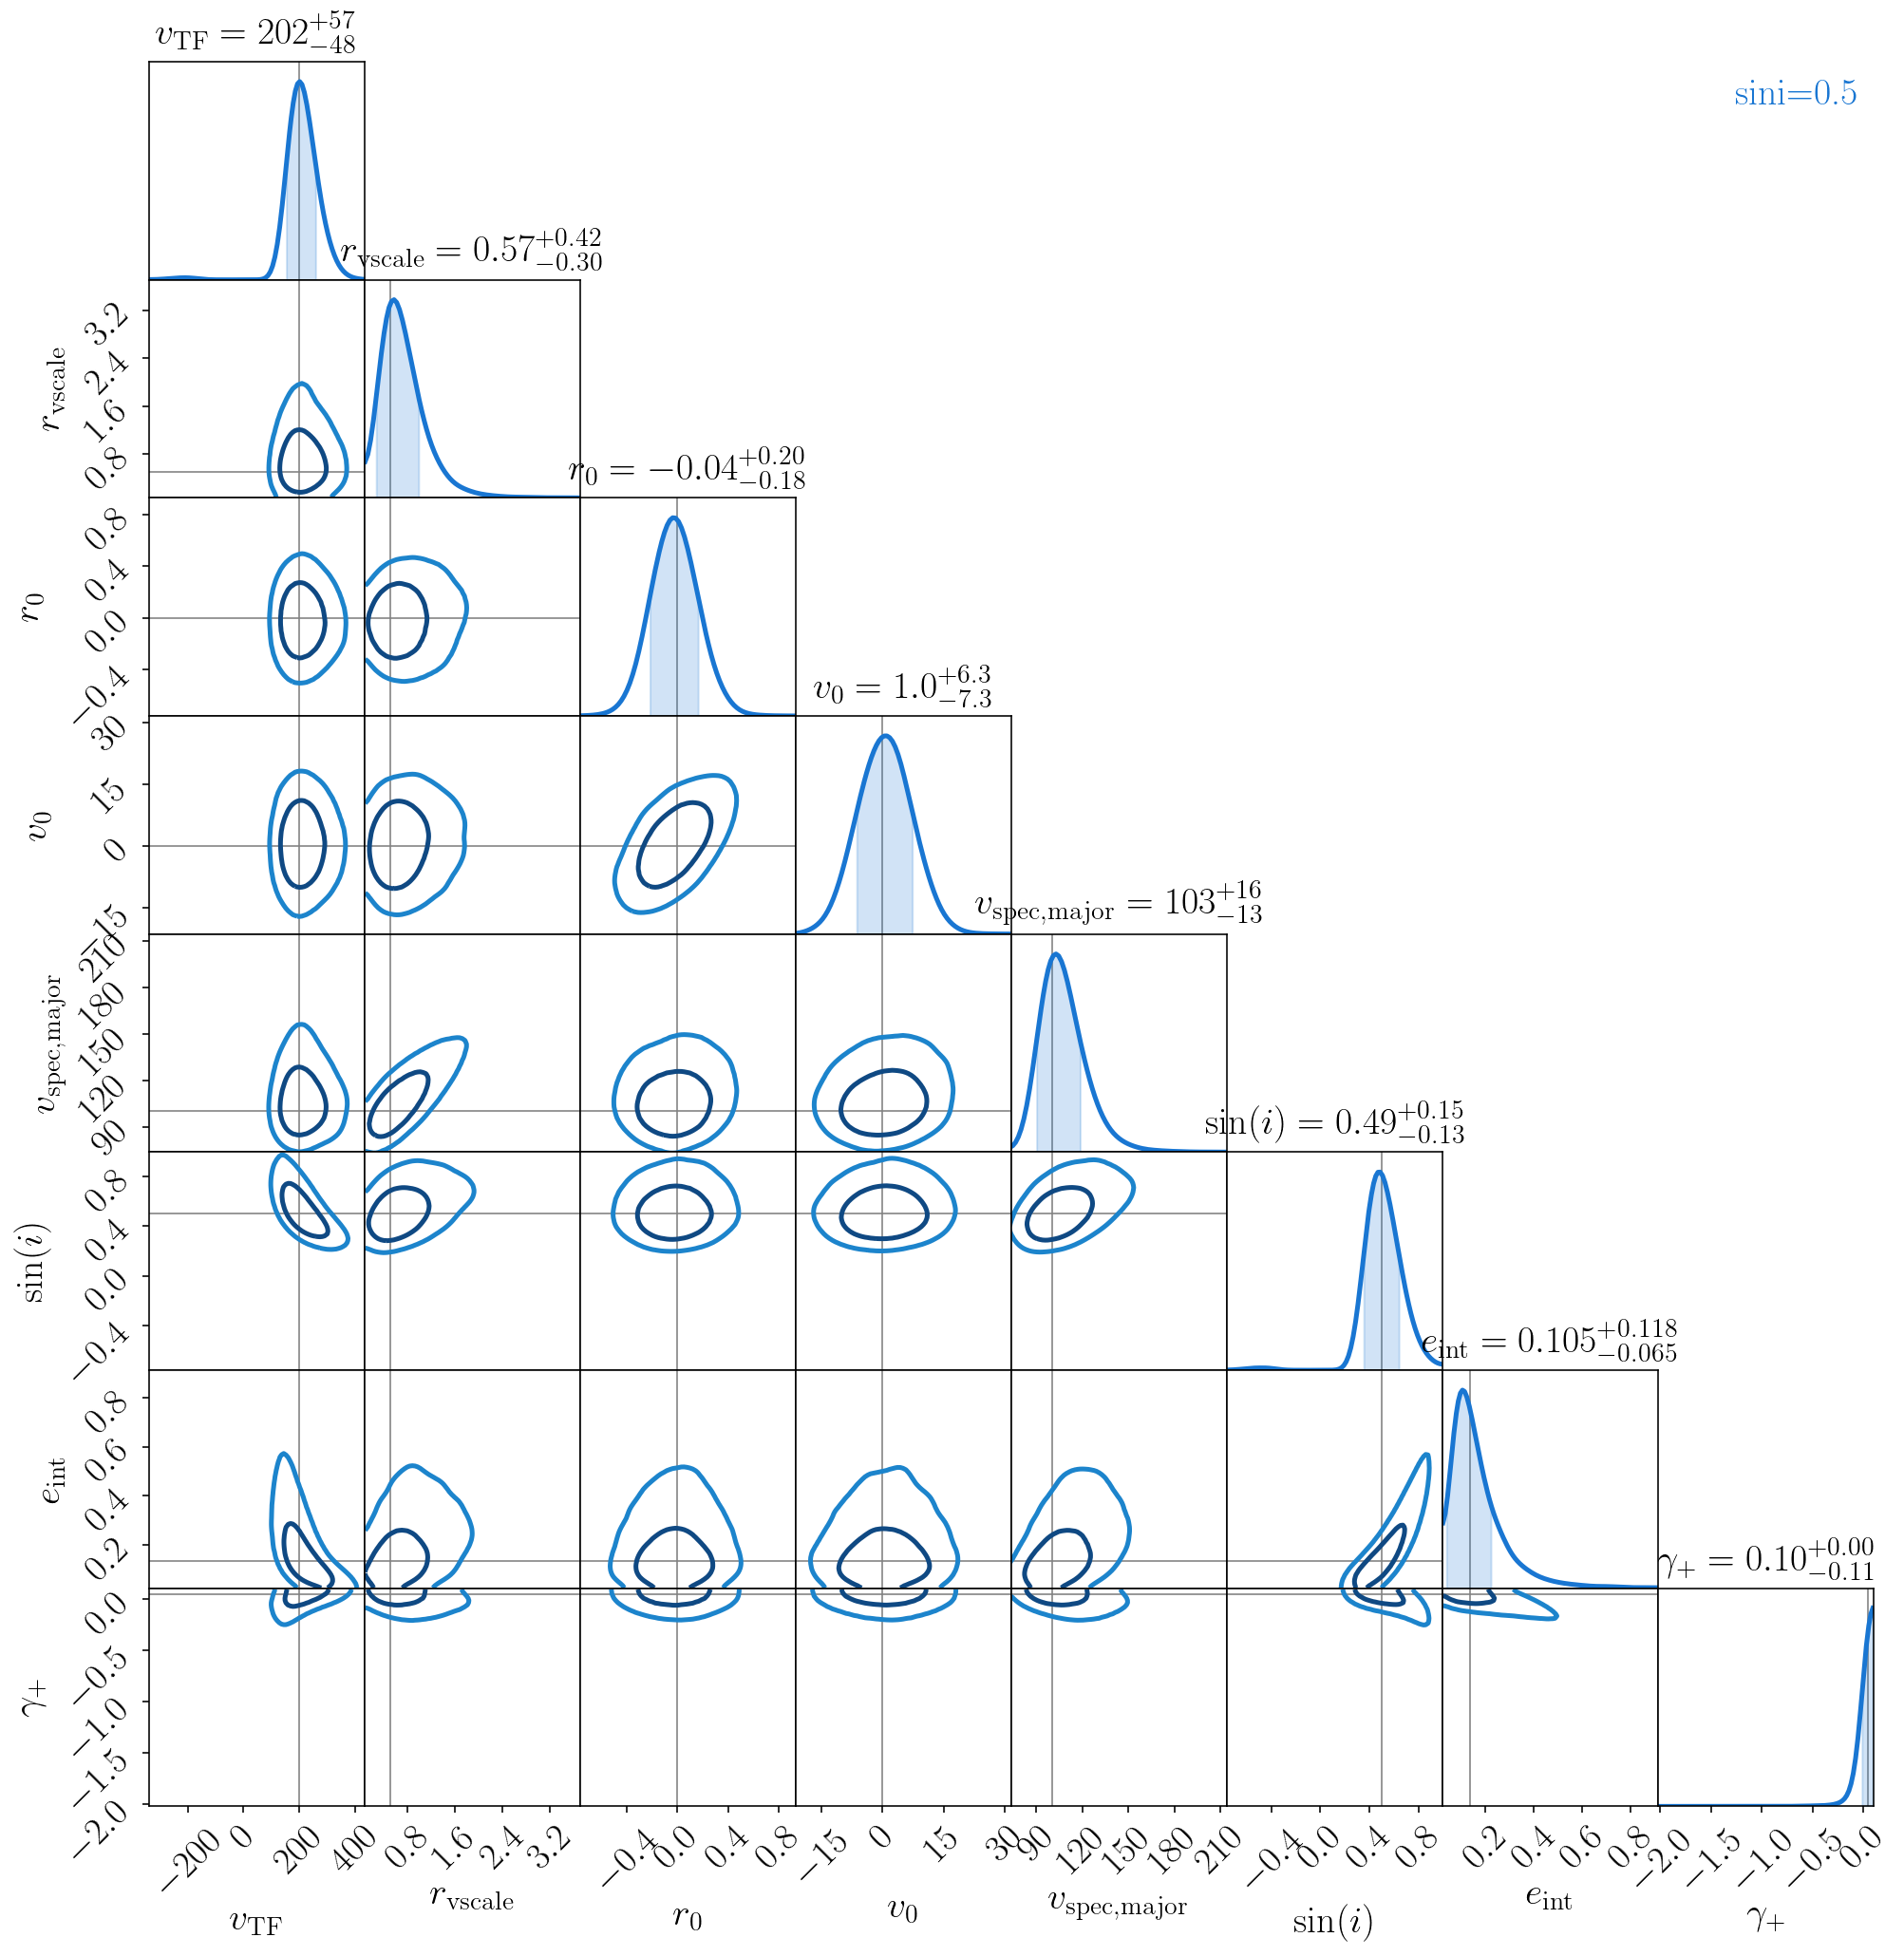

In [7]:
Nchains = 1
colors = [gray, lightblue, red, yellow, blue, yellowgreen, green, green, black]
lines = ["-", '--', "--", "-.", '-', ":", "--", ':']

statistics="max"

select_par_key = ['v_TF', 'vscale', 'r_0', 'v_0', 'v_spec_major','sini', 'e_int', 'gamma_p']

legend_chain = "sini=%.1f"%sini

parID1,parName1,par_x1 = Chain.select_par_info(select_par_key)

c = ChainConsumer()
c.add_chain(Chain.chain[:, parID1]       , parameters=parName1 ,name=legend_chain)

c.configure(linewidths=2.5,sigmas=np.array([0,1,2]),bins=0.5,sigma2d=False,label_font_size=20,tick_font_size=20,
            shade=[False]*Nchains,
            statistics=statistics,summary=True)

c.configure_truth(color="gray",lw=1,ls="-",alpha=0.8, zorder=-1)
fig = c.plotter.plot(legend=True, truth=par_x1)

fig.subplots_adjust(left=0.12, right=0.99, bottom=0.11, top=0.99)

fig.set_size_inches(2.5 + fig.get_size_inches())
fig.savefig("fig_all_pars.pdf", transparent=True)